# Term Summary Generation (with more prompting strategies and quality metrics)

**Задача:**
1. преобразовать экстрактивно извлеченные предложения в RAG-контекст для генеративных моделей;
2. извлечь для сравнения (10 терминов):
    - вики-статьи;
    - тексты статей из корпуса, в которых упоминался термин;
    - RAG-контекст (в виде сплошного текста);
4. настроить промпт генерации абстрактивных выжимок для всех 20 терминов;
5. проверить работу нескольких крупных LLM с RAG-контекстом и без, оценить схожесть ответов с вики-этолоном (ROUGE-score, BLEU-score и человеческая оценка). 

In [71]:
import os
import re

import math

from collections import defaultdict

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from nltk import word_tokenize, sent_tokenize, pos_tag, WordPunctTokenizer
from nltk.corpus import stopwords
from razdel import sentenize

import pymorphy2 as pm2

import evaluate
from nltk.translate.bleu_score import sentence_bleu, modified_precision
from rouge_score.rouge_scorer import RougeScorer

from gradio_client import Client

### 0. Manual Term Tuning

Зададим 20 терминов для проверки LLM и вручную восстановим их правильную грамматическую форму:

In [2]:
# terms with related wiki article
wiki_terms = [
    'акустическая эмиссия',
    'квантовая точка',
    'внутренние волны',
    'волна Рэлея',
    'калибровочные бозоны',
    'меченые атомы',
    'синглетный кислород',
    'число Стокса',
    'число Рэлея',
    'тяжёлая вода',
]

# terms without article
non_wiki_terms = [
    'волна накачки',
    'динамическая рекристаллизация',
    'ионосферная турбулентность',
    'квантовое биение',
    'оптическое выпрямление',
    'паразитная мода',
    'электронная концентрация',
    'хаотическая синхронизация',
    'функция памяти',
    'ударный слой',
]

# combined terms
terms = wiki_terms + non_wiki_terms

len(terms)

20

In [3]:
normalized_to_correct_term = {
    'акустический_эмиссия': 'акустическая эмиссия',
    'квантовый_точка': 'квантовая точка',
    'внутренний_волна': 'внутренние волны',
    'волна_рэлей': 'волна Рэлея',
    'калибровочный_бозон': 'калибровочные бозоны',
    'меченый_атом': 'меченые атомы',
    'синглётный_кислород': 'синглетный кислород',
    'число_стокс': 'число Стокса',
    'число_рэлей': 'число Рэлея',
    'тяжёлый_вода': 'тяжёлая вода',
    'волна_накачка': 'волна накачки',
    'динамический_рекристаллизация': 'динамическая рекристаллизация',
    'ионосферный_турбулентность': 'ионосферная турбулентность',
    'квантовый_биение': 'квантовое биение',
    'оптический_выпрямление': 'оптическое выпрямление',
    'паразитный_мода': 'паразитная мода',
    'электронный_концентрация': 'электронная концентрация',
    'хаотический_синхронизация': 'хаотическая синхронизация',
    'функция_память': 'функция памяти',
    'ударный_слой': 'ударный слой',
}

len(normalized_to_correct_term)

20

In [4]:
def split_normalized_term(term):
    """Splits normalized term into a list of unigrams."""
    return term.split('_')

In [5]:
correct_to_normalized_term = {v: split_normalized_term(k) for k, v in normalized_to_correct_term.items()}

len(correct_to_normalized_term)

20

### 1. Forging RAG Contexts

In [6]:
extract_dir = '../data/data_frames/eval_20_results'

term_to_context = {}
term_to_target_rag_raw = {}
for filename in tqdm(os.scandir(extract_dir), desc='Forging RAG contexts'):
    term_name = normalized_to_correct_term[filename.name[:-4]]
    term_df = pd.read_csv(filename, index_col=0)

    context = []
    target_rag = []
    for idx, row in enumerate(term_df.iterrows()):
        context.append(f'{idx + 1}. {row[1].sentence}')
        target_rag.append(row[1].sentence)

    context = '\n'.join(context)
    target_rag = ' '.join(target_rag)

    term_to_context[term_name] = context
    term_to_target_rag_raw[term_name] = target_rag

Forging RAG contexts: 0it [00:00, ?it/s]

### 2. Loading Target Texts

In [7]:
hyper_link = re.compile(r'\[[0-9]+\]')
regular_link = re.compile(r'\([0-9]+(\.[0-9]+)?\)')
eng_link = re.compile(r'\[англ.\](\*)?')


def remove_link(link_type, text):
    """Removes one specific link type from text."""
    tmp_text = []

    start = 0
    for match in link_type.finditer(text):
        end = match.start()
        tmp_text.append(text[start: end])
        start = match.end()
    tmp_text.append(text[start:])

    return ''.join(tmp_text)


def remove_links(text):
    """Removes all link types from text."""
    no_hyper_text = remove_link(hyper_link, text)
    no_reg_text = remove_link(regular_link, no_hyper_text)
    no_eng_text = remove_link(eng_link, no_reg_text)
    
    return no_eng_text

In [8]:
def normalize_text(lemmatizer, text):
    """Normalizes all tokens of the text."""
    tokens = word_tokenize(text.lower(), language='russian')
    normalized_tokens = [lemmatizer.parse(x)[0].normal_form for x in tokens]

    return ' '.join(normalized_tokens)

In [9]:
lemmatizer = pm2.MorphAnalyzer(lang='ru')

#### 2.1 Wikipedia Articles

Вручную извлечем для 10 терминов тексты вики-статей:

In [10]:
term_to_target_wiki_raw = {
    # --1-- #
    'акустическая эмиссия': '''Акустическая эмиссия (АЭ) — техническая диагностика, основанная на явлении возникновения и распространения упругих колебаний (акустических волн) в различных процессах, например, при деформации напряжённого материала, истечении газов, жидкостей, горении и взрыве и др.

Принцип действия

Принцип диагностики трещин с помощью акустической эмиссии (АЭ).
Механизм излучения акта АЭ в металлах с ОЦК решеткой при объединении дислокаций в микротрещину по механизму Коттрелла
Основной принцип диагностики инженерных сооружений и конструкций заключается в пассивном сборе информации с множества звуковых (и ультразвуковых) датчиков, её локализации и обработке для последующего определения зоны и степени износа конструкции[1][2].

Механизм излучения первичного упругого импульса АЭ (акт АЭ) может иметь различную физическую природу. На рисунке показан механизм излучения акта АЭ при зарождении микротрещины по механизму Коттрелла вследствие прорыва скопления дислокаций (дислокация – это линейный дефект в кристаллической решётке материала) через границу в металлах с объемно-центрированной кубической (ОЦК) решеткой при механическом нагружении, а также временные диаграммы потока актов АЭ (1) и потока регистрируемых сигналов АЭ (2).[3]

Практика использования
АЭ является следствием подвижек среды, что позволяет использовать её для диагностики процессов и материалов[4]. Например, количественно АЭ — критерий целостности материала, который определяется звуковым излучением материала при контрольном его нагружении.

Эффект акустической эмиссии может использоваться для выявления образования внутренних дефектов на начальной стадии разрушения конструкции. Он же может быть использован для определения степени сейсмической опасности геологических пород, при этом эмиссию можно вызывать искусственно[5].

Метод АЭ дает возможность исследовать кинетику процессов на самых ранних стадиях микродеформации, дислокационного зарождения и накопления микронесплошностей. Грубо говоря, каждая трещинка как бы «кричит» о своем росте. Это позволяет диагностировать по сопутствующей АЭ сам момент зарождения трещины. Кроме того, для каждой уже зародившейся трещины существует некоторый критический размер, зависящий от свойств материала[3]. До этого размера трещина подрастает очень медленно (иногда десятки лет) посредством огромного количества небольших дискретных скачков, сопровождаемых АЭ излучением. После достижения трещиной критического размера происходит катастрофическое разрушение, т.к. ее дальнейший рост идет уже со скоростью, близкой к половине скорости звука в материале конструкции. Принимая с помощью особой высокочувствительной аппаратуры и измеряя в самом простейшем случае интенсивность dNa/dt (количество в единицу времени), а также общее количество актов (событий) АЭ, Na, удается по данным АЭ экспериментально оценить скорость роста, длину трещины и прогнозировать близость разрушения[3].

Существенное расширение возможностей АЭ метода диагностики дает применение к нему статистических методов анализа потоков случайных событий[3]. Это позволяет повысить достоверность АЭ метода и количественно оценить достоверность его результатов[6]. В настоящее время метод АЭ активно используется в задачах контроля и диагностики объектов атомного энергетического машиностроения, авиационной, ракетно-космической техники, железнодорожного транспорта, исторических артефактов (например, Царь-колокола в Московском Кремле), а также других изделий и объектов ответственного назначения.[7]

Примеры проявления
Перед тем как начать ломаться, нагруженная ветка дерева издаёт специфический скрип, при этом наблюдается скачкообразный импульс АЭ-сигнала; Затем, если на ветку продолжает действовать достаточная нагрузка, происходит постепенная поломка, а при этом можно слышать звук от пачки импульсов АЭ.
АЭ при твердофазном горении органических порошков позволяет диагностировать как химическую реакцию, так и материалы, получающиеся при этом.
АЭ проявляется также в ходе физико-химических процессов в жидкостях, что позволяет проводить диагностирование параметров этих процессов по данным АЭ излучения[3].''',
    # --2-- #
    'квантовая точка': '''Квантовая точка (КТ, нанокристал, искусственный атом) — фрагмент проводника или полупроводника (например InGaAs, CdSe, CdS или GaInP/InP), носители заряда (электроны или дырки) которого ограничены в пространстве по всем трём измерениям. Размер квантовой точки должен быть настолько мал, чтобы квантовые эффекты были существенными[2]. Когда их освещают УФ-светом, электрон в квантовой точке может быть возбуждён до состояния с более высокой энергией[3]. В случае полупроводниковой квантовой точки этот процесс соответствует переходу электрона из валентной зоны в зону проводимости. Возбуждённый электрон может вернуться в валентную зону, высвободив свою энергию в виде фотона[3]. Это излучение света (фотолюминесценция) показано на рисунке справа. Цвет этого света зависит от разницы энергий между зоной проводимости и валентной зоной или от перехода между дискретными энергетическими состояниями, когда зонная структура в КТ нечётко определена.

Наноразмерные полупроводниковые материалы плотно удерживают либо электроны, либо дырки. Удержание похоже на частицу в ящике. Особенности поглощения и излучения квантовых точек соответствуют переходам между дискретными квантово-механически разрешёнными уровнями энергии в ящике, напоминающими атомные спектры. По этим причинам квантовые точки иногда называют искусственными «атомами»[4], подчёркивая их связанные[англ.]* и дискретные электронные состояния, подобно встречающимся в природе атомам или молекулам[5][6]. Электронные волновые функции в квантовых точках напоминают таковые в реальных атомах[7]. Соединив две или более квантовых точек можно создать искусственную «молекулу», проявляющую гибридизацию даже при комнатной температуре[8]. Точная сборка квантовых точек может сформировать сверхрешётки, которые действуют как искусственные твёрдотельные материалы и обладают уникальными оптическими и электронными свойствами[9][10].

Квантовые точки обладают промежуточными свойствами между объёмными полупроводниками и отдельными атомами или молекулами. Их оптоэлектронные свойства изменяются в зависимости как от размера, так и от формы[11][12]. Более крупные КТ диаметром 5—6 нм излучают более длинные волны таких цветов, как оранжевый или красный. КТ меньшего размера (2—3 нм) излучают более короткие волны, создавая синий и зелёный свет. Однако конкретные цвета различаются в зависимости от точного химического состава КТ[13].

Потенциальные применения квантовых точек включают одноэлектронные транзисторы, солнечные элементы, светодиоды, лазеры[14], источники одиночных фотонов[англ.][15][16][17], генерацию второй гармоники, квантовые вычисления[18], исследования в клеточной биологии[19], микроскопию[англ.][20] и медицинскую визуализацию[21]. Их небольшой размер позволяет суспендировать некоторые КТ в растворе и использовать их в струйной печати и центрифугировании[англ.][22]. Они использовались в тонких плёнках Ленгмюра — Блоджетт[23][24][25]. Эти технические средства приводят к созданию менее дорогих и менее трудоёмких методов изготовления полупроводников.

Существует несколько распространённых способов создания квантовых точек. Возможные методы включают коллоидный синтез, самосборку, использование электрического поля и другие.

Коллоидные суспензии (взвеси) квантовых точек, облученные УФ-светом. Квантовые точки разного размера переизлучают разные цвета света из-за квантового размерного эффекта.
Квантовые точки со ступенчатым изменением спектра излучения от фиолетового к тёмно-красному[1].
Примерные размеры квантовых точек во взвесях:
2 нм — синий цвет излучения,
4 нм — зелёный,
5 нм — жёлтый,
6 нм — красный.


Коллоидный синтез
Коллоидные полупроводниковые нанокристаллы синтезируются из растворов подобно традиционным химическим процессам. Основное отличие заключается в том, что продукт не выпадает в осадок в виде твёрдого вещества и не остаётся растворённым[11]. Нагревая раствор при высокой температуре, прекурсоры разлагаются с образованием мономеров, которые затем создают нанокристаллы на зародышах. Температура является решающим фактором при определении оптимальных условий для роста нанокристаллов. Она должна быть достаточно высокой, чтобы обеспечить возможность перегруппировки и отжига атомов в процессе синтеза, и в то же время достаточно низкой, чтобы способствовать росту кристаллов. Концентрация мономеров — ещё один критический фактор, который необходимо строго контролировать во время роста нанокристаллов. Этот процесс может протекать в двух различных режимах: «фокусировка» и «дефокусировка». При высоких концентрациях мономера критический размер (размер, при котором нанокристаллы не растут и не сжимаются) относительно мал, что приводит к росту почти всех частиц. В этом режиме более мелкие частицы растут быстрее, чем крупные (поскольку более крупным кристаллам для роста требуется больше атомов, чем маленьким кристаллам), что создаёт фокусировку функции распределения КТ по размерам, что приводит к невероятному распределению почти монодисперсных частиц. Фокусировка по размеру оптимальна, когда концентрация мономера поддерживается такой, что средний размер присутствующих нанокристаллов всегда немного превышает критический размер. Со временем концентрация мономера уменьшается, критический размер становится больше существующего среднего размера, и распределение дефокусируется.


Квантовые точки сульфида кадмия на клетках
Созданы коллоидные методы производства множества различных полупроводниковых КТ. Типичные точки состоят из бинарных соединений, таких как сульфид свинца, селенид свинца, селенид кадмия, сульфид кадмия, теллурид кадмия, арсенид индия и фосфид индия. КТ также можно изготовить из тройных соединений, таких как сульфид селенида кадмия. Кроме того, недавние достижения позволили синтезировать коллоидные квантовые точки перовскита[26]. Эти квантовые точки могут содержать от 100 до 100 000 атомов в объёме квантовой точки с диаметром от ≈10 до 50 диаметров атомов. Это соответствует примерно от 2 до 10 нанометров, а при 10 нм в диаметре[27].


Идеализированное изображение коллоидной наночастицы сульфида свинца (селенида) с полной пассивацией олеиновой кислотой, олеиламином и гидроксильными лигандами (размер ≈5 нм)[27].
Большие количества квантовых точек могут быть синтезированы посредством коллоидного синтеза. Благодаря такой масштабируемости и удобству лабораторных условий коллоидные синтетические методы перспективны для коммерческого применения.

Плазменный синтез
Плазменный синтез стал одним из самых популярных газофазных подходов к производству квантовых точек, особенно с ковалентными связями[28][29][30]. Например, квантовые точки из кремния (Si) и германия (Ge) были синтезированы с использованием неравновесной плазмы. Размером, формой, поверхностью и составом квантовых точек можно управлять при использовании неравновесной плазмы[31][32]. Легирование, которое является весьма сложным процессом для квантовых точек, также было реализовано в плазменном синтезе[33][34][35]. Плазменный синтез приводит к КТ в форме порошка, поверхность которого можно модифицировать. Это может привести к превосходному диспергированию квантовых точек либо в органических растворителях[36], либо в воде (то есть коллоидных квантовых точек)[37].

Производство в присутствии электрического поля
Электростатический потенциал, необходимый для создания квантовой точки, можно реализовать несколькими методами. К ним относятся внешние электроды[38], легирование, деформация[39] или примеси. Самособирающихся квантовых точек обычно насчитывается от 5 до 50 нм по размеру. КТи, образованные затворными электродами с литографическим рисунком или травлением двумерного электронного газа в полупроводниковых гетероструктурах, могут иметь поперечные размеры от 20 до 100 нм.

Некоторые квантовые точки представляют собой небольшие области одного материала, погружённые в другой, с большей запрещённой зоной. Это могут быть так называемые структуры ядро-оболочка, например, с CdSe в ядре и ZnS в оболочке, или из особых форм кремнезёма, называемых ормосилом. Субмонослойные оболочки также могут быть эффективными способами пассивации квантовых точек, например, ядра PbS с субмонослойными оболочками из CdS[40][41].
Квантовые точки иногда возникают спонтанно в структурах с квантовыми ямами из-за монослойных флуктуаций её толщины.

Изображение квантовой точки арсенида индия-галлия, в матрице арсениде галлия, полученное сканирующей просвечивающей электронной микроскопией с атомным разрешением.
Самособирающиеся квантовые точки зарождаются спонтанно при определённых условиях во время молекулярно-лучевой эпитаксии (МЛЭ) и осаждения металлорганических соединений из газообразной фазы (MOVPE), когда материал выращивается на подложке, с которой он не согласован по постоянной решётке. Возникающая в результате деформация приводит к образованию островков поверх двумерного смачивающего слоя. Этот режим роста известен как рост Странского — Крыстанова[42]. Впоследствии островки можно зарастить, чтобы сформировать квантовую точку. Широко используемым типом квантовых точек, выращенных этим методом, являются квантовые точки арсенида индия-галлия в арсениде галлия[43]. Такие квантовые точки имеют потенциал для применения в квантовой криптографии (то есть однофотонных источниках) и квантовых вычислениях. Основными ограничениями этого метода являются стоимость изготовления и отсутствие контроля над расположением отдельных точек.
Отдельные квантовые точки могут быть созданы из двумерных электронных или дырочных газов, присутствующих в удалённо легированных квантовых ямах или полупроводниковых гетероструктурах, называемых латеральными квантовыми точками. Поверхность образца покрывают тонким слоем резиста, а затем с помощью электронно-лучевой литографии в резисте определяют поперечный рисунок. Этот рисунок затем можно перенести на электронный или дырочный газ путём травления или нанесения металлических электродов, которые позволяют приложить внешнее напряжение между электронным газом и электродами. Такие квантовые точки в основном представляют интерес для экспериментов и приложений, связанных с транспортом электронов или дырок, а также используются в качестве спиновых кубитов[44]. Преимущество квантовых точек этого типа заключается в том, что их энергетический спектр можно сконструировать, контролируя геометрический размер, форму и силу удерживающего потенциала с помощью электродов затвора. Эти квантовые точки легко соединяются туннельными барьерами с проводящими выводами, что позволяет применять для их исследования методы туннельной спектроскопии.
Дополнительная технология металл-оксид-полупроводник (КМОП) может быть использована для изготовления кремниевых квантовых точек. Ультра маленький (L = 20 нм, W = 20 нм) КМОП-транзисторы ведут себя как одноэлектронные квантовые точки при криогенной температуре в диапазоне −269 °С (4 К) примерно до −258 °С (15 К). В транзисторе наблюдается кулоновская блокада из-за последовательного процесса зарядки электронами (дырками). Количество электронов (дырок), заключённых в канале, определяется напряжением на затворе, начиная с заполнения нуля электронов (дырок), и его можно установить равным 1 или нескольким[45].
Вирусная сборка
Генно-инженерные вирусы- бактериофаги М13 позволяют создавать биокомпозитные структуры с квантовыми точками[46]. Ранее было показано, что генно-инженерные вирусы могут распознавать определённые поверхности полупроводников методом селекции посредством комбинаторного фагового дисплея[47]. Кроме того, известно, что жидкокристаллические структуры вирусов дикого типа (Fd, M13 и TMV) можно регулировать путём контроля концентрации раствора, ионной силы раствора и внешнего магнитного поля, приложенного к растворам. Следовательно, специфические свойства распознавания вируса используются для организации неорганических нанокристаллов, образующих упорядоченные массивы в масштабе длины, определяемом образованием жидких кристаллов. Используя эту информацию, Lee et al. (2000) смогли создать самоорганизующиеся, высокоориентированные, самоподдерживающиеся плёнки из раствора фага и прекурсора ZnS. Эта система позволила им варьировать как длину бактериофага, так и тип неорганического материала посредством генетической модификации и отбора.

Электрохимическая сборка
Высокоупорядоченные массивы квантовых точек также получают электрохимическими методами. Шаблон создаётся путём ионной реакции на границе раздела электролит-металл, которая приводит к спонтанной сборке наноструктур, включая квантовые точки, на металле, который затем используется в качестве маски для меза-травления этих наноструктур на выбранной подложке.

Массовое производство
Массовое производство квантовых точек основано на процессе, называемом высокотемпературной двойной инжекцией, который был масштабирован многими компаниями для коммерческих приложений, требующих больших количеств (от сотен килограммов до тонн) квантовых точек. Воспроизводимые размеры КТ, получаемых этим методом производства, используются в широком диапазоне размеров и составов.

Связь в некоторых квантовых точках, не содержащих кадмия, таких как квантовые точки на основе элементов III—V групп, более ковалентна, чем в материалах II—VI групп, поэтому труднее разделить зарождение и рост наночастиц с помощью высокотемпературного синтеза с двойной инжекцией. Альтернативный метод синтеза квантовых точек — процесс молекулярного посева — обеспечивает путь к производству высококачественных квантовых точек с воспроизводимыми характеристиками в больших объёмах. В этом процессе используются идентичные молекулы молекулярного кластерного соединения в качестве центров зародышеобразования для роста наночастиц, что позволяет избежать необходимости в высокотемпературной стадии инжекции. Рост частиц поддерживается периодическим добавлением прекурсоров при умеренных температурах до тех пор, пока не будет достигнут желаемый размер частиц[48]. Процесс молекулярного посева не ограничивается производством квантовых точек, не содержащих кадмия; например, его используют для синтеза килограммовых партий высококачественных квантовых точек элементов II—VI групп всего за несколько часов.

Другой подход к массовому производству коллоидных квантовых точек можно увидеть в переносе известной методологии синтеза методом горячей инжекции в техническую систему с непрерывным потоком. Вариации от партии к партии, возникающие из-за потребностей в рамках упомянутой методологии, можно преодолеть за счёт использования технических компонентов для смешивания и выращивания, а также регулирования транспорта и температуры. Для производства полупроводниковых наночастиц на основе CdSe этот метод был исследован и настроен на объёмы производства кг в месяц. Поскольку использование технических компонентов обеспечивает лёгкую взаимозаменяемость с точки зрения максимальной пропускной способности и размера, её можно дополнительно увеличить до десятков или даже сотен килограммов[49].

В 2011 году консорциум американских и голландских компаний сообщил о важной вехе в крупносерийном производстве квантовых точек, применив традиционный высокотемпературный метод двойного инжекции в проточную систему[50].

23 января 2013 года компания Dow заключила эксклюзивное лицензионное соглашение с британской компанией Nanoco на использование их метода низкотемпературного молекулярного посева для массового производства безкадмиевых квантовых точек для электронных дисплеев, а 24 сентября 2014 года компания Dow начала работу над производственным предприятием в Южной Корее, способным производить достаточное количество квантовых точек для «миллионов телевизоров и других устройств, не содержащих кадмия, таких как планшеты». Массовое производство должно начаться в середине 2015 года[51]. 24 марта 2015 года компания Dow объявила о заключении партнерского соглашения с LG Electronics по развитию использования квантовых точек, не содержащих кадмия, в дисплеях[52].

Квантовые точки без тяжёлых металлов
Во многих регионах мира в настоящее время действует ограничение или запрет на использование токсичных тяжелых металлов в предметах домашнего обихода, а это означает, что большинство квантовых точек на основе кадмия непригодны для применения в потребительских товарах.

Для коммерческой жизнеспособности был разработан ряд ограниченных квантовых точек, не содержащих тяжёлых металлов, которые демонстрируют яркое излучение в видимой и ближней инфракрасной области спектра и имеют оптические свойства, аналогичные свойствам квантовых точек CdSe. Среди этих материалов — InP/ZnS, CuInS/ZnS, Si, Ge и C.

Пептиды исследуются как потенциальный материал для квантовых точек[53].

Здоровье и безопасность
Некоторые квантовые точки при определённых условиях представляют опасность для здоровья человека и окружающей среды[54][55][56]. Примечательно, что исследования токсичности квантовых точек были сосредоточены на частицах, содержащих кадмий, и ещё не были продемонстрированы на животных моделях после физиологически значимых доз[56]. Исследования токсичности квантовых точек (КТ) in vitro, основанные на клеточных культурах, позволяют предположить, что их токсичность может быть обусловлена множеством факторов, включая их физико-химические характеристики (размер, форма, состав, поверхностные функциональные группы и поверхностные заряды) и окружающую среду. Оценка их потенциальной токсичности сложна, поскольку эти факторы включают такие свойства, как размер КТ, заряд, концентрация, химический состав, блокирующие лиганды, а также их окислительная, механическая и фотолитическая стабильность[54].

Многие исследования были сосредоточены на механизме цитотоксичности КТ с использованием модельных клеточных культур. Было продемонстрировано, что после воздействия ультрафиолетового излучения или окисления воздухом КТ CdSe выделяют свободные ионы кадмия, вызывая гибель клеток[57]. Сообщалось также, что КТ из элементов II—VI групп индуцируют образование активных форм кислорода после воздействия света, что, в свою очередь, может повредить клеточные компоненты, такие как белки, липиды и ДНК[58]. Некоторые исследования также показали, что добавление оболочки ZnS ингибирует процесс образования активных форм кислорода в КТ CdSe. Другой аспект токсичности КТ заключается в том, что in vivo существуют внутриклеточные пути, зависящие от размера, которые концентрируют эти частицы в клеточных органеллах, недоступных для ионов металлов, что может приводить к уникальным образцам цитотоксичности по сравнению с составляющими их ионами металлов[59]. Сообщения о локализации КТ в ядре клетки[60] представляют дополнительные виды токсичности, поскольку они могут вызывать мутации ДНК, которые, в свою очередь, будут распространяться в будущих поколениях клеток, вызывая заболевания.

Хотя в исследованиях in vivo с использованием животных моделей сообщалось о концентрации КТ в некоторых органеллах, ни гистологический, ни биохимический анализ не выявил никаких изменений в поведении животных, их весе, гематологических маркерах или повреждении органов[61]. Эти результаты заставили учёных поверить в то, что внутриклеточная доза является наиболее важным фактором, определяющим токсичность КТ. Следовательно, факторы, определяющие эндоцитоз КТ, определяющие эффективную внутриклеточную концентрацию, такие как размер, форма и химия поверхности КТ, определяют их токсичность. Выведение КТ через мочу на животных моделях также было продемонстрировано путем инъекции КТ CdSe, помеченных радиоактивным изотопом ZnS, где лигандная оболочка была помечена 99m Tc[62]. Хотя многочисленные другие исследования пришли к выводу о сохранении КТ на клеточном уровне[56][63], экзоцитоз КТ всё ещё плохо изучен в литературе.

Хотя значительные исследовательские усилия расширили понимание токсичности КТ, в литературе существуют большие расхождения, и вопросы всё ещё требуют ответов. Разнообразие этого класса материалов по сравнению с обычными химическими веществами делает оценку их токсичности весьма сложной задачей. Поскольку их токсичность также может быть динамической в зависимости от факторов окружающей среды, таких как уровень pH, освещённость и тип клеток, традиционные методы оценки токсичности химических веществ, такие как LD 50, неприменимы для КТ. Поэтому исследователи сосредотачиваются на внедрении новых подходов и адаптации существующих методов для включения этого уникального класса материалов[56]. Научное сообщество изучает новые стратегии создания более безопасных КТ. Недавней новинкой в этой области является открытие углеродных квантовых точек — нового поколения оптически активных наночастиц, потенциально способных заменить полупроводниковые КТ, но чьим преимуществом является гораздо меньшая токсичность.

Оптические свойства
В полупроводниках поглощение света обычно приводит к тому, что электрон перемещается из валентной зоны в зону проводимости, оставляя после себя дырку. Электрон и дырка могут образовывать связанное состояние, образуя экситон. Когда этот экситон рекомбинирует (то есть электрон возвразается в своё основное состояние), энергия экситона может излучаться в виде света. Это явление называется флуоресценцией. В упрощённой модели энергию испускаемого фотона можно понимать как сумму энергии запрещённой зоны между самым высоким занятым уровнем и самым низким незанятым энергетическим уровнем, энергий удержания дырки и возбуждённого электрона, а также энергии связи экситона (электронно-дырочной пары).


Рисунок представляет собой упрощённое изображение, показывающее возбужденный электрон и дырку в эксите и соответствующие энергетические уровни. Полную энергию можно рассматривать как сумму энергии запрещённой зоны, энергии, участвующей в кулоновском притяжении в экситоне, и энергий удержания возбуждённого электрона и дырки.
Поскольку энергия размерного квантования зависит от размера квантовой точки, как начало поглощения, так и излучение флуоресценции можно регулировать, изменяя размер квантовой точки во время её синтеза. Чем больше точка, тем краснее (более низкая энергия) начало её поглощения и спектр флуоресценции. И наоборот, меньшие точки поглощают и излучают более синий (более энергетический) свет. Кроме того, было показано[64], что время жизни флуоресценции определяется размером квантовой точки. Точки большего размера имеют более близко расположенные энергетические уровни, на которых может быть захвачена пара электрон-дырка. Следовательно, электронно-дырочные пары в более крупных точках живут дольше, поэтому более крупные точки демонстрируют более длительные времена жизни.

Чтобы улучшить квантовый выход флуоресценции, квантовые точки можно создать с оболочками из полупроводникового материала с большей запрещённой зоной вокруг них. Предполагается, что улучшение связано с уменьшением доступа электронов и дырок к путям безызлучательной поверхностной рекомбинации в некоторых случаях, но также и с уменьшением оже-рекомбинации в других.

Приложения
Квантовые точки особенно перспективны для оптических применений из-за их высокого коэффициента поглощения[65] и сверхбыстрых оптических нелинейностей, что потенциально может применяться для разработки полностью оптических систем[66]. Они работают как одноэлектронный транзистор и демонстрируют эффект кулоновской блокады. Квантовые точки также предлагались в качестве реализации кубитов для обработки квантовой информации[67] и в качестве активных элементов для термоэлектриков[68][69][70].


Устройство, которое производит видимый свет посредством передачи энергии от тонких слоёв квантовых ям к кристаллам над слоями[71].
Будучи нульмерными, квантовые точки имеют более неоднородную плотность состояний, чем структуры более высокой размерности. В результате они обладают превосходными транспортными и оптическими свойствами. Они потенциально могут использоваться в диодных лазерах, усилителях и биологических сенсорах[72]. Квантовые точки можно возбуждать в локально усиленном электромагнитном поле, создаваемом наночастицами золота, что затем можно наблюдать по поверхностному плазмонному резонансу в спектре фотолюминесцентного возбуждения нанокристаллов (CdSe)ZnS. Высококачественные квантовые точки хорошо подходят для оптического кодирования и мультиплексирования благодаря своим широким профилям возбуждения и узким симметричным спектрам излучения. Новые поколения квантовых точек обладают далеко идущим потенциалом для изучения внутриклеточных процессов на уровне отдельных молекул, визуализации клеток с высоким разрешением, долгосрочного наблюдения за движением клеток in vivo, нацеливания на опухоли и диагностики.

Нанокристаллы CdSe являются эффективными триплетными фотосенсибилизаторами[73]. Лазерное возбуждение небольших наночастиц CdSe позволяет извлекать энергию возбуждённого состояния из квантовых точек в объёмный раствор, открывая тем самым двери для широкого спектра потенциальных применений, таких как фотодинамическая терапия, фотоэлектрические устройства, молекулярная электроника и катализ.

Подкожный учёт
В декабре 2019 года Роберт С. Лангер и его команда разработали и запатентовали метод, с помощью которого можно использовать трансдермальные пластыри для нанесения идентификационной татуировки людям с помощью невидимых чернил для подкожного хранения информации. Это было представлено как благо для «развивающихся стран», где отсутствие инфраструктуры означает отсутствие медицинской документации[74][75]. Технология, переданная Массачусетскому технологическому институту[75] использует «краситель на основе квантовых точек, который доставляется, в данном случае вместе с вакциной, с помощью микроигольного пластыря». Исследование финансировалось Фондом Билла и Мелинды Гейтс и Институтом интегративных исследований рака Коха[74].

Биология
В современном биологическом анализе используются различного рода органические красители. Однако по мере развития технологий возникает потребность в большей гибкости этих красителей[76]. С этой целью квантовые точки быстро взяли на себя эту роль, поскольку они превосходят традиционные органические красители по нескольким параметрам, одним из наиболее очевидных из которых является яркость (благодаря высокому коэффициенту поглощения в сочетании с сопоставимым квантовым выходом с флуоресцентными красителями)[19], а также их стабильность (позволяющая гораздо меньше фотообесцвечивания)[77]. Было подсчитано, что квантовые точки в 20 раз ярче и в 100 раз более стабильны, чем традиционные флуоресцентные репортеры[76]. Нерегулярное мерцание квантовых точек при отслеживании одиночных частиц является незначительным недостатком. Однако были группы, которые разработали квантовые точки, которые по сути не мерцают, и продемонстрировали их полезность в экспериментах по отслеживанию одиночных молекул[78][79].

Использование квантовых точек для высокочувствительной клеточной визуализации добилось значительных успехов[80]. Например, улучшенная фотостабильность квантовых точек позволяет получать множество последовательных изображений в фокальной плоскости, которые можно реконструировать в трёхмерное изображение с высоким разрешением[81]. Ещё одно приложение, в котором используется исключительная фотостабильность зондов с квантовыми точками, — это отслеживание молекул и клеток в реальном времени в течение длительных периодов времени[82]. Антитела, стрептавидин[83], пептиды[84], ДНК[85], аптамеры нуклеиновых кислот[86] или низкомолекулярные лиганды[87] могут использоваться для нацеливания квантовых точек на определённые белки клеток. Исследователям удалось наблюдать квантовые точки в лимфатических узлах мышей более 4 месяцев[88].

Квантовые точки могут обладать антибактериальными свойствами, подобными наночастицам, и могут убивать бактерии в зависимости от дозы[89]. Одним из механизмов, с помощью которого квантовые точки могут убивать бактерии, является нарушение функций антиоксидантной системы в клетках и подавление антиоксидантных генов. Кроме того, квантовые точки могут напрямую повредить клеточную стенку. Было показано, что квантовые точки эффективны как против грамположительных, так и против грамотрицательных бактерий[90].

Полупроводниковые квантовые точки также использовались для визуализации предварительно меченных клеток in vitro. Ожидается, что способность отображать миграцию отдельных клеток в режиме реального времени будет важна для нескольких областей исследований, таких как эмбриогенез, метастазирование рака, терапия стволовыми клетками и иммунология лимфоцитов.

Одним из применений квантовых точек в биологии является использование донорных флуорофоров при резонансном переносе энергии Фёрстера, где большой коэффициент преломления и спектральная чистота этих флуорофоров делают их превосходящими молекулярные флуорофоры[91]. Широкий спектр оптического поглощения КТ позволяет избирательно возбуждать донор и минимально возбуждать акцептор красителя в исследованиях на основе FRET[92]. Недавно была продемонстрирована применимость модели FRET, которая предполагает, что квантовую точку можно аппроксимировать точечным диполем[93].

Использование квантовых точек для нацеливания на опухоли в условиях in vivo использует две схемы: активное нацеливание и пассивное нацеливание. В случае активного нацеливания квантовые точки функционализируются опухолеспецифическими сайтами связывания для избирательного связывания с опухолевыми клетками. Пассивное нацеливание использует усиленное проникновение и удержание опухолевых клеток для доставки зондов с квантовыми точками. Быстрорастущие опухолевые клетки обычно имеют более проницаемые мембраны, чем здоровые клетки, что позволяет мелким наночастицам проникать в тело клетки. Кроме того, у опухолевых клеток отсутствует эффективная лимфодренажная система, что приводит к последующему накоплению наночастиц.

Зонды с квантовыми точками проявляют токсичность in vivo. Например, нанокристаллы CdSe высокотоксичны для культивируемых клеток под воздействием УФ-излучения, поскольку частицы растворяются в процессе, известном как фотолиз, с высвобождением токсичных ионов кадмия в среду культуры. Однако было обнаружено, что в отсутствие УФ-облучения квантовые точки со стабильным полимерным покрытием практически нетоксичны[88][55]. Инкапсуляция квантовых точек гидрогелем позволяет помещать квантовые точки в стабильный водный раствор, уменьшая возможность утечки кадмия. Опять же, о процессе выделения квантовых точек из живых организмов известно очень мало[94].

В другом потенциальном применении квантовые точки исследуются в качестве неорганического флуорофора для интраоперационного обнаружения опухолей с помощью флуоресцентной спектроскопии.

Доставка неповреждённых квантовых точек в цитоплазму клетки была сложной задачей при использовании существующих методов. Векторные методы привели к агрегации и эндосомальной секвестрации квантовых точек, тогда как электропорация может повредить полупроводниковые частицы и агрегировать доставленные точки в цитозоль. Путём сжатия клеток квантовые точки могут быть эффективно доставлены без последующей агрегации, захвата материала эндосомами или значительной потери жизнеспособности клеток. Более того, было показано, что отдельные квантовые точки, полученные с помощью этого подхода, можно обнаружить в цитозоле клетки, что иллюстрирует потенциал этого метода для исследований по отслеживанию одиночных молекул[95].

Фотоэлектрические устройства
Настраиваемый спектр поглощения и высокие коэффициенты поглощения квантовых точек делают их привлекательными для технологий сбора света, таких как фотоэлектрическая энергетика. Квантовые точки могут повысить эффективность и снизить стоимость сегодняшних типичных кремниевых фотоэлектрических элементов. Согласно экспериментальному обзору 2004 года[96], квантовые точки селенида свинца (PbSe) могут производить более одного экситона из одного фотона высокой энергии посредством процесса умножения носителей или генерации множественных экситонов (МЭГ). Это выгодно отличается от современных фотоэлектрических элементов, которые могут управлять только одним экситоном на фотон высокой энергии, при этом носители высокой кинетической энергии теряют свою энергию в виде тепла. С другой стороны, квантово-ограниченные основные состояния коллоидных квантовых точек (например, сульфид свинца, PbS), включённые в исходные полупроводники с более широкой запрещённой зоной (например, перовскит), могут позволить генерировать фототок из фотонов с энергией ниже энергии запрещённой зоны основного материала через процесс двухфотонного поглощения, предлагающий другой подход (называемый промежуточной зоной, IB) для использования более широкого диапазона солнечного спектра и тем самым достижения более высокой фотоэлектрической эффективности[97][98].

Коллоидные фотоэлектрические элементы с квантовыми точками теоретически будут дешевле в производстве, поскольку их можно производить с помощью простых химических реакций.

Солнечные элементы только на квантовых точках
Ароматические самоорганизующиеся монослои (SAM) (например, 4-нитробензойная кислота) можно использовать для улучшения выравнивания энергетических зон на электродах и повышения эффективности. Этот метод обеспечил рекордный КПД преобразования мощности (PCE) 10,7 %[99]. SAM расположен между плёнкой коллоидных квантовых точек (CQD) ZnO-PbS для изменения выравнивания энергетических зон с помощью дипольного момента составляющей молекулы SAM, а модификацию энергетических зон можно изменить с помощью плотности, дипольного момента и ориентации молекулы SAM[99].

Квантовые точки в гибридных солнечных элементах
Коллоидные квантовые точки также используются в неорганических/органических гибридных солнечных элементах. Эти солнечные элементы привлекательны из-за возможности недорогого изготовления и относительно высокой эффективности[100]. Включение наноматериалов оксидов металлов, таких как ZnO, TiO2 и Nb2O5, в органические фотоэлектрические элементы было коммерциализировано с использованием полной рулонного производства[100]. Заявлено, что в гибридных солнечных элементах Si nanowire/PEDOT:PSS эффективность преобразования энергии составляет 13,2 %[101].

Квантовая точка с нанопроволокой в солнечных элементах
Другое потенциальное использование включает закрытые монокристаллические нанопроволоки ZnO с квантовыми точками CdSe, погруженные в меркаптопропионовую кислоту в качестве среды для переноса дырок, чтобы получить солнечный элемент, сенсибилизированный КТ. Морфология нанопроволок позволила электронам напрямую попадать к фотоаноду. Эта форма солнечного элемента демонстрирует внутреннюю квантовую эффективность 50-60 %[102].

Нанопроволоки с покрытиями из квантовых точек на кремниевых нанопроволоках (SiNW) и углеродных квантовых точках. Использование SiNW вместо планарного кремния повышает антифлексные свойства Si[103]. SiNW демонстрирует эффект улавливания света из-за захвата света в SiNW. Такое использование SiNW в сочетании с углеродными квантовыми точками привело к созданию солнечного элемента, уровень PCE которого достиг 9,10 %[103].

Квантовые точки графена также были смешаны с органическими электронными материалами для повышения эффективности и снижения стоимости фотоэлектрических устройств и органических светоизлучающих диодов (OLED) по сравнению с листами графена. Эти графеновые квантовые точки были функционализированы органическими лигандами, которые испытывают фотолюминесценцию в результате поглощения ультрафиолета или видимого излучения[104].

Светодиоды
Предлагается несколько методов использования квантовых точек для улучшения существующей конструкции светодиодов (LED), включая дисплеи на светодиодах с квантовыми точками (QD-LED или QLED) и дисплей на белых светоизлучающих диодах на квантовых точках (QD-WLED). Поскольку квантовые точки естественным образом создают квазимонохроматический свет, они могут быть более эффективными, чем источники света, которые должны иметь цветовую фильтрацию. КТ-светодиоды могут быть изготовлены на кремниевой подложке, что позволяет интегрировать их в стандартные кремниевые интегральные схемы или микроэлектромеханические системы[105].

Дисплеи с квантовыми точками
Обычный цветной жидкокристаллический дисплей (ЖК-дисплей) подсвечивается люминесцентными лампами (CCFL) или белыми светодиодами, которые подвергаются цветовой фильтрации для получения красных, зелёных и синих пикселей. В дисплеях с квантовыми точками в качестве источников света используются светодиоды, излучающие синий цвет, а не белые светодиоды. Преобразующая часть излучаемого света преобразуется в чистый зелёный и красный свет с помощью квантовых точек, излучающих соответствующие цвета, размещённых перед синим светодиодом или с помощью диффузного покрытия, наполненного квантовыми точками, в оптическом блоке подсветки задней поверхности. Пустые пиксели также используются для того, чтобы синий светодиод по-прежнему генерировал синие оттенки. Этот тип белого света в качестве подсветки ЖК-панели обеспечивает наилучшую цветовую гамму при меньших затратах, чем комбинация светодиодов RGB с использованием трёх светодиодов[106].

Другой метод, с помощью которого можно получить отображение квантовых точек, — это электролюминесцентный (ЭЛ) или электроэмиссионный метод. Это предполагает встраивание квантовых точек в каждый отдельный пиксель. Затем они активируются и контролируются с помощью пропускания электрического тока[107]. Поскольку зачастую это сам излучает свет, достижимые цвета в этом методе могут быть ограничены[108]. Электроэмиссионные телевизоры QD-LED существуют только в лабораториях.

Способность КТ точно преобразовывать и настраивать спектр делает их привлекательными для ЖК-дисплеев. Предыдущие ЖК-дисплеи могли тратить энергию на преобразование плохого красно-зелёного и насыщенного сине-жёлтого белого света в более сбалансированное освещение. Благодаря использованию КТ на экране содержатся только необходимые цвета для идеального изображения. В результате экран стал ярче, чётче и энергоэффективнее. Первым коммерческим применением квантовых точек стала серия плоских телевизоров Sony XBR X900A, выпущенная в 2013 году[109].

В июне 2006 года компания QD Vision объявила о техническом успехе в создании экспериментального дисплея на квантовых точках, демонстрирующего яркое излучение в видимой и ближней инфракрасной области спектра. QD-LED, встроенный в иглу сканирующей микроскопии, использовался для демонстрации изображений флуоресцентной сканирующей оптической микроскопии ближнего поля (NSOM)[110].

Фотоприёмники
Фотодетекторы на квантовых точках (QDP) изготавливаются либо методом обработки в растворе[111], либо из обычных монокристаллических полупроводников[112]. Обычные монокристаллические полупроводниковые КТП нельзя интегрировать в гибкую органическую электронику из-за несовместимости условий их выращивания с технологическими окнами (условиями производства), необходимыми для органических полупроводников. С другой стороны, QDP, обработанные методом решения, можно легко интегрировать с почти бесконечным разнообразием подложек, а также подвергать постобработке поверх других интегральных схем. Такие коллоидные QDP имеют потенциальное применение в камерах видимого и инфракрасного света[113], машинном зрении, промышленном контроле, спектроскопии и флуоресцентной биомедицинской визуализации.

Фотокатализаторы
Квантовые точки также действуют как фотокатализаторы для химического преобразования воды в водород под действием света, что является путём к солнечному топливу. При фотокатализе пары электронов и дырок, образующиеся в квантовой точке при превышении энергии запрещённой зоны, вызывают окислительно-восстановительные реакции в окружающей жидкости. Как правило, фотокаталитическая активность точек связана с размером частиц и степенью их квантовой потенциальной ямы[114]. Это связано с тем, что ширина запрещённой зоны определяет химическую энергию, запасённую в квантовой точке в возбуждённом состоянии. Препятствием для использования квантовых точек в фотокатализе является наличие поверхностно-активных веществ (или лигандов) на поверхности этих точек. Эти лиганды мешают химической активности квантовых точек, замедляя процессы массопереноса и переноса электронов. Кроме того, квантовые точки из халькогенидов металлов химически нестабильны в окислительных условиях и подвергаются реакциям фотокоррозии.

Теория
Квантовые точки теоретически можно описывать как точечные или нульмерные (0D) объекты. Большинство их свойств зависят от размеров, формы и материалов, из которых изготовлены КТ. Как правило, КТ обладают термодинамическими свойствами, отличными от их основного материала. Одним из таких эффектов является уменьшение точки плавления. Оптические свойства сферических металлических КТ хорошо описываются теорией рассеяния Ми.

Физико-химические свойства

Спектры флуоресценции квантовых точек теллурида кадмия (CdTe) различных размеров, размер коллоидных частиц увеличивается примерно от 2 нм до 20 нм — разные кривые с максимумами изображенными слева направо. Сдвиг пика флуоресценции в синюю область обусловлен квантовой ямой.
Широкий спектр поглощения, что позволяет возбуждать нанокристаллы разных цветов одним источником излучения.
Узкий и симметричный пик флуоресценции (без «хвоста» в красной области, как у органических красителей, полуширина пика флуоресценции 25—40 нм), что обеспечивает чистый цвет: точки размером 2 нм — голубой, 3 нм — зелёный, 6 нм — красный[115].
Высокая яркость флуоресценции (квантовый выход >50 %).
Высокая фотостабильность.
Большинство свойств КТ, в том числе цвет излучения, зависит от размеров, формы и материалов, из которых они изготовлены.

Квантовой точкой может служить кристалл полупроводника, в котором реализуются квантово-размерные эффекты вследствие достаточно малого размера. Электрон в таком микрокристалле чувствует себя как электрон в трёхмерной потенциальной яме, он имеет много стационарных уровней энергии с характерным расстоянием между ними 
ℏ
2
/
(
2
𝑚
𝑑
2
)
; точное выражение для уровней энергии зависит от формы точки. Аналогично переходу между уровнями энергии атома, при переходе между энергетическими уровнями квантовой точки может излучаться фотон. Возможно также забросить электрон на высокий энергетический уровень, а излучение получить от перехода между более низколежащими уровнями (люминесценция). При этом, в отличие от настоящих атомов, частотами переходов легко управлять, меняя размеры кристалла. Собственно, наблюдение люминесценции кристаллов селенида кадмия с частотой люминесценции, определяемой размером кристалла, и послужило первым наблюдением квантовых точек.

В настоящее время множество экспериментов посвящено квантовым точкам, сформированным в двумерном электронном газе. В двумерном электронном газе движение электронов перпендикулярно плоскости уже ограничено, а область на плоскости можно выделить с помощью затворных металлических электродов, накладываемых на гетероструктуру сверху. Квантовые точки в двумерном электронном газе можно связать туннельными контактами с другими областями двумерного газа и изучать проводимость через квантовую точку. В такой системе наблюдается явление кулоновской блокады.

Квантовое ограничение в полупроводниках

Волновые функции трёхмерных электронов в квантовой точке. Здесь показаны квантовые точки параллелепипедной и тетраидной формы. Энергетические состояния в параллелепипедных точках относятся скорее к s-типу и p-типу. Однако в треугольной точке волновые функции смешаны из-за симметрии конфайнмента. (Нажмите, чтобы увидеть анимацию)
Уровни энергии отдельной частицы в квантовой точке можно предсказать, используя модель частицы в ящике, в которой энергии состояний зависят от размеров потенциальной ямы. Для экситона внутри квантовой точки также существует кулоновское взаимодействие между отрицательно заряженным электроном и положительно заряженной дыркой. Сравнивая размер квантовой точки с радиусом Бора экситона, можно определить три режима. В «режиме сильного удержания» радиус квантовой точки намного меньше боровского радиуса экситона, соответственно энергия удержания доминирует над кулоновским взаимодействием[116]. В режиме «слабого удержания» квантовая точка больше, чем радиус Бора экситона, соответственно энергия удержания меньше, чем кулоновское взаимодействие между электроном и дыркой. Режим, в котором боровский радиус экситона и потенциал удержания сравнимы, называется «режимом промежуточного удержания»[117].


Расщепление энергетических уровней малых квантовых точек из-за эффекта квантового ограничения. Горизонтальная ось — это радиус или размер квантовых точек, а ab* — экситонный радиус Бора.
Энергия запрещённой зоны
Запрещённая зона может стать меньше в режиме сильного ограничения по мере разделения энергетических уровней. Радиус Бора экситона можно выразить как:
𝑎
B
∗
=
𝜀
r
(
𝑚
𝜇
)
𝑎
B
где aB = 0.053 нм — радиус Бора, m — масса, μ — приведённая масса, а εr — диэлектрическая проницаемость, зависящая от размера КТ (относительная диэлектрическая проницаемость). Это приводит к увеличению полной энергии излучения (сумма уровней энергии в меньших запрещённых зонах в режиме сильного ограничения больше, чем уровни энергии в запрещённых зонах исходных уровней в режиме слабого ограничения) и эмиссии на различных длинах волн. Если распределение КТ по размерам недостаточно острое, свёртка нескольких длин волн излучения наблюдается в виде непрерывных спектров.
Энергия удержания
Экситонное поведение можно моделировать с помощью модели частицы в ящике. Электрон и дырку можно рассматривать как атом водорода в модели Бора, где ядро водорода заменено дыркой с положительным зарядом и массой электрона. Тогда энергетические уровни экситона можно представить как решение частицы в ящике на основном уровне (с n = 1) с заменой массы приведённой массой. Таким образом, изменяя размер квантовой точки, можно контролировать энергию удержания экситона.
Энергия связанного экситона
Между отрицательно заряженным электроном и положительно заряженной дыркой существует кулоновское притяжение. Отрицательная энергия, участвующая в притяжении, пропорциональна энергии Ридберга и обратно пропорциональна квадрату зависящей от размера КТ диэлектрической проницаемости[118] полупроводника. Когда размер полупроводникового кристалла меньше радиуса Бора экситона, кулоновское взаимодействие должно быть модифицировано.
Следовательно, сумму этих энергий можно представить как:

𝐸
confinement
=
ℏ
2
𝜋
2
2
𝑎
2
(
1
𝑚
e
+
1
𝑚
ℎ
)
=
ℏ
2
𝜋
2
2
𝜇
𝑎
2
𝐸
exciton
=
−
1
𝜖
r
2
𝜇
𝑚
e
𝑅
𝑦
=
−
𝑅
𝑦
∗
𝐸
=
𝐸
bandgap
+
𝐸
confinement
+
𝐸
exciton
=
𝐸
bandgap
+
ℏ
2
𝜋
2
2
𝜇
𝑎
2
−
𝑅
𝑦
∗
где μ — приведённая масса, a — радиус квантовой точки, me — масса свободного электрона, mh — масса дырки, а εr — диэлектрическая проницаемость, зависящая от размера.

Хотя приведённые выше уравнения были получены с использованием упрощающих предположений, они подразумевают, что электронные переходы квантовых точек будут зависеть от их размера. Эти эффекты квантового ограничения проявляются только ниже критического размера. Более крупные частицы не проявляют такого эффекта. Этот эффект квантового ограничения на КТ неоднократно подтверждался экспериментально[119] и является ключевой особенностью многих новых электронных структур[120].

Кулоновское взаимодействие между ограниченными носителями также можно изучать численными методами, если преследовать результаты, не квазиклассическими оценками[121].

Помимо ограничения во всех трёх измерениях, другие полупроводники с квантовым ограничением включают:

Квантовые провода, которые удерживают электроны или дырки в двух пространственных измерениях и допускают свободное распространение в третьем измерении.
Квантовые ямы, которые удерживают электроны или дырки в одном измерении и допускают свободное распространение в двух измерениях.
Модели
Существует множество теоретических основ для моделирования оптических, электронных и структурных свойств квантовых точек. Их можно разделить на квантовомеханические, полуклассические и классические.

Квантовая механика
Квантово-механические модели и моделирование квантовых точек часто включают взаимодействие электронов с псевдопотенциалом или случайной матрицей[122].

Полуклассический
Квазиклассические модели квантовых точек часто включают в себя химический потенциал. Например, термодинамический химический потенциал системы N-частиц определяется выражением

𝜇
(
𝑁
)
=
𝐸
(
𝑁
)
−
𝐸
(
𝑁
−
1
)
чьи энергетические вклады получены как решения уравнения Шрёдингера. Определение ёмкости,

1
𝐶
≡
Δ
𝑉
Δ
𝑄
,
с разницей потенциалов

Δ
𝑉
=
Δ
𝜇
𝑒
=
𝜇
(
𝑁
+
Δ
𝑁
)
−
𝜇
(
𝑁
)
𝑒
может быть применён к квантовой точке с добавлением или удалением отдельных электронов из-за дискретность заряда,

Δ
𝑁
=
1
и 
Δ
𝑄
=
𝑒
.
Тогда

𝐶
(
𝑁
)
=
𝑒
2
𝜇
(
𝑁
+
1
)
−
𝜇
(
𝑁
)
=
𝑒
2
𝐼
(
𝑁
)
−
𝐴
(
𝑁
)
— квантовая ёмкость квантовой точки, где через I(N) мы обозначили потенциал ионизации, а через A(N) — сродство к электрону системы N-частиц[123].

Уровни энергии в квантовой точке
Энергетический спектр квантовой точки определяется профилем потенциальной энергии 
𝑈
(
𝑟
→
)
частицы в ней и может быть найден посредством решения трёхмерного стационарного уравнения Шрёдингера.

Например, если 
𝑈
=
0
в области 
0
<
𝑥
<
𝐿
, 
0
<
𝑦
<
𝐿
, 
0
<
𝑧
<
𝐿
и 
𝑈
=
+
∞ вне этой области, то

𝐸
=
𝜋
2
ℏ
2
8
𝑚
𝐿
2
(
𝑛
𝑥
2
+
𝑛
𝑦
2
+
𝑛
𝑧
2
)
,
где 
𝑛
𝑥
, 
𝑛
𝑦
, 
𝑛
𝑧
— натуральные числа, аналогично уровням энергии в квантовой яме с бесконечными стенками[1].

Если 
𝑈
=
0
в сферической области 
0
<
𝑟
<
𝑅
и 
𝑈
=
+
∞ вне неё (это одно из адекватных приближений для реальных точек), то[124]

𝐸
=
ℏ
2
2
𝑚
𝑅
2
⋅
(
𝑏
𝑛
𝑙
)
2
,
где 
𝑙
— неотрицательное целое число, а 
𝑏
𝑛
𝑙
— 𝑛-й корень функции Бесселя полуцелого индекса 
𝐽
𝑙
+
1
/
2
(
𝑏
)
; для 
𝑙
=
0
будет 
𝑏
𝑛
𝑙
=
𝜋
𝑛
, а для других 
𝑙
имеются таблицы нулей[125].

Наконец, если 
𝑈
=
𝑚
𝜔
2
𝑟
2
/
2
(трёхмерный квантовый гармонический осциллятор, также являющийся неплохим приближением для реальных точек; 
𝜔, то[126]

𝐸
=
ℏ
𝜔
⋅
(
𝑛
𝑥
+
𝑛
𝑦
+
𝑛
𝑧
+
3
2
)
.
Классическая механика
Классическая электростатическая трактовка электронов, удерживаемых сферическими квантовыми точками, аналогична их трактовке в модели атома Томсона[127] или модели сливового пудинга[128].

Классическая трактовка как двумерных, так и трёхмерных квантовых точек демонстрирует поведение заполнения электронных оболочек. Для двумерных квантовых точек описана «таблица Менделеева классических искусственных атомов»[129]. Кроме того, сообщалось о нескольких связях между трёхмерной задачей Томсона и закономерностями заполнения электронных оболочек, обнаруженными в природных атомах, встречающихся во всей периодической таблице[130]. Эта последняя работа возникла на основе классического электростатического моделирования электронов в сферической квантовой точке, представленной идеальной диэлектрической сферой[131].

История
На протяжении тысячелетий стеклодувы могли изготавливать цветное стекло, добавляя различные элементы пыли и порошков, такие как серебро, золото и кадмий, а затем экспериментируя с разными температурами, чтобы получить оттенки стекла. В XIX-м веке учёные начали понимать, как цвет стекла зависит от элементов и методов нагрева и охлаждения. Также было обнаружено, что для одного и того же элемента и препарата цвет зависел от размера частиц пыли[132].

Первые квантовые точки (CuCl) были синтезированы в стеклянной матрице Алексеем А. Онущенко и А. Екимовым в 1981 году в Государственном оптическом институте имени Вавилова[133][134][135][136][137] и независимо в коллоидной суспензии[138] группой Л. Брюса в Bell Labs в 1983 году, который работал с растворами сульфида кадмия[133][139][140]. Впервые их теория рассматривалась А. Эфросом и Алексеем Эфросом в 1982 году[141][133]. Быстро было установлено, что оптические изменения, возникшие у очень маленьких частиц, были вызваны квантово-механическими эффектами[132].

Термин «квантовая точка» впервые появился в статье М. Рида[англ.] в 1986 году[142][133]. По словам Л. Брюса, термин «квантовая точка» был придуман Д. Чемла[нем.] пока они работали в Bell Labs[143].

В 1993 году Дэвид Дж. Норрис, К. Мюррей[нем.] и Мунги Бавенди из Массачусетского технологического института сообщили о методе синтеза с горячей инжекцией для получения воспроизводимых размеров квантовых точек чётко определённого размера и с высоким оптическим качеством. Этот метод открыл двери для развития крупномасштабных технологических применений квантовых точек в широком спектре областей[144][132].

Наиболее изучены квантовые точки на основе селенида кадмия. Но с появлением законодательства, ограничивающего использование материалов на основе тяжёлых металлов[145], технологии стали развиваться в сторону производства квантовых точек, не содержащих кадмий.

Нобелевская премия по химии 2023 года присуждена М. Бавенди, Л. Брюсу и А. Екимову «за открытие и синтез квантовых точек»[146].''',
    # --3-- #
    'внутренние волны': '''Внутренние инерционно-гравитационные волны или внутренние волны — вид волновых движений в стратифицированной жидкости (газе), плотность которой растет с глубиной. Под стратификацией понимается разделение водной толщи водоёма на слои различной плотности.


Наличие неравномерного распределения плотности в среде (жидкости или газе) является необходимым условием для возникновения внутренних волн. Стратификация водоема может возникнуть из-за множества разнообразных явлений, таких как подводные землетрясения, морские течения, таяния льдов, шторма́. С точки зрения физики, изменяется значение двух основных термодинамических параметров — температуры и давления. Не менее важно изменение солености океана, которое напрямую влияет на плотность жидкости.

Также важно отметить, что на больши́х глубинах в океане физическая модель «несжимаемой жидкости» не является верной. По причине значительного давления толщи воды, нижние слои океана являются более плотными, нежели верхние. Такой разницы в плотности достаточно для образования внутренних волн без наличия внешних воздействий (сил).


Физика внутренних волн
Рассмотрим схематический вариант возникновения внутренней волны. Предположим для начала, что водный слой находится в положении равновесия и равнодействующая всех внешних сил равняется нулю. По некоторым причинам, определенный объем воды изменил своё положение по вертикали на 
𝑧. Воду мы принимаем за несжимаемую среду (плотность постоянна), однако плотность окружающей среды изменилась на

Δ
𝜌
=
𝑑
𝜌
𝑑
ℎ
𝑧
, где 
𝑑
𝜌
𝑑
ℎ
— градиент плотности в данной точке.


Распределение температуры по глубине в верхнем деятельном слое океана имеет следующий вид (термоклин)
Уравнение движения сместившегося объема представляет собой уравнение гармонических колебаний с частотой

𝜔
=
𝑔
𝜌
𝑑
𝜌
𝑑
ℎ
.

В большинстве случаев вертикальный градиент плотности невелик, по этой причине внутренние волны имеют бо́льшую амплитуду в сравнении с поверхностными, а также у них большой период — порядка 4 часов. Скорость внутренних волн меньше скорости поверхностных.

Приняв во внимание малость градиента плотности, необходимо учесть изменение объема сместившейся жидкости за счет изменения давления, которое выражается поправкой в формуле для частоты 
𝜔:

𝜔
=
𝑔
𝜌
𝑑
𝜌
𝑑
ℎ
+
𝑔
2
𝑐
2

Эта формула носит название частоты Вяйсяля — Брента.

Высота внутренних волн

К определению зависимости высоты внутренней волны от разницы плотностей соседних слоев.
Высота внутренней волны тем больше, чем меньше разница плотностей соседних слоев разной плотности. Покажем это.

Пусть, для простоты, толща воды состоит из двух слоев с разными плотностями. Обозначим плотность верхнего слоя как 
𝜌
1
и его глубину как 
𝑧
1
, а плотность и глубину нижнего слоя как 
𝜌
2
и 
𝑧
2
соответственно. Высота поверхностных волн — 
ℎ
1
. Высота внутренних волн — 
ℎ
2
.

Разницу плотностей слоев 
Δ
𝜌
=
𝜌
2
−
𝜌
1
считаем малой (
𝜌
1
≈
𝜌
2
). Будем также считать, что высота поверхностных волн пренебрежимо мала по сравнению с общей глубиной (
ℎ
1
≪
𝑧
1
+
𝑧
2
). В таком случае, можно приближенно считать давление на поверхность дна постоянной.

Из условия постоянства давления на дно, можно записать равенство:

𝜌
1
𝑔
𝑧
1
+
𝜌
2
𝑔
𝑧
2
=
𝜌
1
𝑔
(
𝑧
1
+
ℎ
1
+
ℎ
2
)
+
𝜌
2
𝑔
(
𝑧
2
−
ℎ
2
)
.

Слагаемые в этом равенстве — вклады в суммарное давление двух слоев взятых в разных участках волн.

Тогда отношение высоты поверхностной волны к высоте внутренней волны:

ℎ
1
ℎ
2
=
𝜌
2
−
𝜌
1
𝜌
1
=
Δ
𝜌
𝜌
1
.

Таким образом 
ℎ
2
≫
ℎ
1
, при 
Δ
𝜌
≪
𝜌
1
. Иными словами, высота внутренних волн многократно превышает высоту поверхностных волн в достаточно глубоких областях водоемов.

Связь с поверхностными волнами
Внутренние волны создают временные течения, в том числе на поверхности воды. Поэтому если поверхностные волны идут против этого течения, то они укорачиваются и поверхность воды в этом месте выглядит тёмной и шероховатой. Если же поверхностные волны идут вдоль течения, то они удлиняются и поверхность воды в этом месте выглядит гладкой. При этом уменьшения амплитуды поверхностных волн не происходит.

При смене направления ветра изменяется направление поверхностных волн, а на внутренние волны слабый ветер не оказывает влияния. Поэтому картина светлых и тёмных участков может быстро изменяться при изменении направления ветра.

Внутренние волны, подходя к поверхности, вызывают перераспределение поверхностно-активных веществ, которые в свою очередь влияют на коэффициент отражения электромагнитных, в том числе световых, волн, что и позволяет обнаруживать внутренние волны дистанционными способами, например, они видны из космоса.

Внутренние волны по сравнению с обычными поверхностными волнами обладают рядом удивительных свойств. Например, групповая скорость внутренних волн перпендикулярна фазовой, угол отражения внутренних волн от откоса не равен углу падения.''',
    # --4-- #
    'волна Рэлея': '''Волны Рэлея — поверхностные акустические волны. Названы в честь Рэлея, теоретически предсказавшего их в 1885 году[1].


Волна Рэлея генерируется на границе твердой среды.
Схема волны Рэлея. Показана деформация тела и траектория движения выделенной точки. Для наглядности деформации и смещения утрировано увеличены.

Описание
Волны Рэлея распространяются вблизи поверхности твердого тела. Фазовая скорость таких волн направлена параллельно поверхности. Частицы среды в такой волне совершают эллиптическое движение в сагиттальной плоскости (в которой лежат вектор скорости и нормали к поверхности). Амплитуды колебаний затухают при удалении от поверхности по экспоненциальным законам и энергия волны сосредоточена в области на расстоянии порядка длины волны от поверхности[2].

Волна Рэлея в изотропном теле
Уравнение движения бесконечно малого объёма однородной, изотропной и идеально упругой среды с плотностью ρ можно записать в виде:

𝜌
∂
2
U
∂
𝑡
2
=
𝜇
Δ
U
+
(
𝜆
+
𝜇
)
grad
div
U
,
(1)
где U — смещение бесконечного малого объёма относительно равновесного положения, λ и μ — упругие постоянные, Δ — оператор Лапласа. Для данного волнового уравнения решения ищутся в виде суперпозиции поперечных и продольных смещений U=Ut+Ul, где Ul=grad φ и Ut=rot ψ. φ и ψ — скалярный и векторный потенциалы. Уравнение (1) для новых неизвестных представляет собой волновые уравнения для независимых компонент смещений[3]:

𝜌
∂
2
U
𝑙
∂
𝑡
2
−
(
𝜆
+
2
𝜇
)
Δ
U
𝑙
=
0
,
(2.1)
𝜌
∂
2
U
𝑡
∂
𝑡
2
−
𝜇
Δ
U
𝑡
=
0.
(2.2)
Если волна распространяется по оси x, то можно рассмотреть для изотропного случая только колебания в плоскости (x, z). Принимая во внимание независимость компонент от y для плоской гармонической волны, волновые уравнения для потенциалов примут вид:

∂
2
𝜙
∂
𝑥
2
+
∂
2
𝜙
∂
𝑧
2
−
𝑘
𝑙
2
∂
2
𝜙
∂
𝑡
2
=
0
,
(3.1)
∂
2
𝜓
∂
𝑥
2
+
∂
2
𝜓
∂
𝑧
2
−
𝑘
𝑡
2
∂
2
𝜓
∂
𝑡
2
=
0
,
(3.2)
где 
𝑘
𝑙
=
𝜔
𝜌
/
(
𝜆
+
2
𝜇
)
,
𝑘
𝑡
=
𝜔
𝜌
/
𝜇
,
— волновые числа для продольных и поперечных волн. Решения этих уравнений, если взять только затухающие решения представляются в виде плоских волн[4]:

𝜙
=
𝐴
exp
[
−
𝑞
𝑧
+
𝑖
(
𝑘
𝑥
−
𝜔
𝑡
)
]
,
(4.1)
𝜓
=
𝐵
exp
[
−
𝑠
𝑧
+
𝑖
(
𝑘
𝑥
−
𝜔
𝑡
)
]
,
(4.2)
где 
𝑞
2
=
𝑘
2
−
𝑘
𝑙
2
; 
𝑠
2
=
𝑘
2
−
𝑘
𝑡
2
; 
𝑘
2
>
𝑘
𝑡
2
>
𝑘
𝑙
2
; A и B — произвольные постоянные. Эти решения представляют собой общее решение волнового уравнения для затухающей волны, а для нахождения частного решения нужно задать граничные условия на поверхности среды.

Компоненты смещения представляются в виде:

𝑈
𝑥
=
∂
𝜙
∂
𝑥
−
∂
𝜓
∂
𝑧
,
(5.1)
𝑈
𝑧
=
∂
𝜙
∂
𝑧
+
∂
𝜓
∂
𝑥
.
(5.1)
В случае свободной границы значение компонентов тензора напряжений принимают нулевые значение:

𝑇
𝑧
𝑧
=
𝜆
(
∂
2
𝜙
∂
𝑥
2
+
∂
2
𝜙
∂
𝑧
2
)
+
2
𝜇
(
∂
2
𝜙
∂
𝑧
2
−
∂
2
𝜓
∂
𝑥
∂
𝑧
)
=
0
,
𝑇
𝑥
𝑧
=
𝜇
(
2
∂
2
𝜙
∂
𝑥
∂
𝑧
+
∂
2
𝜓
∂
𝑥
2
−
∂
2
𝜓
∂
𝑧
2
)
=
0.
(6.2)
После подставления решений (4) получится однородная система линейных уравнений относительно амплитуд A и B, которая имеет нетривиальное решение только если детерминант системы равен нулю (уравнение Рэлея), а именно[5]:

𝜂
6
−
8
𝜂
4
+
8
(
3
−
2
𝜉
2
)
𝜂
2
−
16
(
1
−
𝜉
2
)
=
0
,
(6)
где 
𝜂
=
𝑘
𝑡
/
𝑘
, 
𝜉
=
𝑘
𝑙
/
𝑘
𝑡
. Это уравнение имеет единственный корень, относящийся к рэлеевской волне, который зависит только от коэффициента Пуассона ν:

𝜂
𝑅
=
0
,
87
+
1
,
12
𝜈
1
+
𝜈
.
(7)
Отсюда находятся компоненты смещений для рэлеевской волны[6]:

𝑈
𝑥
=
𝐴
𝑘
𝑅
(
exp
(
−
𝑞
𝑅
𝑧
)
−
2
𝑞
𝑅
𝑠
𝑅
𝑘
𝑅
2
+
𝑠
𝑅
2
exp
(
−
𝑠
𝑅
𝑧
)
)
exp
[
𝑖
(
𝑘
𝑅
𝑥
−
𝜔
𝑡
−
𝜋
2
)
]
,
(8.1)
𝑈
𝑧
=
𝐴
𝑞
𝑅
(
exp
(
−
𝑞
𝑅
𝑧
)
−
2
𝑘
𝑅
2
𝑘
𝑅
2
+
𝑠
𝑅
2
exp
(
−
𝑠
𝑅
𝑧
)
)
exp
[
𝑖
(
𝑘
𝑅
𝑥
−
𝜔
𝑡
)
]
.
(8.2)

Дисперсионная кривая псевдорэлеевских волн
Практическое применение волн рэлеевского типа
Волны рэлеевского типа (псевдорэлеевские волны) успешно применяются в инженерной сейсморазведке для изучения упругих параметров пород и грунтов находящихся за обделкой тоннелей[7], железобетонными, бетонными плитами, каменной кладкой или дорожной одеждой[8]. В случае увеличения скоростей с глубиной (как правило, при исследованиях с дневной поверхности) скорости поперечных волн в нижнем слое определяются по дисперсионным кривым псевдорэлеевских волн (см. рисунок). Этот способ широко используется практически и обоснован с точки зрения теории упругости.''',
    # --5-- #
    'калибровочные бозоны': '''Калибровочные бозоны — бозоны, которые действуют как переносчики фундаментальных взаимодействий[1][2]. Точнее, элементарные частицы, взаимодействия которых описываются калибровочной теорией, оказывают действие друг на друга при помощи обмена калибровочными бозонами, обычно как виртуальными частицами.

Калибровочные бозоны в рамках Стандартной модели
В Стандартной модели существует три типа калибровочных бозонов: фотоны, W- и Z-бозоны и глюоны. Каждый тип соответствует одному из трех описываемых в рамках Стандартной модели взаимодействий: фотоны — калибровочные бозоны электромагнитного взаимодействия, W- и Z-бозоны переносят слабое взаимодействие, а глюоны переносят сильное взаимодействие[3]. Из-за конфайнмента изолированные глюоны не появляются при низких энергиях. Впрочем, при низких энергиях возможно наблюдение массивных глюболов, существование которых на 2010 год экспериментально не подтверждено.

Количество калибровочных бозонов
В квантовой калибровочной теории калибровочные бозоны являются квантами калибровочных полей. Следовательно, калибровочных бозонов существует столько же, сколько калибровочных полей. В квантовой электродинамике калибровочная группа — U(1); в этом простейшем случае всего один калибровочный бозон. В квантовой хромодинамике более сложная группа SU(3) имеет 8 генераторов, что соответствует 8 глюонам. Два W-бозона и один Z-бозон соответствуют, грубо говоря, трем генераторам SU(2) в теории электрослабого взаимодействия.

Массивные калибровочные бозоны
По техническим причинам, включая калибровочную инвариантность, которая в свою очередь нужна для перенормируемости, калибровочные бозоны математически описываются уравнениями поля для безмассовых частиц. Следовательно, на наивном теоретическом уровне восприятия все калибровочные бозоны должны быть безмассовыми, а взаимодействия, которые они описывают, должны быть дальнодействующими. Конфликт между этой идеей и экспериментальным фактом, что слабое взаимодействие имеет очень малый радиус действия, требует дальнейшего теоретического исследования.

По Стандартной модели W- и Z-бозоны получают массу через механизм Хиггса. В механизме Хиггса четыре калибровочных бозона (SU(2) Х U(1) симметрии) электрослабого взаимодействия соединяются в поле Хиггса. Это поле подвержено спонтанному нарушению симметрии из-за формы его потенциала взаимодействия. В результате через Вселенную проходит ненулевой конденсат поля Хиггса. Этот конденсат соединяется с тремя калибровочными бозонами электрослабого взаимодействия (W± и Z), сообщая им массу; оставшийся калибровочный бозон остается безмассовым (фотон). Эта теория также предсказывает существование скалярного бозона Хиггса[4], который был открыт на БАК в 2012 году[5][6].

За рамками Стандартной модели
Теории великого объединения
В теориях великого объединения (ТВО) появляются дополнительные калибровочные X- и Y-бозоны. Они управляют взаимодействиями между кварками и лептонами, нарушая закон сохранения барионного числа и вызывая распад протона. Эти бозоны имеют огромную по квантовым меркам массу (возможно, даже большую, чем W- и Z-бозоны) из-за нарушения симметрии. До сих пор не получено ни одного экспериментального подтверждения существования этих бозонов (например, в серии наблюдений за распадами протонов на японской установке SuperKamiokande).

Гравитоны
Четвёртое фундаментальное взаимодействие, гравитация, также может переноситься бозоном, который был назван гравитоном. При отсутствии как экспериментальной исследованности этого вопроса, так и математически последовательной общепризнанной теории квантовой гравитации, в действительности окончательно не известно, является ли гравитон калибровочным бозоном или нет. Роль калибровочной инвариантности в ОТО играет похожая симметрия — инвариантность диффеоморфизма.

Пятая сила
Гипотетическое пятое фундаментальное взаимодействие также может переноситься калибровочным бозоном; возможно, что это частица X17.''',
    # --6-- #
    'меченые атомы': '''Меченые атомы (изотопные индикаторы) — изотопы, по своим свойствам (радиоактивности, атомной массе) отличающиеся от других изотопов данного элемента, которые добавляют к химическому соединению или смеси, где находится исследуемый элемент. Поведение меченых атомов характеризует поведение элемента в исследуемом процессе[1][2][3][4]. В качестве меченых атомов используют как стабильные (устойчивые) изотопы, так и радиоактивные (неустойчивые) изотопы. Для регистрации радиоактивных меченых атомов применяют счетчики, ионизационные камеры; нерадиоактивные изотопы регистрируют с помощью масс-спектрографов.

Исследования в СССР
Применение изотопов кислорода для исследования различных процессов – метод «меченых атомов» — с 1945 г. разрабатывала в НИИ-9 – ВНИИНМ — советский химик Сусанна Михайловна Карпачёва. Эти работы легли в основу её докторской диссертации, защищённой в 1950 году[5].

Известный советский биохимик Г. Е. Владимиров (1901—1960) одним из первых применил радиоактивные изотопы (меченые соединения) для изучения обменных процессов в нервной и мышечной тканях. Метод меченых атомов применяют в химии, биологии, медицине, металлургии. Они позволяют проследить круговорот какого-либо элемента в природе, в процессе обмена веществ в организме, в химических реакциях, в производственных процессах.''',
    # --7-- #
    'синглетный кислород': '''Синглетный кислород — общее название для двух метастабильных состояний молекулярного кислорода (O2) с более высокой энергией, чем в основном, триплетном состоянии. Энергетическая разница между самой низкой энергией O2 в синглетном состоянии и наименьшей энергией триплетного состояния составляет около 11400 кельвин (Te (a1Δg ← X3Σg−) = 7918,1 см−1), или 0,98 эВ. Открыт Х. Каутским.
Диаграмма молекулярных орбиталей для синглетного кислорода. Квантовая механика предсказывает, что такая конфигурация (с неподелённой электронной парой) обладает более высокой энергией, чем основное триплетное состояние.

Строение молекулы
Молекулярный кислород отличается от большинства молекул наличием триплетного основного состояния, O2(X3Σg−). Теория молекулярных орбиталей предсказывает три низколежащих возбуждённых синглетных состояния O2(a1Δg), O2(a′1Δ′g) и O2(b1Σg+) (номенклатура объясняется в статье Символы молекулярных термов[англ.]). Эти электронные состояния отличаются только спином и занятостью вырожденных разрыхляющих πg-орбиталей. Состояния O2(a1Δg) и O2(a′1Δ′g) — вырождены. Состояние O2(b1Σg+) — очень короткоживущее и быстро релаксирующее в более низколежащее возбуждённое состояние O2(a1Δg). Поэтому обычно именно O2(a1Δg) называют синглетным кислородом.

Разница энергий между основным состоянием и синглетным кислородом составляет 94,2 кДж/моль (0,98 эВ на молекулу) и соответствует переходу в близком ИК-диапазоне (около 1270 нм). В изолированной молекуле переход запрещён по правилам отбора: спину, симметрии и по чётности. Поэтому прямое возбуждение кислорода в основном состоянии светом для образования синглетного кислорода крайне маловероятно, хотя и возможно. Как следствие, синглетный кислород в газовой фазе экстремально долгоживущий (период полураспада состояния при нормальных условиях — 72 минуты). Взаимодействия с растворителями, однако, уменьшают время жизни до микросекунд или даже до наносекунд.

Химические свойства
Химия синглетного кислорода отличается от химии кислорода в основном состоянии. Синглетный кислород может принимать участие в сложных органических реакциях, например в реакциях Дильса-Альдера и еновых реакциях. Он может быть сгенерирован в фотовозбуждаемых процессах переноса энергии от окрашенных молекул, таких как метиленовый синий или порфирины, или в таких химических процессах как спонтанное разложение триоксида водорода в воде или в реакции пероксида водорода с гипохлоритом. Синглетный кислород — основной активный компонент фотодинамической терапии.


Мягкое красное свечение синглетного кислорода, полученного взаимодействием щелочного раствора пероксида водорода с газообразным хлором.
Прямое определение синглетного кислорода возможно по его очень слабой фосфоресценции при 1270 нм, которое не видимо глазом. Однако при высоких концентрациях синглетного кислорода может наблюдаться флюоресценция так называемых димолей синглетного кислорода (одновременная эмиссия двух молекул синглетного кислорода при столкновениях) как красное свечение при 634 нм.

Молекулы хлорофилла способны под действием света эффективно образовывать триплетное возбужденное состояние хлорофилла и таким путём сенсибилизировать образование синглетного кислорода. Полагают, что одна из функций полиенов, в первую очередь, каротиноидов, в фотосинтетических системах — предотвращать повреждения, вызываемые образованием синглетного кислорода, путём диссипации избыточной световой энергии, попадающей на фотосинтетические компоненты клеток, путём дезактивации возбужденных молекул хлорофилла в триплетном состоянии, либо путём прямого тушения молекул синглетного кислорода. Существует гипотеза, что синглетный кислород образуется при действии ионизирующего излучения.

В биологии млекопитающих синглетный кислород рассматривают как одну из особых форм активного кислорода. В частности, эту форму связывают с окислением холестерина и развитием сердечно-сосудистых изменений. Антиоксиданты на основе полифенолов и ряд других могут снижать концентрацию активных форм кислорода и предотвращать такие эффекты.

Наиболее интригующими оказались недавние заключения европейских исследователей о том, что молекулы синглетного кислорода могут оказаться важнейшими регуляторами клеточной жизнедеятельности, существенно определяющими механизм инициации апоптоза.''',
    # --8-- #
    'число Стокса': '''Число Стокса (Sk или Stk) — критерий подобия, используемый в гидродинамике взвесей, который определяет соотношение между кинетической энергией взвешенных частиц и энергией их взаимодействия с жидкостью:

Sk
=
𝜆
2
𝑟
=
𝜌
𝑑
2
𝑣
𝜂
𝐿
,
где

𝜂 — динамическая вязкость жидкости;
𝜌 — плотность частицы взвеси;
𝑣 — скорость жидкости;
𝑑 — диаметр частицы взвеси;
𝐿 — характеристическая длина;
𝑟 — характеристический размер препятствия;
𝜆 — инерционный пробег частиц взвеси.
Число Стокса позволяет предсказать поведение частиц взвеси, когда жидкость будет огибать препятствие. Если 
Sk
≫
1
, то частицы взвеси будут двигаться прямо, наталкиваясь на препятствие, а если 
Sk
≪
1
, то частицы будут огибать его вместе с жидкостью.

Названо в честь ирландского физика Джорджа Стокса.''',
    # --9-- #
    'число Рэлея': '''Число Рэлея (
R
a
) — безразмерное число, определяющее поведение жидкости под воздействием градиента температуры.

R
a
=
𝑔
𝛽
Δ
𝑇
𝐿
3
𝜈
𝜒
,
где

𝑔 — ускорение свободного падения;
𝐿 — характеристический размер области жидкости;
Δ
𝑇
— разность температур между стенками и жидкостью;
𝜈 — кинематическая вязкость жидкости;
𝜒 — температуропроводность жидкости;
𝛽 — коэффициент теплового расширения жидкости.
Все параметры жидкости взяты при средней температуре.

Если число Рэлея больше некоторого критического значения, равновесие жидкости становится неустойчивым и возникают конвективные потоки.[1][2] Возникает бифуркация в динамике жидкости (вилочная бифуркация). Критическое значение числа Рэлея является точкой бифуркации для динамики жидкости.

Число Рэлея можно записать как произведение чисел Грасгофа и Прандтля:

R
a
=
G
r
⋅
P
r
Данный критерий подобия назван в честь Дж. Стретта (Рэлея).''',
    # --10-- #
    'тяжёлая вода': '''Тяжёлая вода — обычно этот термин применяется для обозначения тяжеловодородной воды, известной также как оксид дейтерия. Тяжеловодородная вода имеет ту же химическую формулу, что и обычная вода, но вместо двух атомов обычного лёгкого изотопа водорода (протия) содержит два атома тяжёлого изотопа водорода — дейтерия, а её кислород по изотопному составу соответствует кислороду воздуха[1]. Формула тяжеловодородной воды обычно записывается как D2O или 2H2O. Внешне тяжёлая вода выглядит как обычная — бесцветная жидкость без запаха, но обладающая сладковатым вкусом[2]. Не радиоактивна.

История открытия
Молекулы тяжеловодородной воды были впервые обнаружены в природной воде Гарольдом Юри в 1932 году, за что учёный был удостоен Нобелевской премии по химии в 1934 году. Уже в 1933 году Гилберт Льюис впервые выделил чистую тяжеловодородную воду. При электролизе обычной воды, содержащей наряду с обычными молекулами воды незначительное количество молекул полутяжёлой воды (HDO) и ещё меньшее количество молекул тяжёлой воды (D2O), включающих в себя тяжёлый изотоп водорода, остаток постепенно обогащается молекулами этих соединений. Из такого остатка после многократного повторения электролиза Льюису удалось выделить небольшое количество воды, состоящей почти на 100 % из молекул соединения кислорода с дейтерием и получившей название тяжёлой. Этот способ производства тяжёлой воды остаётся основным и сейчас, хотя используется в основном на окончательной стадии обогащения от 5—10 % до >99 % (см. ниже).

После открытия в конце 1938 года деления ядер и осознания возможности использования цепных ядерных реакций деления, индуцированных нейтронами, возникла необходимость в замедлителе нейтронов — веществе, позволяющем эффективно замедлять нейтроны, не теряя их в реакциях захвата. Наиболее эффективно нейтроны замедляются лёгкими ядрами, и самым эффективным замедлителем должны были бы быть ядра обычного водорода (протия), однако они обладают высоким сечением захвата нейтронов. Напротив, тяжёлый водород захватывает очень мало нейтронов (сечение захвата тепловых нейтронов у протия в более чем 100 тысяч раз выше, чем у дейтерия). Технически наиболее удобным соединением дейтерия является тяжёлая вода, причём она способна также служить теплоносителем, отводя выделяющееся тепло от области, где происходит цепная реакция деления. С самых ранних времён ядерной энергетики тяжёлая вода стала важным компонентом в некоторых реакторах, как энергетических, так и предназначенных для наработки изотопов плутония для ядерного оружия. Эти так называемые тяжеловодные реакторы имеют то преимущество, что могут работать на природном (необогащённом) уране без использования графитовых замедлителей, которые на этапе вывода из эксплуатации могут представлять опасность взрыва пыли и содержат наведённую радиоактивность (углерод-14 и ряд других радионуклидов)[3]. Однако в большинстве современных реакторов используется обогащённый уран с нормальной «лёгкой водой» в качестве замедлителя, несмотря на частичную потерю замедленных нейтронов.

Производство тяжёлой воды в СССР

Промышленное производство и применение тяжёлой воды началось с развитием атомной энергетики. В СССР при организации Лаборатории № 3 АН СССР (современный ИТЭФ) перед руководителем проекта А. И. Алихановым была поставлена задача создания реактора на тяжёлой воде. Это обусловило потребность в тяжёлой воде, и техническим советом Специального комитета при СНК СССР был разработан проект Постановления СНК СССР «О строительстве полупромышленных установок по производству продукта 180», работы по созданию производительных установок тяжёлой воды в кратчайшие сроки были поручены руководителю атомного проекта Б. Л. Ванникову, народному комиссару химической промышленности М. Г. Первухину, представителю Госплана Н. А. Борисову, народному комиссару по делам строительства СССР С. З. Гинзбургу, народному комиссару машиностроения и приборостроения СССР П. И. Паршину и народному комиссару нефтяной промышленности СССР Н. К. Байбакову[4]. Главным консультантом в вопросах тяжёлой воды стал начальник сектора Лаборатории № 2 АН СССР М. И. Корнфельд.

Свойства
Свойства тяжёлой воды
Энтальпия образования ΔH	−294,6 кДж/моль (ж) (при 298 К)
Энергия Гиббса образования G	−243,48 кДж/моль (ж) (при 298 К)
Энтропия образования S	75,9 Дж/моль·K (ж) (при 298 К)
Критическая плотность	0,363 г/см³

Сравнение характеристик тяжёлой, полутяжёлой и обычной воды[5]
Параметр	D2O	HDO	H2O
Температура плавления, °C	3,82	2,04	0,00
Температура кипения, °C	101,42	100,7	99,974
Плотность при 20 °C, г/см³	1,1056	1,054	0,9982
Плотность жидкости при температуре плавления, г/см³	1,10546	—	0,99984
Плотность льда при температуре плавления, г/см³	1,0175	—	0,91672
Температура максимальной плотности, °C	11,6	—	4,0
Вязкость при 20 °C, сантипуаз	1,2467	1,1248	1,0016
Поверхностное натяжение при 25 °C, дин·см	71,87	71,93	71,98
Молярное уменьшение объёма при плавлении, см³/моль	1,567		1,634
Молярная теплота плавления, ккал/моль	1,515		1,436
Молярная теплота парообразования, ккал/моль	10,864	10,757	10,515
pH при 25 °C	7,41	7,266	7,00

Нахождение в природе
В природных водах один атом дейтерия приходится на 6400—7600[6] атомов протия. Почти весь он находится в составе молекул полутяжёлой воды DHO, одна такая молекула приходится на 3200—3800 молекул лёгкой воды. Лишь очень незначительная часть атомов дейтерия формирует молекулы тяжёлой воды D2O, поскольку вероятность двум атомам дейтерия встретиться в составе одной молекулы в природе мала (примерно 0,5⋅10−7). При искусственном повышении концентрации дейтерия в воде эта вероятность растёт.

Тяжёлая вода встречается в природе практически во всех естественных водоёмах, однако содержание её составляет миллионные доли процента. При этом в изолированных водоёмах в областях, где отмечаются жаркие климатические условия, а также в океанических водах экватора и тропиков содержание тяжёлой воды больше, а в Антарктиде и во льдах Гренландии её присутствие минимально[7]. В наши дни высказана гипотеза, что тяжёлая вода может содержаться в донном льде[8][9][10]. Однако подтверждения этой гипотезы нет.

Биологическая роль и физиологическое воздействие
Тяжёлая вода токсична лишь в слабой степени, химические реакции в её среде проходят несколько медленнее по сравнению с обычной водой, водородные связи с участием дейтерия незначительно сильнее обычных, но за счёт двукратной разницы в массе лёгкого и тяжёлого нуклидов существенно меняется (замедляется от дейтерия) кинетика протекающих процессов ионообмена. Эксперименты над млекопитающими (мыши, крысы, собаки)[11] показали, что замещение 25 % водорода в тканях дейтерием приводит к стерильности, иногда необратимой[12][13]. Более высокие концентрации приводят к быстрой гибели животного; так, млекопитающие, которые пили тяжёлую воду в течение недели, погибли, когда половина воды в их теле была дейтерирована; рыбы и беспозвоночные погибают лишь при 90 % дейтерировании воды в теле[14]. Простейшие способны адаптироваться к 70 % раствору тяжёлой воды, а водоросли и бактерии способны жить даже в чистой тяжёлой воде[11][15][16][17][18]. Человек может без видимого вреда для здоровья выпить несколько стаканов тяжёлой воды, весь дейтерий будет выведен из организма через несколько дней. Так, в одном из экспериментов по изучению связи вестибулярного аппарата и непроизвольных движений глаз (нистагма) добровольцам предлагалось выпить от 100 до 200 граммов тяжёлой воды; в результате поглощения более плотной тяжёлой воды купулой (желатинообразной структурой в полукружных каналах) её нейтральная плавучесть в эндолимфе каналов нарушается, и возникают лёгкие нарушения пространственной ориентации, в частности нистагм. Этот эффект аналогичен возникающему при приёме алкоголя (однако в последнем случае плотность купулы уменьшается, поскольку плотность этилового спирта меньше плотности воды)[19]. Таким образом, тяжёлая вода гораздо менее токсична, чем, например, поваренная соль. Тяжёлая вода использовалась для лечения артериальной гипертензии у людей в суточных дозах от 10 до 675 г D2O в день[20].

В человеческом организме содержится в качестве естественной примеси столько же дейтерия, сколько в 5 граммах тяжёлой воды; этот дейтерий в основном входит в молекулы полутяжёлой воды HDO, а также во все прочие биологические соединения, в которых есть водород.[источник не указан 2185 дней]

Некоторые люди отмечают, что тяжёлая вода сладковатая на вкус. Научное подтверждение этого факта было опубликовано в 2021 году. Установлено, что сладковатый привкус у тяжёлой воды примерно совпадает со вкусом 0,05 М раствора сахарозы в обычной воде (17 г/л, или половина чайной ложки сахара на стакан воды)[2].

Некоторые сведения
Тяжёлая вода накапливается в остатке электролита при многократном электролизе воды. На открытом воздухе тяжёлая вода быстро поглощает пары обычной воды, поэтому можно сказать, что она гигроскопична. Производство тяжёлой воды очень энергоёмко, поэтому её стоимость довольно высока. В 1935 году, сразу после открытия тяжёлой воды, её цена составляла ориентировочно 19 долларов за грамм[21]. В настоящее время тяжёлая вода с содержанием дейтерия 99 % ат., продаваемая поставщиками химических реактивов, при покупке 1 кг сто́ит около 1 евро за грамм[22], однако эта цена относится к продукту с контролируемым и гарантированным качеством химического реактива; при снижении требований к качеству цена может быть на порядок ниже.

Среди населения бытует миф о том, что при длительном кипячении природной воды концентрация тяжёлой воды в ней повышается, что якобы может вредно сказаться на здоровье, из-за публикации предположения В. В. Похлёбкина в книге «Чай. Его типы, свойства, употребление», вышедшей в 1968 году[23]. В действительности повышение концентрации тяжёлой воды при кипячении ничтожно. Академик Игорь Васильевич Петрянов-Соколов как-то подсчитал, сколько воды должно испариться из чайника, чтобы в остатке заметно повысилось содержание дейтерия. Оказалось, что для получения 1 литра воды, в которой концентрация дейтерия равна 0,15 %, то есть всего в 10 раз превышает природную, в чайник надо долить в общей сложности 2,1⋅1030 тонн воды, что в 300 млн раз превышает массу Земли[24]. Гораздо сильнее сказывается на вкусе и свойствах воды при кипячении повышение концентрации растворённых солей, переход в раствор веществ из стенок посуды и термическое разложение органических примесей.

Получение
Стоимость производства тяжёлой воды определяется затратами энергии. Поэтому при обогащении тяжёлой воды применяют последовательно разные технологии — вначале пользуются более дешёвыми технологиями, с бо́льшими потерями тяжёлой воды, а в конце — более энергозатратными, но с меньшими потерями тяжёлой воды.

С 1933 по 1946 годы единственным применявшимся методом обогащения был электролиз. В последующем появились технологии ректификации жидкого водорода и изотопного обмена в системах: водород — жидкий аммиак, водород — вода, сероводород — вода. Современное массовое производство во входном потоке использует воду, дистиллированную из электролита цехов получения электролитического водорода, с содержанием 0,1—0,2 % тяжёлой воды.

На первой стадии концентрирования применяется двухтемпературная противоточная сероводородная технология изотопного обмена, выходная концентрация тяжёлой воды 5—10 %. На второй — каскадный электролиз раствора щёлочи при температуре около 0 °C, выходная концентрация тяжёлой воды 99,75—99,995 %[25].

Крупнейшим в мире производителем тяжёлой воды является Канада, что связано с применением в её энергетике тяжеловодных ядерных реакторов CANDU.

Применение
Важнейшим свойством тяжеловодородной воды является то, что она практически не поглощает нейтроны, поэтому используется в ядерных реакторах для замедления нейтронов и в качестве теплоносителя. Примером энергетического тяжёловодного реактора является CANDU. Она используется также в качестве изотопного индикатора в химии, биологии и гидрологии, агрохимии и др. (в том числе в опытах с живыми организмами и при диагностических исследованиях человека). В физике элементарных частиц тяжёлая вода используется для детектирования нейтрино; так, крупнейший детектор солнечных нейтрино SNO (Канада) содержит 1000 тонн тяжёлой воды.

Дейтерий — ядерное топливо для энергетики будущего, основанной на управляемом термоядерном синтезе. В первых энергетических реакторах такого типа предполагается осуществить реакцию D + T → 4He + n + 17,6 МэВ[26].

В некоторых странах (например, в Австралии) коммерческий оборот тяжёлой воды поставлен под государственные ограничения, что связано с теоретической возможностью её использования для создания «несанкционированных» реакторов на природном уране, пригодных для наработки оружейного плутония.

Другие виды тяжёлой воды
Полутяжёлая вода
Выделяют также полутяжёлую воду (известную также под названиями дейтериевая вода, монодейтериевая вода, гидроксид дейтерия), у которой только один атом водорода замещён дейтерием. Формулу такой воды записывают так: DHO или ²HHO. Вода, имеющая формальный состав DHO, вследствие реакций изотопного обмена реально будет состоять из смеси молекул DHO, D2O и H2O (в пропорции примерно 2:1:1). Это замечание справедливо и для THO и TDO.

Сверхтяжёлая вода
Основная статья: Сверхтяжёлая вода
Сверхтяжёлая вода содержит тритий, период полураспада которого более 12 лет. По своим свойствам сверхтяжёлая вода (T2O) ещё заметнее отличается от обычной: кипит при 104 °C, замерзает при +9 °C и имеет плотность 1,21 г/см³[27]. Известны (то есть получены в виде более или менее чистых макроскопических образцов) все девять вариантов сверхтяжёлой воды: THO, TDO и T2O с каждым из трёх стабильных изотопов кислорода (16O, 17O и 18O). Иногда сверхтяжёлую воду называют просто тяжёлой водой, если это не может вызвать путаницы. Сверхтяжёлая вода имеет высокую радиотоксичность.

Тяжелокислородные изотопные модификации воды
Термин тяжёлая вода применяют также по отношению к тяжелокислородной воде, у которой обычный лёгкий кислород 16O заменён одним из тяжёлых стабильных изотопов 17O или 18O. Тяжёлые изотопы кислорода существуют в природной смеси, поэтому в природной воде всегда есть примесь обеих тяжелокислородных модификаций. Их физические свойства также несколько отличаются от свойств обычной воды; так, температура замерзания 1H218O составляет +0,28 °C[5].

Тяжелокислородная вода, в частности, 1H218O, используется в диагностике онкологических заболеваний (из неё на циклотроне получают изотоп фтор-18, который используют для синтеза препаратов для диагностики онкозаболеваний, в частности 18-фдг).

Общее число изотопных модификаций воды
См. также: Изотопы водорода и Изотопы кислорода
Если подсчитать все возможные соединения с общей формулой Н2О, то общее количество возможных нерадиоактивных изотопных модификаций воды равно девяти (так как существует два стабильных изотопа водорода и три — кислорода):

Н216O − лёгкая вода, или просто вода
Н217O
Н218O − тяжелокислородная вода
HD16O − полутяжёлая вода
HD17O
HD18O
D216O − тяжёлая вода
D217O
D218O
С учётом трития их число возрастает до 18:

T216O — сверхтяжёлая вода
T217O
T218O
DT16O
DT17O
DT18O
HT16O
HT17O
HT18O
Таким образом, кроме обычной, наиболее распространённой в природе «лёгкой» воды 1H216O, в общей сложности существует 17 более тяжелых вод — 8 стабильных и 9 радиоактивных.

Всего же общее число возможных «вод» с учётом всех известных изотопов водорода (7) и кислорода (17) формально равняется 476. Однако распад почти всех радиоактивных изотопов водорода и кислорода происходит за секунды или доли секунды (важным исключением является тритий, период полураспада которого более 12 лет). Например, все более тяжёлые, чем тритий, изотопы водорода живут порядка 10−20 с; за это время никакие химические связи просто не успевают образоваться, и, следовательно, молекул воды с такими изотопами не бывает. Радиоизотопы кислорода имеют периоды полураспада от нескольких десятков секунд до наносекунд. Поэтому макроскопические образцы воды с такими изотопами получить невозможно, хотя молекулы и микрообразцы могут быть получены. Интересно, что некоторые из этих короткоживущих радиоизотопных модификаций воды легче, чем обычная «лёгкая» вода (например, 1H215O).''',
}

len(term_to_target_wiki_raw)

10

Очистим тексты от ссылок и приведем их к нормальной форме:

In [11]:
term_to_target_wiki = {}

for term, text in term_to_target_wiki_raw.items():
    term_to_target_wiki[term] = normalize_text(lemmatizer, remove_links(text))

len(term_to_target_wiki)

10

#### 2.2 Extracted Context

Очистим RAG-контексты от ссылок и приведем их к нормальной форме:

In [12]:
term_to_target_rag = {}

for term, text in term_to_target_rag_raw.items():
    term_to_target_rag[term] = normalize_text(lemmatizer, remove_links(text))

len(term_to_target_rag)

20

#### 2.3 Source Documents

Извлечем для терминов тексты всех статей из корпуса, в которых они упоминались:

In [13]:
df = pd.read_csv('../data/data_frames/bigram_tfidf_mi3_scores.csv', index_col=0)

term_to_articles = {}
for term, bigram in correct_to_normalized_term.items():
    for row in df.iterrows():
        if row[1]['unigram_1'] == bigram[0] and row[1]['unigram_2'] == bigram[1]:
            term_to_articles[term] = eval(row[1]['articles_id_list'])
            break

len(term_to_articles)

20

In [14]:
data_directory = '../data/elibrary_physics_15k'

term_to_target_source = {}
for term, articles in term_to_articles.items():
    source_docs = []

    for id in articles:
        filename = f'{data_directory}/ELIBRARY_TEXT_physics_{id}.htm'
        with open(filename, "r", encoding='utf-8') as f:
            source_docs.append(f.read())

    source_text = '\n\n'.join(source_docs)
    term_to_target_source[term] = normalize_text(lemmatizer, remove_links(source_text))

len(term_to_target_source)

20

### 3. Prompt Engineering

Настроим промпт для генеративных моделей. Для оценки влияния содержимого промпта, RAG-контекста и языка генерации на итоговое качество рассмотрим 8 вариантов:
1. basic prompt;
2. basic prompt + RAG;
3. detailed prompt;
4. detailed prompt + RAG;
5. encyclopedic prompt;
6. encyclopedic prompt + forced language;
7. freestyle prompt;
8. freestyle prompt + forced language.

Каждый промпт состоит из 3 частей: системная, контекст, вопрос.

In [15]:
system_part_basic = 'Твоя задача - ответить на запрос пользователя.'
system_part_detailed = """Ты - большой эксперт в области физики и химии. Твоя задача - написать основную информацию о запрашиваемом термине.

Структурируй ответ по разделам: Определение, Структура, Использование, Отличительные особенности, Дополнительные сведения. Придерживайся указанного порядка разделов. Разделы не являются обязательными. Если считаешь, что на какой-то раздел недостаточно информации, не пиши его.

Главный критерий качества твоего ответа - фактологическая точность. Пропускай то, в чем не уверен, не лги пользователю. Старайся писать на русском языке."""
system_part_encyclopedic = 'Построй текст энциклопедической статьи на основе заданных предложений.'
system_part_freestyle = 'Собери связный текст из заданных предложений.'

language_part = 'Пиши на русском языке.'

context_part_basic = 'Релевантная информация:'
context_part_detailed = """При ответе помимо собственных знаний используй предоставленную релевантную информацию. Если считаешь, что какая-то часть релевантной информации не подходит, не используй ее.

Релевантная информация:"""
context_part_non_definition = 'Предложения:'

question_part_definition = 'Расскажи о следующем термине:'
question_part_non_definition = 'Ответ: '

In [16]:
def create_user_prompt(term, context=None, use_rag=False, use_detailed_prompt=False, prompt_type='definition', force_language=False):
    """
    Creates user prompt to feed the LLMs.

    Available prompt types:
    1. definition;
    2. encyclopedic;
    3. freestyle.

    Use use_rag and context arguments to provide RAG-context to prompt.
    """
    if prompt_type == 'definition':
        question = question_part_definition + ' ' + term + '.'
        
        if not use_rag:
            if not use_detailed_prompt:
                prompt = '\n\n'.join([system_part_basic, question])
            else:
                prompt = '\n\n'.join([system_part_detailed, question])
        else:
            if not use_detailed_prompt:
                rag_context = context_part_basic + '\n' + context
                prompt = '\n\n'.join([system_part_basic, rag_context, question])
            else:
                rag_context = context_part_detailed + '\n' + context
                prompt = '\n\n'.join([system_part_detailed, rag_context, question])
    elif prompt_type == 'encyclopedic':
        system_part = system_part_encyclopedic
        if force_language:
            system_part = system_part + ' ' + language_part

        rag_context = context_part_non_definition + '\n' + context
        prompt = '\n\n'.join([system_part, rag_context, question_part_non_definition])
    elif prompt_type == 'freestyle':
        system_part = system_part_freestyle
        if force_language:
            system_part = system_part + ' ' + language_part

        rag_context = context_part_non_definition + '\n' + context
        prompt = '\n\n'.join([system_part, rag_context, question_part_non_definition])

    return prompt

In [17]:
example_term = 'акустическая эмиссия'
example_context = term_to_context[example_term]

#### 3.1 Basic Prompt

In [18]:
print(create_user_prompt(example_term, context=None, use_rag=False, use_detailed_prompt=False))

Твоя задача - ответить на запрос пользователя.

Расскажи о следующем термине: акустическая эмиссия.


#### 3.2 Basic Prompt + RAG

In [19]:
print(create_user_prompt(example_term, context=example_context, use_rag=True, use_detailed_prompt=False))

Твоя задача - ответить на запрос пользователя.

Релевантная информация:
1. Это оборудование позволяет получать большое количество данных в ходе мониторинга и затем проводить полный анализ сигналов акустической эмиссии, чтобы определить изменение показателя b для всего периода исследований.
2. Акустическая эмиссия (АЭ) - явление, сопутствующее многим физическим процессам в твердом теле.
3. Каждый раз при возникновении акустической эмиссии это событие может привести либо к созданию новой элементарной трещины, либо к распространению существующей трещины на некоторую фиксированную величину (квант разрушения).
4. Поэтому можно считать, что спектральный состав сигнала акустической эмиссии является структурно чувствительной характеристикой.
5. Применение этого метода ограничивается возможностями выделения сигналов акустической эмиссии из помех, то есть данный метод чувствителен только на заключительных этапах жизни образца, когда размеры дефектов уже достаточно велики и приближаются к критиче

#### 3.3 Detailed Prompt

In [20]:
print(create_user_prompt(example_term, context=None, use_rag=False, use_detailed_prompt=True))

Ты - большой эксперт в области физики и химии. Твоя задача - написать основную информацию о запрашиваемом термине.

Структурируй ответ по разделам: Определение, Структура, Использование, Отличительные особенности, Дополнительные сведения. Придерживайся указанного порядка разделов. Разделы не являются обязательными. Если считаешь, что на какой-то раздел недостаточно информации, не пиши его.

Главный критерий качества твоего ответа - фактологическая точность. Пропускай то, в чем не уверен, не лги пользователю. Старайся писать на русском языке.

Расскажи о следующем термине: акустическая эмиссия.


#### 3.4 Detailed Prompt + RAG

In [21]:
print(create_user_prompt(example_term, context=example_context, use_rag=True, use_detailed_prompt=True))

Ты - большой эксперт в области физики и химии. Твоя задача - написать основную информацию о запрашиваемом термине.

Структурируй ответ по разделам: Определение, Структура, Использование, Отличительные особенности, Дополнительные сведения. Придерживайся указанного порядка разделов. Разделы не являются обязательными. Если считаешь, что на какой-то раздел недостаточно информации, не пиши его.

Главный критерий качества твоего ответа - фактологическая точность. Пропускай то, в чем не уверен, не лги пользователю. Старайся писать на русском языке.

При ответе помимо собственных знаний используй предоставленную релевантную информацию. Если считаешь, что какая-то часть релевантной информации не подходит, не используй ее.

Релевантная информация:
1. Это оборудование позволяет получать большое количество данных в ходе мониторинга и затем проводить полный анализ сигналов акустической эмиссии, чтобы определить изменение показателя b для всего периода исследований.
2. Акустическая эмиссия (АЭ) - яв

#### 3.5 Encyclopedic Prompt

In [22]:
print(create_user_prompt(example_term, context=example_context, use_rag=True, prompt_type='encyclopedic', force_language=False))

Построй текст энциклопедической статьи на основе заданных предложений.

Предложения:
1. Это оборудование позволяет получать большое количество данных в ходе мониторинга и затем проводить полный анализ сигналов акустической эмиссии, чтобы определить изменение показателя b для всего периода исследований.
2. Акустическая эмиссия (АЭ) - явление, сопутствующее многим физическим процессам в твердом теле.
3. Каждый раз при возникновении акустической эмиссии это событие может привести либо к созданию новой элементарной трещины, либо к распространению существующей трещины на некоторую фиксированную величину (квант разрушения).
4. Поэтому можно считать, что спектральный состав сигнала акустической эмиссии является структурно чувствительной характеристикой.
5. Применение этого метода ограничивается возможностями выделения сигналов акустической эмиссии из помех, то есть данный метод чувствителен только на заключительных этапах жизни образца, когда размеры дефектов уже достаточно велики и приближаю

#### 3.6 Encyclopedic Prompt + Forced Language

In [23]:
print(create_user_prompt(example_term, context=example_context, use_rag=True, prompt_type='encyclopedic', force_language=True))

Построй текст энциклопедической статьи на основе заданных предложений. Пиши на русском языке.

Предложения:
1. Это оборудование позволяет получать большое количество данных в ходе мониторинга и затем проводить полный анализ сигналов акустической эмиссии, чтобы определить изменение показателя b для всего периода исследований.
2. Акустическая эмиссия (АЭ) - явление, сопутствующее многим физическим процессам в твердом теле.
3. Каждый раз при возникновении акустической эмиссии это событие может привести либо к созданию новой элементарной трещины, либо к распространению существующей трещины на некоторую фиксированную величину (квант разрушения).
4. Поэтому можно считать, что спектральный состав сигнала акустической эмиссии является структурно чувствительной характеристикой.
5. Применение этого метода ограничивается возможностями выделения сигналов акустической эмиссии из помех, то есть данный метод чувствителен только на заключительных этапах жизни образца, когда размеры дефектов уже достат

#### 3.7 Freestyle Prompt

In [24]:
print(create_user_prompt(example_term, context=example_context, use_rag=True, prompt_type='freestyle', force_language=False))

Собери связный текст из заданных предложений.

Предложения:
1. Это оборудование позволяет получать большое количество данных в ходе мониторинга и затем проводить полный анализ сигналов акустической эмиссии, чтобы определить изменение показателя b для всего периода исследований.
2. Акустическая эмиссия (АЭ) - явление, сопутствующее многим физическим процессам в твердом теле.
3. Каждый раз при возникновении акустической эмиссии это событие может привести либо к созданию новой элементарной трещины, либо к распространению существующей трещины на некоторую фиксированную величину (квант разрушения).
4. Поэтому можно считать, что спектральный состав сигнала акустической эмиссии является структурно чувствительной характеристикой.
5. Применение этого метода ограничивается возможностями выделения сигналов акустической эмиссии из помех, то есть данный метод чувствителен только на заключительных этапах жизни образца, когда размеры дефектов уже достаточно велики и приближаются к критическим значени

#### 3.8 Freestyle Prompt + Forced Language

In [25]:
print(create_user_prompt(example_term, context=example_context, use_rag=True, prompt_type='freestyle', force_language=True))

Собери связный текст из заданных предложений. Пиши на русском языке.

Предложения:
1. Это оборудование позволяет получать большое количество данных в ходе мониторинга и затем проводить полный анализ сигналов акустической эмиссии, чтобы определить изменение показателя b для всего периода исследований.
2. Акустическая эмиссия (АЭ) - явление, сопутствующее многим физическим процессам в твердом теле.
3. Каждый раз при возникновении акустической эмиссии это событие может привести либо к созданию новой элементарной трещины, либо к распространению существующей трещины на некоторую фиксированную величину (квант разрушения).
4. Поэтому можно считать, что спектральный состав сигнала акустической эмиссии является структурно чувствительной характеристикой.
5. Применение этого метода ограничивается возможностями выделения сигналов акустической эмиссии из помех, то есть данный метод чувствителен только на заключительных этапах жизни образца, когда размеры дефектов уже достаточно велики и приближаютс

### 4. Output Quality Evaluation

Определим лучший подход к созданию промпта. В качестве моделей будем использовать следующие 3 LLM:
1. Meta-Llama-3-70B-Instruct (sampling_temperature = 0.2, beam_width = 7, repetition_penalty = 1.05);
2. Mixtral-8x22b-instruct-v0.1;
3. Claude-3-sonnet-20240229.

#### 4.1 Prompt Creation

Сохраним все варианты промптов:

In [26]:
def generate_prompts(current_dir, terms, contexts, **generation_config):
    """Generates prompts for all terms using generation config and saves them to one directory."""
    with open(current_dir + 'prompts.txt', 'w', encoding='utf-8') as f:
        for term in terms:
            prompt = create_user_prompt(term, context=contexts[term], **generation_config)
            f.write(prompt)
    
            f.write('\n\n')
            f.write('=' * 120)
            f.write('\n\n')

In [78]:
prompt_testing_dir = '../data/llm_generation/thorough_testing'

generate_prompts(prompt_testing_dir + '/basic/', terms, term_to_context, use_rag=False, use_detailed_prompt=False)
generate_prompts(prompt_testing_dir + '/basic_rag/', terms, term_to_context, use_rag=True, use_detailed_prompt=False)
generate_prompts(prompt_testing_dir + '/detailed/', terms, term_to_context, use_rag=False, use_detailed_prompt=True)
generate_prompts(prompt_testing_dir + '/detailed_rag/', terms, term_to_context, use_rag=True, use_detailed_prompt=True)
generate_prompts(prompt_testing_dir + '/encyclopedic/', terms, term_to_context, use_rag=True, prompt_type='encyclopedic', force_language=False)
generate_prompts(prompt_testing_dir + '/encyclopedic_forced_lang/', terms, term_to_context, use_rag=True, prompt_type='encyclopedic', force_language=True)
generate_prompts(prompt_testing_dir + '/freestyle/', terms, term_to_context, use_rag=True, prompt_type='freestyle', force_language=False)
generate_prompts(prompt_testing_dir + '/freestyle_forced_lang/', terms, term_to_context, use_rag=True, prompt_type='freestyle', force_language=True)

#### 4.2 Response Generation

Ответы моделей вручную запишем в соответствующие файлы 'responses_\<model_name>.txt'. Будем использовать следующие LLM-сервисы:
1. LMSYS Arena;
2. Demo-Stand LLM.

**NOTE:** в случае Demo-Stand LLM, общение с моделями на этом сервисе можно организовать API, автоматизируя процесс. Сделаем это на примере типа промпта *"Freestyle Prompt + Forced Language"*:

In [27]:
prompt_file = '../data/llm_generation/thorough_testing/freestyle_forced_lang/prompts.txt'
response_file = '../data/llm_generation/thorough_testing/freestyle_forced_lang/responses_llama.txt'

In [ ]:
end_token = '<|eot_id|>'
client = Client("http://demo.labinform.ru:30100/")

In [28]:
def read_extracts(file):
    """Reads and saves extracts from the file, separated by '=' lines."""
    extracts = []

    with open(file, 'r', encoding='utf-8') as f:
        extract = []
        
        for line in f:
            if not line.startswith('===='):
                extract.append(line)
            else:
                extract = ''.join(extract).strip()
                extracts.append(extract)
                extract = []

    return extracts

In [29]:
prompts = read_extracts(prompt_file)

print(prompts[0])

Собери связный текст из заданных предложений. Пиши на русском языке.

Предложения:
1. Это оборудование позволяет получать большое количество данных в ходе мониторинга и затем проводить полный анализ сигналов акустической эмиссии, чтобы определить изменение показателя b для всего периода исследований.
2. Акустическая эмиссия (АЭ) - явление, сопутствующее многим физическим процессам в твердом теле.
3. Каждый раз при возникновении акустической эмиссии это событие может привести либо к созданию новой элементарной трещины, либо к распространению существующей трещины на некоторую фиксированную величину (квант разрушения).
4. Поэтому можно считать, что спектральный состав сигнала акустической эмиссии является структурно чувствительной характеристикой.
5. Применение этого метода ограничивается возможностями выделения сигналов акустической эмиссии из помех, то есть данный метод чувствителен только на заключительных этапах жизни образца, когда размеры дефектов уже достаточно велики и приближаютс

In [39]:
responses = []

for prompt in tqdm(prompts, desc='Generating LLM responses'):
    response = client.predict(
        task=prompt,
        context=None,
        hint=None,
        temperature=0.2,
        beam_size=7,
        repetition_penalty=1.05,
        model_name="Meta-Llama-3-70B-Instruct/",
        language="russian",
        force_language=False,
        api_name="/http_bot",
    )

    if response.endswith(end_token):
        response = response[: response.find(end_token)]
    responses.append(response.strip())

with open(response_file, 'w', encoding='utf-8') as f:
    for response in responses:
        f.write(response)
        
        f.write('\n\n')
        f.write('=' * 120)
        f.write('\n\n')

Generating LLM responses:   0%|          | 0/20 [00:00<?, ?it/s]

#### 4.3 Quality Evaluation

Для оценки качества генерации воспользуемся набором из следующих метрик:
1. ROUGE-Precision (1, 2, L, Lsum);
2. BLEU;
3. METEOR;
4. Generation length;
5. English symbols percentage.

ROUGE, BLEU, METEOR будем замерять при сравнении с 3 вариантами эталонных текстов:
1. полный текст Вики-статьи;
2. тексты статей с Elibrary, в которых упоминался термин;
3. RAG-контекст.

In [30]:
root_dir = '../data/llm_generation/thorough_testing'

approaches = [
    'basic',
    'basic_rag',
    'detailed',
    'detailed_rag',
    'encyclopedic',
    'encyclopedic_forced_lang',
    'freestyle',
    'freestyle_forced_lang',
]

models = [
    'claude',
    'llama',
    'mixtral',
]

In [31]:
raw_responses = {}

for approach in approaches:
    for model in models:
        file = f'{root_dir}/{approach}/responses_{model}.txt'
        responses = read_extracts(file)

        raw_responses[f'{approach}_{model}'] = responses

In [32]:
raw_responses['basic_llama'][0]

'Акустическая эмиссия (Acoustic Emission, AE) - это физическое явление, при котором материал или структура излучает звуковые волны в результате внутренних изменений или деформаций.\n\nАкустическая эмиссия происходит, когда в материале возникают микроскопические изменения, такие как трещины, пластические деформации, фазовые переходы или другие типы дефектов. Эти изменения создают локальные механические напряжения, которые приводят к образованию звуковых волн с частотами в диапазоне от нескольких килогерц до нескольких мегагерц.\n\nАкустическая эмиссия используется в различных областях, таких как:\n\n1. Неразрушающий контроль: для обнаружения и мониторинга дефектов и повреждений в материалах и конструкциях.\n2. Мониторинг состояния: для контроля за состоянием материалов и конструкций в реальном времени.\n3. Исследование свойств материалов: для изучения механических и физических свойств материалов.\n4. Диагностика оборудования: для обнаружения и диагностики неисправностей в машинах и меха

In [33]:
normalized_responses = {}

for approach in approaches:
    for model in models:
        file = f'{root_dir}/{approach}/responses_{model}.txt'
        responses = read_extracts(file)

        responses = [normalize_text(lemmatizer, x) for x in responses]

        normalized_responses[f'{approach}_{model}'] = responses

In [34]:
normalized_responses['basic_llama'][0]

'акустический эмиссия ( acoustic emission , ae ) - это физический явление , при который материал или структура излучать звуковой волна в результат внутренний изменение или деформация . акустический эмиссия происходить , когда в материал возникать микроскопический изменение , такой как трещина , пластический деформация , фазовый переход или другой тип дефект . этот изменение создавать локальный механический напряжение , который приводить к образование звуковой волна с частота в диапазон от несколько килогерц до несколько мегагерц . акустический эмиссия использоваться в различный область , такой как : 1. неразрушающий контроль : для обнаружение и мониторинг дефект и повреждение в материал и конструкция . 2. мониторинг состояние : для контроль за состояние материал и конструкция в реальный время . 3. исследование свойство материал : для изучение механический и физический свойство материал . 4. диагностика оборудование : для обнаружение и диагностика неисправность в машина и механизм . аку

##### 4.3.1 Generation Length

Сравним длины (в кол-ве токенов) различных типов ответов:

In [37]:
scores = {}

for method, responses in normalized_responses.items():
    max_token_count, min_token_count, avg_token_count = 0, -1, 0

    for response in responses:
        token_count = len(word_tokenize(response, language='russian'))

        avg_token_count += token_count
        if token_count > max_token_count:
            max_token_count = token_count
        if token_count < min_token_count or min_token_count < 0:
            min_token_count = token_count

    avg_token_count /= len(responses)
    scores[method] = (max_token_count, min_token_count, avg_token_count)

scores

{'basic_claude': (268, 168, 233.85),
 'basic_llama': (425, 164, 246.6),
 'basic_mixtral': (183, 91, 146.9),
 'basic_rag_claude': (231, 165, 193.15),
 'basic_rag_llama': (196, 79, 156.6),
 'basic_rag_mixtral': (190, 74, 138.5),
 'detailed_claude': (237, 163, 199.9),
 'detailed_llama': (312, 196, 255.85),
 'detailed_mixtral': (304, 205, 245.3),
 'detailed_rag_claude': (238, 143, 196.6),
 'detailed_rag_llama': (322, 160, 217.75),
 'detailed_rag_mixtral': (286, 112, 215.3),
 'encyclopedic_claude': (313, 192, 239.55),
 'encyclopedic_llama': (360, 138, 233.8),
 'encyclopedic_mixtral': (336, 94, 212.4),
 'encyclopedic_forced_lang_claude': (452, 147, 251.5),
 'encyclopedic_forced_lang_llama': (339, 144, 238.1),
 'encyclopedic_forced_lang_mixtral': (408, 129, 238.55),
 'freestyle_claude': (317, 111, 231.4),
 'freestyle_llama': (1012, 53, 249.75),
 'freestyle_mixtral': (355, 50, 155.6),
 'freestyle_forced_lang_claude': (430, 135, 291.35),
 'freestyle_forced_lang_llama': (1140, 47, 252.25),
 'fre

Запишем результаты отдельно по каждой метрике.

**max_token_count**

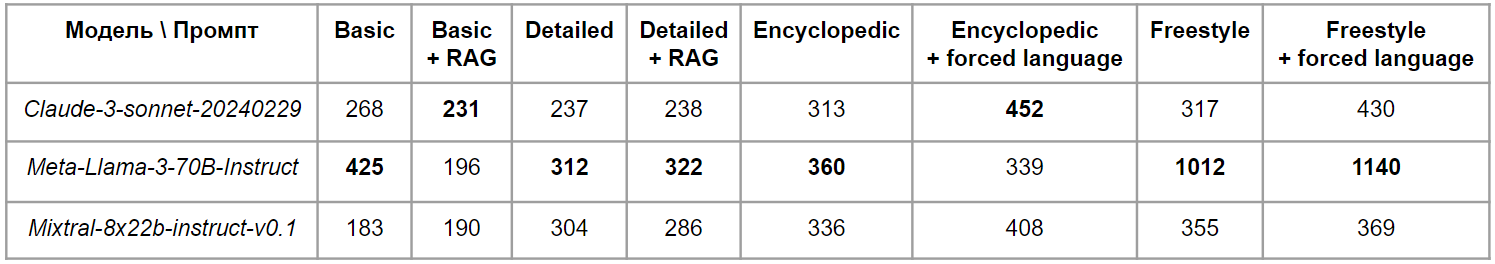

**min_token_count**

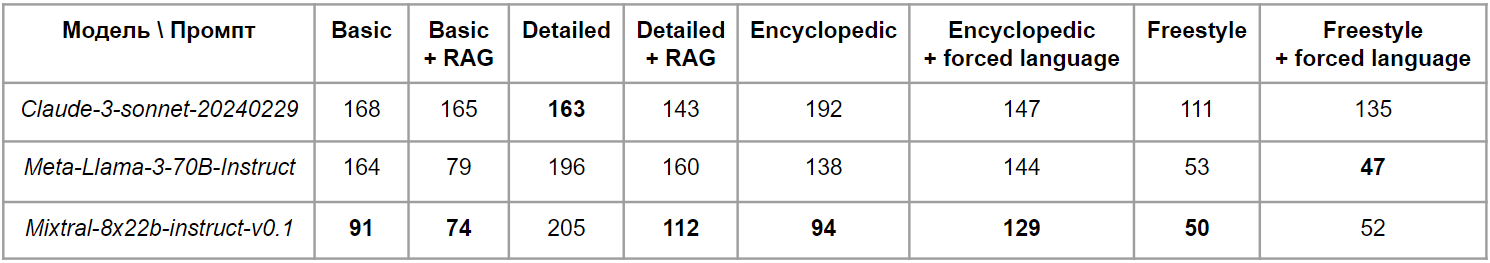

**avg_token_count**

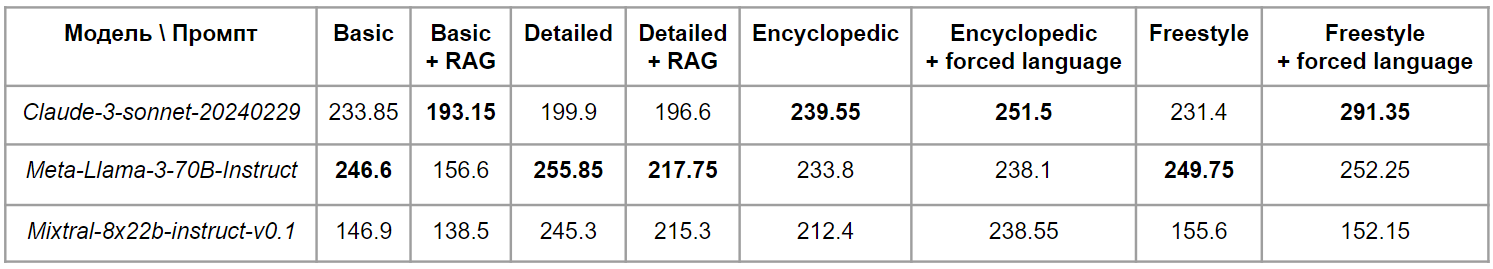

**Выводы:**
1. Mixtral генерирует самые короткие ответы как в среднем, так и в абсолютном случаях, практически во всех видах промптов;
2. Claude и Llama сравнимы между собой по длине ответов в среднем, но Llama порой генерирует очень длинный текст (потому что сервис LMSYS накладывает ограничение на максимальную длину генерируемого текста, и ему подвержены Claude и Mixtral, но не Llama);
3. Использование RAG-контекста сокращает размер генерации, вне зависимости от модели и типа промпта;
4. Детализированный промпт увеличивает ответы у Mixtral и LLama, но не у Claude. Увеличение можно обосновать дополнительным форматированием ответа (например, явным прописыванием заголовков разделов);
5. Freestyle-промпт имеет наибольшую амплитуду размеров генерации вне зависимости от модели (от 47 до 1140 токенов);
6. Требование писать на русском языке увеличивает длину ответов всех моделей.

##### 4.3.2 English Symbols Percentage

Оценим долю латинницы в сгенерированных ответах: 

In [45]:
scores = {}

for method, responses in raw_responses.items():
    max_percentage, avg_percentage, avg_eng_syms = 0, 0, 0

    for response in responses:
        eng_syms = 0
        
        for sym in response:
            if sym >= 'a' and sym <= 'z' or sym >= 'A' and sym <= 'Z':
                eng_syms += 1

        percentage = eng_syms / len(response)
        if percentage > max_percentage:
            max_percentage = percentage
        avg_percentage += percentage
        avg_eng_syms += eng_syms

    avg_percentage /= len(responses)
    avg_eng_syms /= len(responses)
    scores[method] = (round(max_percentage, ndigits=4), round(avg_percentage, ndigits=4), avg_eng_syms)

scores

{'basic_claude': (0.0137, 0.0035, 5.75),
 'basic_llama': (0.8191, 0.0939, 225.35),
 'basic_mixtral': (0.005, 0.0005, 0.55),
 'basic_rag_claude': (0.0177, 0.0064, 8.9),
 'basic_rag_llama': (0.0328, 0.003, 3.35),
 'basic_rag_mixtral': (0.003, 0.0005, 0.45),
 'detailed_claude': (0.0158, 0.0054, 7.7),
 'detailed_llama': (0.038, 0.0104, 16.55),
 'detailed_mixtral': (0.012, 0.0008, 1.3),
 'detailed_rag_claude': (0.0326, 0.0033, 4.55),
 'detailed_rag_llama': (0.0069, 0.001, 1.5),
 'detailed_rag_mixtral': (0.0184, 0.0014, 1.5),
 'encyclopedic_claude': (0.0037, 0.0003, 0.5),
 'encyclopedic_llama': (0.0033, 0.0004, 0.85),
 'encyclopedic_mixtral': (0.0006, 0.0001, 0.2),
 'encyclopedic_forced_lang_claude': (0, 0.0, 0.0),
 'encyclopedic_forced_lang_llama': (0.0024, 0.0002, 0.45),
 'encyclopedic_forced_lang_mixtral': (0.0007, 0.0001, 0.15),
 'freestyle_claude': (0.0018, 0.0001, 0.3),
 'freestyle_llama': (0.002, 0.0002, 0.7),
 'freestyle_mixtral': (0.0016, 0.0002, 0.3),
 'freestyle_forced_lang_claude

Запишем результаты отдельно по каждой метрике.

**max_eng_percentage**

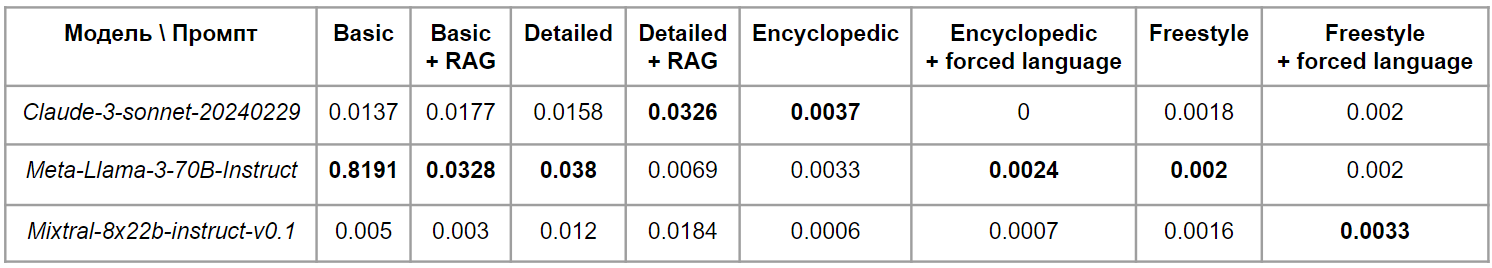

**avg_eng_percentage**

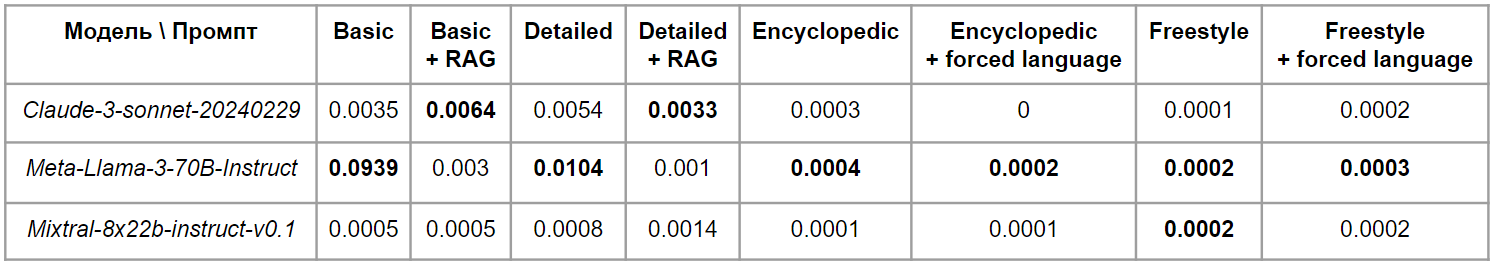

**avg_eng_sym_count**

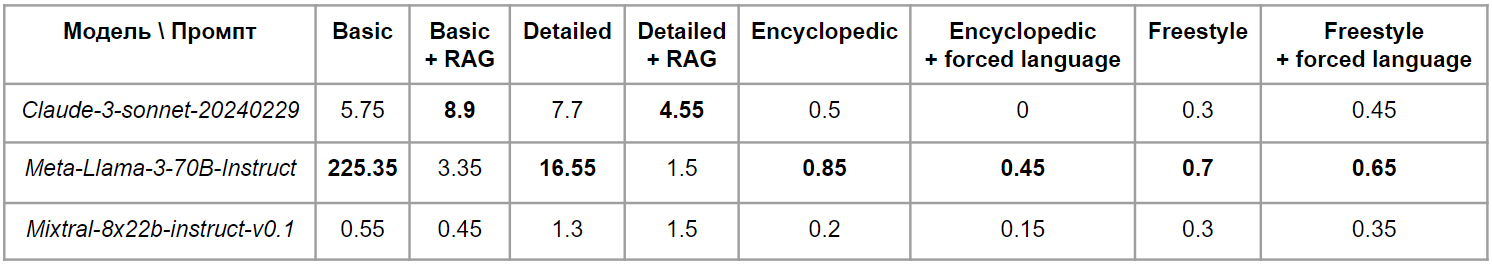

**Выводы:**
1. Больше всего на английском языке пишет Llama - при basic промпте модель может писать вообще весь ответ на английском языке;
2. В среднем, доля латинницы в ответах очень мала - порядка 0.0001;
3. Требование писать на русском языке помогает избавиться от крайних случаев (типа Llama + basic промпт), но полностью латинницу из ответов не вытесняет;
4. Можно заметить, что все модели больше всего пишут на английском в basic и detailed промптах (в basic заметно чаще). Возможно, это происходит потому, что модели без доп. контекста при неуверенности в ответе переходят на свой язык разработки (т.е. английский);
5. RAG помогает избаляться от крайних случаев так же хорошо, как и прямое требование писать на русском - скорее всего, потому что сам контекст на русском языке, то и модель пишет на нем чаще, подстраиваясь под него;
6. Encyclopedic и freestyle промпты генерируют ответы почти исключительно на русском языке, даже без явного на это указания.

##### 4.3.3 ROUGE Precision

Посчитаем ROUGE-точность (-1, -2, -L, -Lsum) между сгенерированными ответами и различными таргет-текстами:

In [46]:
tokenizer = WordPunctTokenizer()
scorer = RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'], split_summaries=True, tokenizer=tokenizer)

In [42]:
approach_to_responses = {}

for approach, responses in normalized_responses.items():
    term_to_response = {}
    
    for i, term in enumerate(terms):
        term_to_response[term] = responses[i]

    approach_to_responses[approach] = term_to_response

###### 4.3.3.1 Wikipedia Articles

In [60]:
scores = {}

for approach, term_to_response in approach_to_responses.items():
    rouge_1, rouge_2, rouge_L, rouge_Lsum = 0, 0, 0, 0

    for term in wiki_terms:
        target = term_to_target_wiki[term]
        prediction = term_to_response[term]

        rouge_scores = scorer.score(target, prediction)

        rouge_1 += rouge_scores['rouge1'].precision
        rouge_2 += rouge_scores['rouge2'].precision
        rouge_L += rouge_scores['rougeL'].precision
        rouge_Lsum += rouge_scores['rougeLsum'].precision

    rouge_1 /= len(wiki_terms)
    rouge_2 /= len(wiki_terms)
    rouge_L /= len(wiki_terms)
    rouge_Lsum /= len(wiki_terms)

    scores[approach] = (
        round(rouge_1, ndigits=4),
        round(rouge_2, ndigits=4),
        round(rouge_L, ndigits=4),
        round(rouge_Lsum, ndigits=4),
    )

scores

{'basic_claude': (0.575, 0.1786, 0.3091, 0.5465),
 'basic_llama': (0.5537, 0.1868, 0.3122, 0.526),
 'basic_mixtral': (0.599, 0.21, 0.3744, 0.5673),
 'basic_rag_claude': (0.6049, 0.2021, 0.3307, 0.5771),
 'basic_rag_llama': (0.5821, 0.2136, 0.3496, 0.555),
 'basic_rag_mixtral': (0.5972, 0.2157, 0.3876, 0.5652),
 'detailed_claude': (0.5808, 0.1742, 0.3074, 0.5533),
 'detailed_llama': (0.507, 0.1679, 0.2867, 0.486),
 'detailed_mixtral': (0.4919, 0.1484, 0.2765, 0.4738),
 'detailed_rag_claude': (0.589, 0.1794, 0.3109, 0.562),
 'detailed_rag_llama': (0.509, 0.1712, 0.2811, 0.4828),
 'detailed_rag_mixtral': (0.5469, 0.1821, 0.3136, 0.5225),
 'encyclopedic_claude': (0.5351, 0.1741, 0.2798, 0.5003),
 'encyclopedic_llama': (0.519, 0.1639, 0.2765, 0.4937),
 'encyclopedic_mixtral': (0.5548, 0.1947, 0.306, 0.5226),
 'encyclopedic_forced_lang_claude': (0.5219, 0.1724, 0.2808, 0.4934),
 'encyclopedic_forced_lang_llama': (0.506, 0.1631, 0.2757, 0.4819),
 'encyclopedic_forced_lang_mixtral': (0.5341, 0

Запишем результаты отдельно по каждой метрике.

**ROUGE-1**

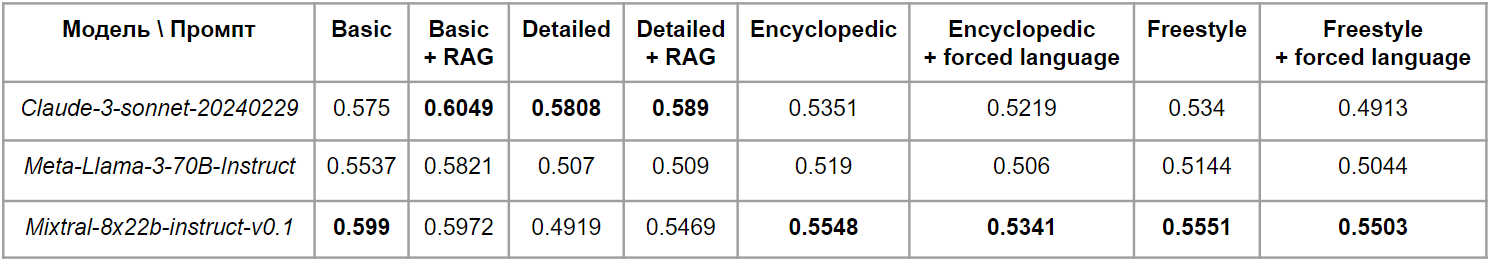

**ROUGE-2**

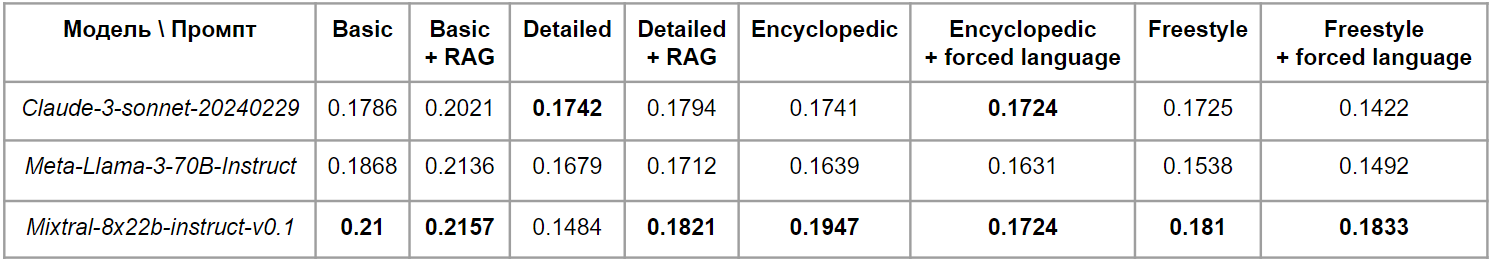

**ROUGE-L**

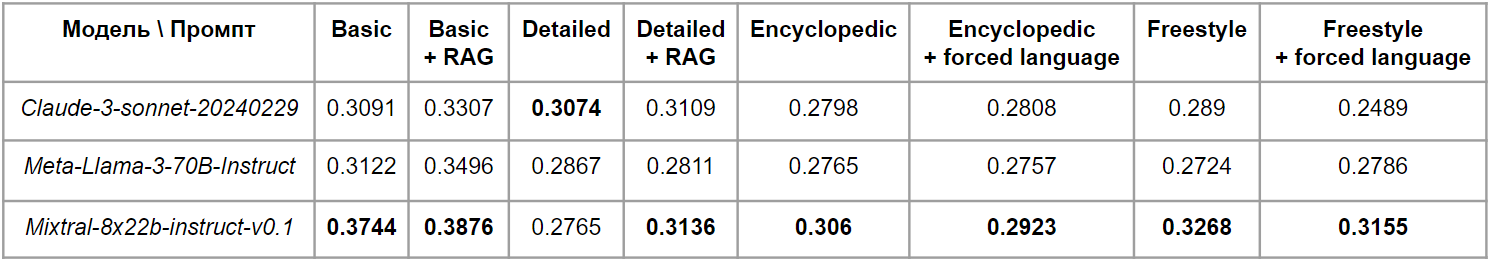

**ROUGE-Lsum**

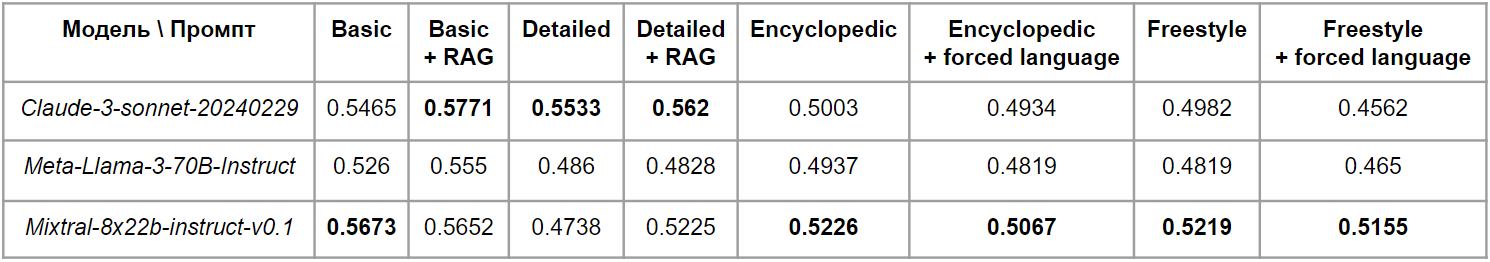

###### 4.3.3.2 Extracted Context

In [61]:
scores = {}

for approach, term_to_response in approach_to_responses.items():
    rouge_1, rouge_2, rouge_L, rouge_Lsum = 0, 0, 0, 0

    for term in terms:
        target = term_to_target_rag[term]
        prediction = term_to_response[term]

        rouge_scores = scorer.score(target, prediction)

        rouge_1 += rouge_scores['rouge1'].precision
        rouge_2 += rouge_scores['rouge2'].precision
        rouge_L += rouge_scores['rougeL'].precision
        rouge_Lsum += rouge_scores['rougeLsum'].precision

    rouge_1 /= len(terms)
    rouge_2 /= len(terms)
    rouge_L /= len(terms)
    rouge_Lsum /= len(terms)

    scores[approach] = (
        round(rouge_1, ndigits=4),
        round(rouge_2, ndigits=4),
        round(rouge_L, ndigits=4),
        round(rouge_Lsum, ndigits=4),
    )

scores

{'basic_claude': (0.3144, 0.0649, 0.1665, 0.2863),
 'basic_llama': (0.2943, 0.0592, 0.1638, 0.2681),
 'basic_mixtral': (0.3847, 0.0787, 0.2283, 0.351),
 'basic_rag_claude': (0.3949, 0.104, 0.1981, 0.3613),
 'basic_rag_llama': (0.6277, 0.3868, 0.4195, 0.5958),
 'basic_rag_mixtral': (0.5493, 0.3097, 0.3716, 0.5137),
 'detailed_claude': (0.378, 0.1048, 0.1986, 0.3469),
 'detailed_llama': (0.2974, 0.0637, 0.1621, 0.2697),
 'detailed_mixtral': (0.2994, 0.0597, 0.1708, 0.274),
 'detailed_rag_claude': (0.4139, 0.1421, 0.2161, 0.3832),
 'detailed_rag_llama': (0.5119, 0.314, 0.31, 0.4829),
 'detailed_rag_mixtral': (0.4518, 0.2345, 0.2753, 0.4229),
 'encyclopedic_claude': (0.524, 0.3393, 0.314, 0.4994),
 'encyclopedic_llama': (0.6755, 0.5593, 0.5103, 0.6593),
 'encyclopedic_mixtral': (0.6802, 0.5516, 0.485, 0.6634),
 'encyclopedic_forced_lang_claude': (0.5581, 0.4141, 0.3577, 0.5395),
 'encyclopedic_forced_lang_llama': (0.6722, 0.561, 0.5085, 0.6585),
 'encyclopedic_forced_lang_mixtral': (0.6052

Запишем результаты отдельно по каждой метрике.

**ROUGE-1**

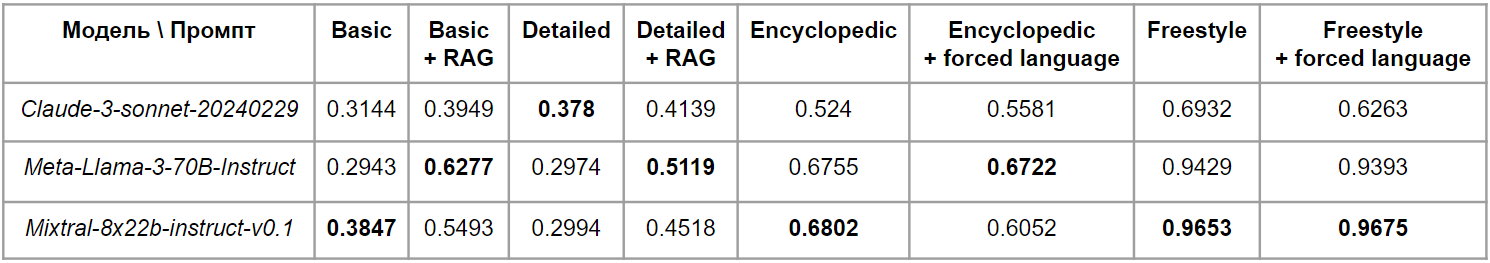

**ROUGE-2**

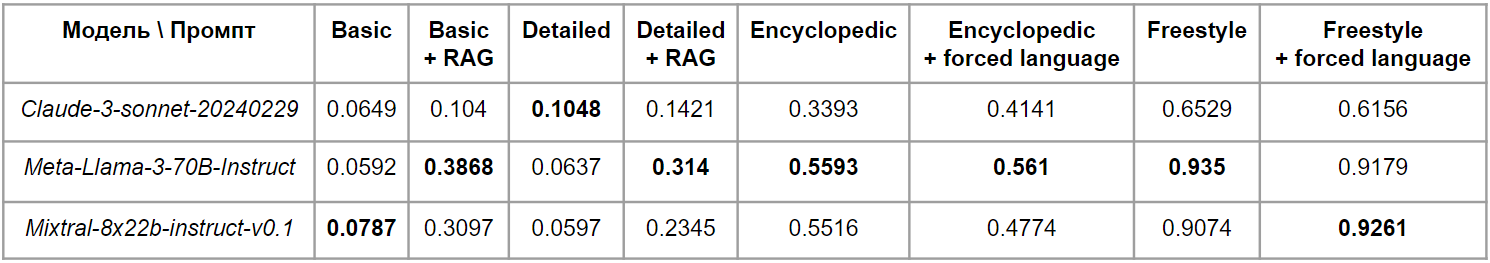

**ROUGE-L**

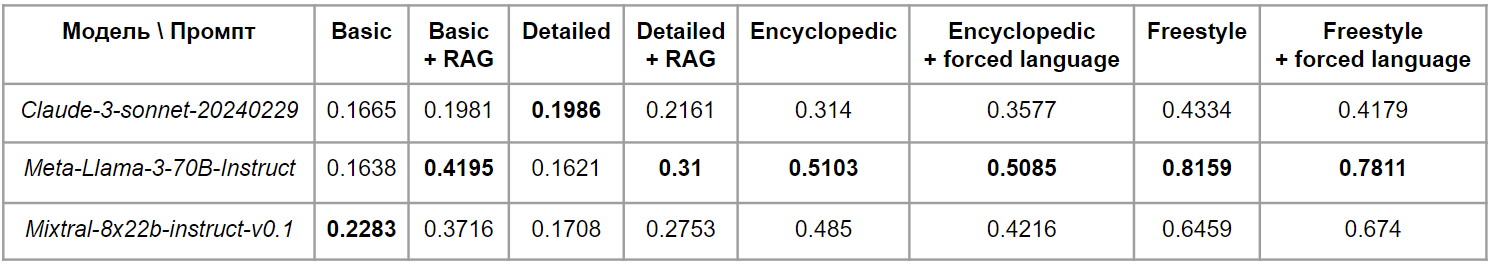

**ROUGE-Lsum**

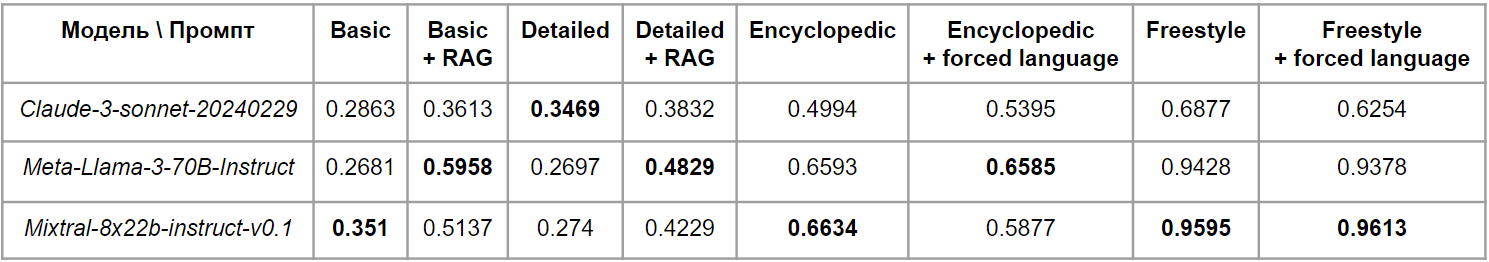

###### 4.3.3.3 Source Documents

In [62]:
scores = {}

for approach, term_to_response in approach_to_responses.items():
    rouge_1, rouge_2, rouge_L, rouge_Lsum = 0, 0, 0, 0

    for term in terms:
        target = term_to_target_source[term]
        prediction = term_to_response[term]

        rouge_scores = scorer.score(target, prediction)

        rouge_1 += rouge_scores['rouge1'].precision
        rouge_2 += rouge_scores['rouge2'].precision
        rouge_L += rouge_scores['rougeL'].precision
        rouge_Lsum += rouge_scores['rougeLsum'].precision

    rouge_1 /= len(terms)
    rouge_2 /= len(terms)
    rouge_L /= len(terms)
    rouge_Lsum /= len(terms)

    scores[approach] = (
        round(rouge_1, ndigits=4),
        round(rouge_2, ndigits=4),
        round(rouge_L, ndigits=4),
        round(rouge_Lsum, ndigits=4),
    )

scores

{'basic_claude': (0.9492, 0.6162, 0.7783, 0.943),
 'basic_llama': (0.8654, 0.517, 0.7227, 0.8584),
 'basic_mixtral': (0.9658, 0.6448, 0.8518, 0.9621),
 'basic_rag_claude': (0.973, 0.6795, 0.8261, 0.9676),
 'basic_rag_llama': (0.9831, 0.7864, 0.8632, 0.9801),
 'basic_rag_mixtral': (0.992, 0.7653, 0.8814, 0.9886),
 'detailed_claude': (0.9682, 0.6569, 0.8157, 0.9638),
 'detailed_llama': (0.9488, 0.5466, 0.7648, 0.9429),
 'detailed_mixtral': (0.9701, 0.6274, 0.8163, 0.9675),
 'detailed_rag_claude': (0.9744, 0.6615, 0.8177, 0.9712),
 'detailed_rag_llama': (0.9847, 0.717, 0.8248, 0.9821),
 'detailed_rag_mixtral': (0.979, 0.6989, 0.835, 0.9761),
 'encyclopedic_claude': (0.9911, 0.7821, 0.8243, 0.9869),
 'encyclopedic_llama': (0.9936, 0.8639, 0.8438, 0.9922),
 'encyclopedic_mixtral': (0.9929, 0.8378, 0.8558, 0.9909),
 'encyclopedic_forced_lang_claude': (0.9838, 0.7857, 0.8184, 0.9813),
 'encyclopedic_forced_lang_llama': (0.996, 0.8628, 0.8404, 0.9943),
 'encyclopedic_forced_lang_mixtral': (0.9

Запишем результаты отдельно по каждой метрике.

**ROUGE-1**

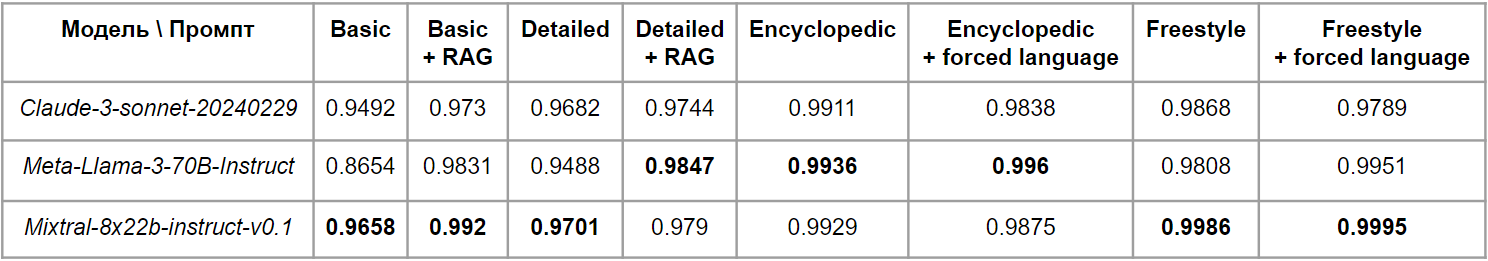

**ROUGE-2**

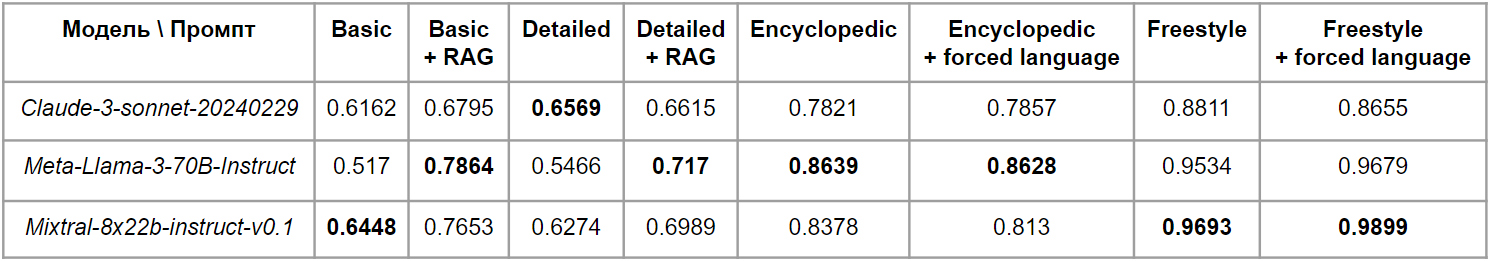

**ROUGE-L**

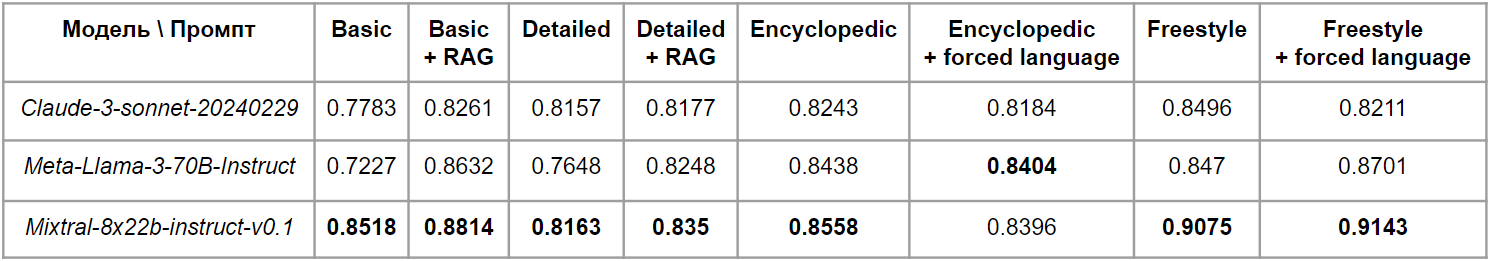

**ROUGE-Lsum**

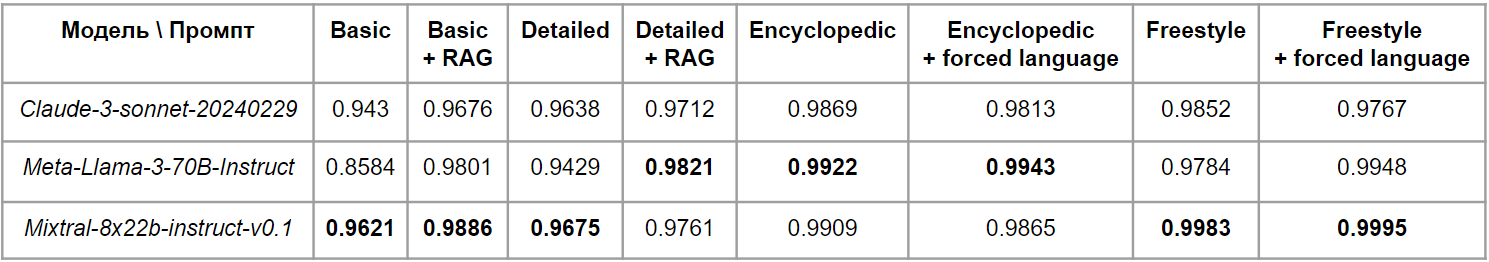

**Выводы:**
1. Лучшие показатели ROUGE при оценке на вики-статьях имеет mixtral - в среднем 55 % сгенерированных токенов присутствуют в таргет-статьях. Однако такого рез-та mixtral достичь проще остальных моделей - она генерирует самые короткие ответы;
2. Использование RAG-контекста увеличивает значения ROUGE вне зависимости от модели, незначительно при оценке на вики-статьях и очень заметно на исходных публикациях и на самом контексте;
3. Детализированный промпт при оценке на вики-статьях проявил себя хуже базового - есть предположение, что стандартные шаблоны генерации в моделях в достаточной мере похожи на формат википедии. Однако при оценке на исходных публикациях, наоборот, детализированный промпт лучше;
4. Почти все сгенерированные слова и больше половины биграмм встречаются в исходных документах;
5. Freestyle-промпт имеет наивысшие показатели ROUGE (почти 100% пересечений слов и их пар) при оценке на RAG-контексте и исходных документах. Это объясняется тем, что модель по факту собирает рассказ из предложений RAG-контекста, при этом просто переупордочивая их и почти не добавляя новых токенов;
6. Claude - наиболее консервативная модель, она заметно меньше использует предложенный контекст при генерации ответа. Может быть, на это влияет ее "закрытость" (Llama и Mixtral - opensource модели);
7. Энциклопедический промпт не делает ответы моделей более похожими на вики-статьи по сравнению с базовым, однако заметно чаще задействует контекст. Интересно отметить, ответы по энциклопедическому промпту имеют одни из наивысших показателей ROUGE при оценке на исходных публикациях;
8. Требование о языке не имеет существенного влияния на ROUGE-оценки (кроме как в базовом промпте, т.к. там ответы могут генерироваться полностью на английском), но при оценке на вики-статьях приводит к малому уменьшению метрик.

##### 4.3.4 BLEU

Посчитаем BLEU-4 (до 4-грамм включительно, без brevity penalty) между сгенерированными ответами и различными таргет-текстами:

In [51]:
tokenizer = WordPunctTokenizer()

In [57]:
def bleu_penaltiless(candidate, references, weights=(0.25, 0.25, 0.25, 0.25)):
    """Calculates BLEU score without Brevity Penalty."""
    
    p_ns = (
        modified_precision(candidate, references, i)
        for i, _ in enumerate(weights, start=1)
    )

    try:
        s = math.fsum(w * math.log(p_n) for w, p_n in zip(weights, p_ns))
    except ValueError:
        # some p_ns is 0
        return 0

    return math.exp(s)

###### 4.3.4.1 Wikipedia Articles

In [67]:
scores = {}

for approach, term_to_response in approach_to_responses.items():
    bleu_avg = 0

    for term in wiki_terms:
        target = tokenizer.tokenize(term_to_target_wiki[term])
        prediction = tokenizer.tokenize(term_to_response[term])

        bleu = bleu_penaltiless([target], prediction, weights=(0.25, 0.25, 0.25, 0.25))
        bleu_avg += bleu

    bleu_avg /= len(wiki_terms)

    scores[approach] = round(bleu_avg, ndigits=4)

scores

{'basic_claude': 0.075,
 'basic_llama': 0.0945,
 'basic_mixtral': 0.0991,
 'basic_rag_claude': 0.0929,
 'basic_rag_llama': 0.0959,
 'basic_rag_mixtral': 0.1038,
 'detailed_claude': 0.066,
 'detailed_llama': 0.074,
 'detailed_mixtral': 0.0508,
 'detailed_rag_claude': 0.0751,
 'detailed_rag_llama': 0.0833,
 'detailed_rag_mixtral': 0.0691,
 'encyclopedic_claude': 0.0761,
 'encyclopedic_llama': 0.0637,
 'encyclopedic_mixtral': 0.0863,
 'encyclopedic_forced_lang_claude': 0.0719,
 'encyclopedic_forced_lang_llama': 0.0635,
 'encyclopedic_forced_lang_mixtral': 0.0722,
 'freestyle_claude': 0.064,
 'freestyle_llama': 0.0417,
 'freestyle_mixtral': 0.0464,
 'freestyle_forced_lang_claude': 0.0548,
 'freestyle_forced_lang_llama': 0.0367,
 'freestyle_forced_lang_mixtral': 0.0604}

Запишем результаты в таблицу:

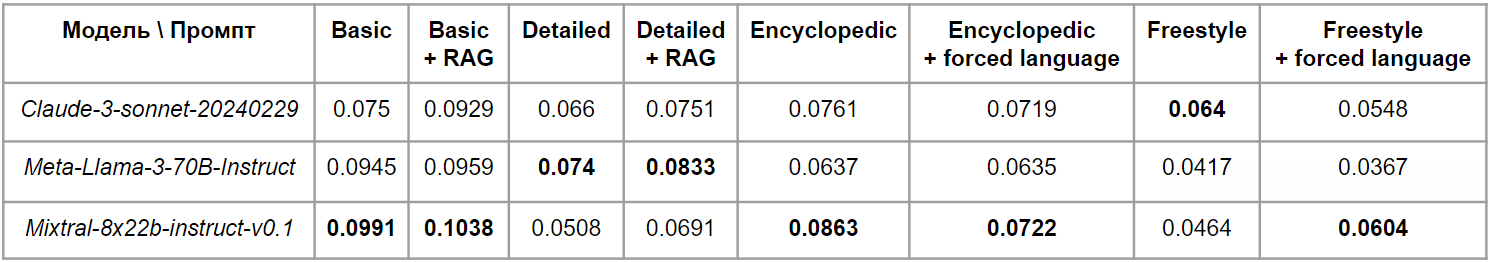

###### 4.3.4.2 Extracted Context

In [66]:
scores = {}

for approach, term_to_response in approach_to_responses.items():
    bleu_avg = 0

    for term in terms:
        target = tokenizer.tokenize(term_to_target_rag[term])
        prediction = tokenizer.tokenize(term_to_response[term])

        bleu = bleu_penaltiless([target], prediction, weights=(0.25, 0.25, 0.25, 0.25))
        bleu_avg += bleu

    bleu_avg /= len(terms)

    scores[approach] = round(bleu_avg, ndigits=4)

scores

{'basic_claude': 0.0157,
 'basic_llama': 0.0087,
 'basic_mixtral': 0.0223,
 'basic_rag_claude': 0.0445,
 'basic_rag_llama': 0.3452,
 'basic_rag_mixtral': 0.2634,
 'detailed_claude': 0.0608,
 'detailed_llama': 0.0139,
 'detailed_mixtral': 0.014,
 'detailed_rag_claude': 0.0914,
 'detailed_rag_llama': 0.2789,
 'detailed_rag_mixtral': 0.1975,
 'encyclopedic_claude': 0.2915,
 'encyclopedic_llama': 0.5302,
 'encyclopedic_mixtral': 0.5278,
 'encyclopedic_forced_lang_claude': 0.3707,
 'encyclopedic_forced_lang_llama': 0.5358,
 'encyclopedic_forced_lang_mixtral': 0.4493,
 'freestyle_claude': 0.6318,
 'freestyle_llama': 0.9247,
 'freestyle_mixtral': 0.8873,
 'freestyle_forced_lang_claude': 0.5977,
 'freestyle_forced_lang_llama': 0.9058,
 'freestyle_forced_lang_mixtral': 0.9061}

Запишем результаты в таблицу:

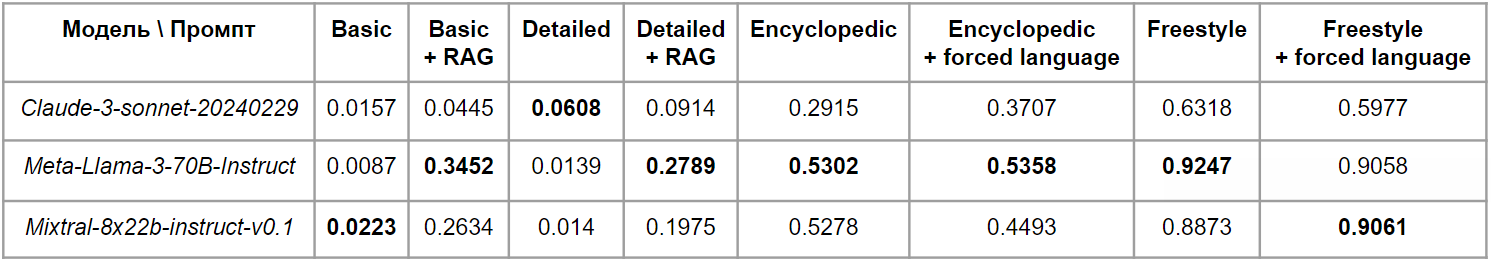

###### 4.3.4.3 Source Documents

In [68]:
scores = {}

for approach, term_to_response in approach_to_responses.items():
    bleu_avg = 0

    for term in terms:
        target = tokenizer.tokenize(term_to_target_source[term])
        prediction = tokenizer.tokenize(term_to_response[term])

        bleu = bleu_penaltiless([target], prediction, weights=(0.25, 0.25, 0.25, 0.25))
        bleu_avg += bleu

    bleu_avg /= len(terms)

    scores[approach] = round(bleu_avg, ndigits=4)

scores

{'basic_claude': 0.2677,
 'basic_llama': 0.2389,
 'basic_mixtral': 0.2906,
 'basic_rag_claude': 0.3228,
 'basic_rag_llama': 0.5594,
 'basic_rag_mixtral': 0.4933,
 'detailed_claude': 0.3152,
 'detailed_llama': 0.2219,
 'detailed_mixtral': 0.2673,
 'detailed_rag_claude': 0.3414,
 'detailed_rag_llama': 0.4962,
 'detailed_rag_mixtral': 0.4136,
 'encyclopedic_claude': 0.539,
 'encyclopedic_llama': 0.7144,
 'encyclopedic_mixtral': 0.6912,
 'encyclopedic_forced_lang_claude': 0.5932,
 'encyclopedic_forced_lang_llama': 0.7165,
 'encyclopedic_forced_lang_mixtral': 0.6409,
 'freestyle_claude': 0.7874,
 'freestyle_llama': 0.9305,
 'freestyle_mixtral': 0.9192,
 'freestyle_forced_lang_claude': 0.7702,
 'freestyle_forced_lang_llama': 0.9282,
 'freestyle_forced_lang_mixtral': 0.9402}

Запишем результаты в таблицу:

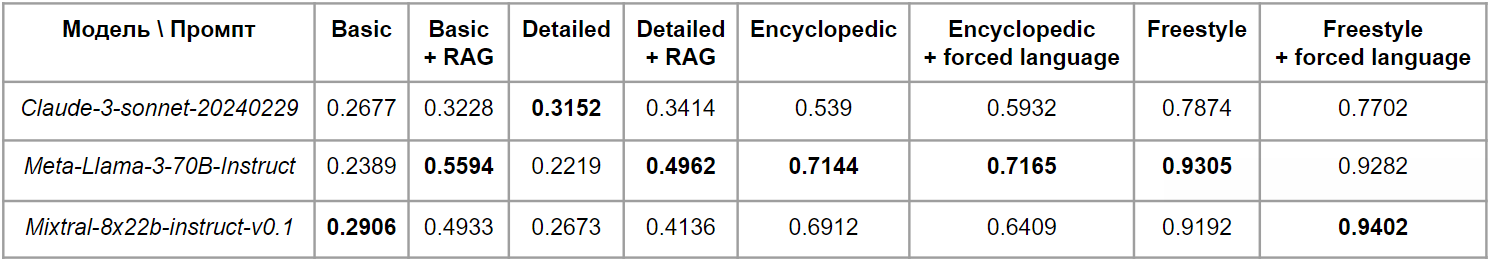

**Выводы:**
1. В целом, наилучшие показатели BLEU показывает Llama (при оценке на контексте и исходных публикациях);
2. Низкий BLEU при оценке на вики-статьях показывает, что сходство между сгенерированными и целевыми текстами наблюдается максимум на уровне отдельных слов или их пар (3- и 4-граммы пересекаются очень редко);
3. Столь высокие показатели freestyle-промпта (у Llama и Mixtral) при оценке на контексте и исходных публикациях еще раз подчеркивают, что этот тип промпта добавляет очень мало новых токенов при генерации (>90% - это RAG-предложения);
4. Лучшие типы промптов согласно BLEU:
    1. вики-статьи - базовый + RAG, энциклопедический;
    2. RAG-контекст и исходные документы - freestyle и энциклопедический;

##### 4.3.5 METEOR

Посчитаем METEOR (с упором на precision-часть, а recall-часть оставим маленькой как сглаживающий фактор) между сгенерированными ответами и различными таргет-текстами:

In [72]:
meteor = evaluate.load('meteor')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


###### 4.3.5.1 Wikipedia Articles

In [75]:
scores = {}

for approach, term_to_response in approach_to_responses.items():
    targets, predictions = [], []

    for term in wiki_terms:
        targets.append(term_to_target_wiki[term])
        predictions.append(term_to_response[term])

    score = meteor.compute(predictions=predictions, references=targets, alpha=0.01)

    scores[approach] = round(score['meteor'], ndigits=4)

scores

{'basic_claude': 0.2812,
 'basic_llama': 0.2805,
 'basic_mixtral': 0.2986,
 'basic_rag_claude': 0.2942,
 'basic_rag_llama': 0.2882,
 'basic_rag_mixtral': 0.282,
 'detailed_claude': 0.2833,
 'detailed_llama': 0.2566,
 'detailed_mixtral': 0.2479,
 'detailed_rag_claude': 0.2889,
 'detailed_rag_llama': 0.2542,
 'detailed_rag_mixtral': 0.2716,
 'encyclopedic_claude': 0.2697,
 'encyclopedic_llama': 0.2571,
 'encyclopedic_mixtral': 0.2748,
 'encyclopedic_forced_lang_claude': 0.2573,
 'encyclopedic_forced_lang_llama': 0.2505,
 'encyclopedic_forced_lang_mixtral': 0.2768,
 'freestyle_claude': 0.2733,
 'freestyle_llama': 0.2625,
 'freestyle_mixtral': 0.2738,
 'freestyle_forced_lang_claude': 0.2406,
 'freestyle_forced_lang_llama': 0.2624,
 'freestyle_forced_lang_mixtral': 0.2684}

Запишем результаты в таблицу:

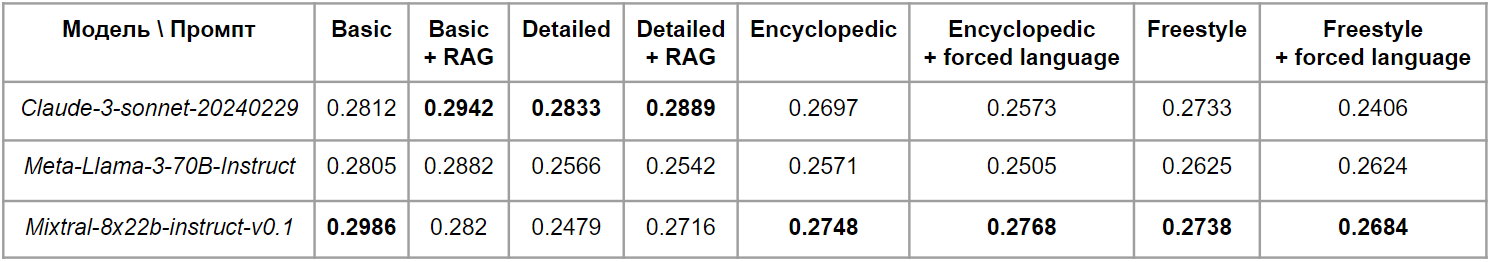

###### 4.3.5.2 Extracted Context

In [76]:
scores = {}

for approach, term_to_response in approach_to_responses.items():
    targets, predictions = [], []

    for term in terms:
        targets.append(term_to_target_rag[term])
        predictions.append(term_to_response[term])

    score = meteor.compute(predictions=predictions, references=targets, alpha=0.01)

    scores[approach] = round(score['meteor'], ndigits=4)

scores

{'basic_claude': 0.1753,
 'basic_llama': 0.1638,
 'basic_mixtral': 0.219,
 'basic_rag_claude': 0.2303,
 'basic_rag_llama': 0.4861,
 'basic_rag_mixtral': 0.3988,
 'detailed_claude': 0.2357,
 'detailed_llama': 0.1629,
 'detailed_mixtral': 0.1653,
 'detailed_rag_claude': 0.2685,
 'detailed_rag_llama': 0.3938,
 'detailed_rag_mixtral': 0.3162,
 'encyclopedic_claude': 0.3898,
 'encyclopedic_llama': 0.5824,
 'encyclopedic_mixtral': 0.572,
 'encyclopedic_forced_lang_claude': 0.4371,
 'encyclopedic_forced_lang_llama': 0.5734,
 'encyclopedic_forced_lang_mixtral': 0.502,
 'freestyle_claude': 0.5747,
 'freestyle_llama': 0.9178,
 'freestyle_mixtral': 0.8705,
 'freestyle_forced_lang_claude': 0.5426,
 'freestyle_forced_lang_llama': 0.9109,
 'freestyle_forced_lang_mixtral': 0.8768}

Запишем результаты в таблицу:

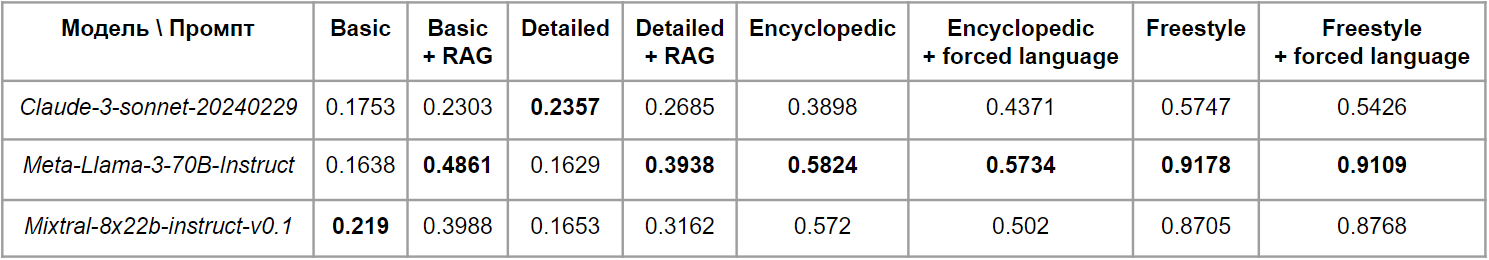

###### 4.3.5.3 Source Documents

In [77]:
scores = {}

for approach, term_to_response in approach_to_responses.items():
    targets, predictions = [], []

    for term in terms:
        targets.append(term_to_target_source[term])
        predictions.append(term_to_response[term])

    score = meteor.compute(predictions=predictions, references=targets, alpha=0.01)

    scores[approach] = round(score['meteor'], ndigits=4)

scores

{'basic_claude': 0.0922,
 'basic_llama': 0.0816,
 'basic_mixtral': 0.0647,
 'basic_rag_claude': 0.0805,
 'basic_rag_llama': 0.0699,
 'basic_rag_mixtral': 0.0658,
 'detailed_claude': 0.0822,
 'detailed_llama': 0.0969,
 'detailed_mixtral': 0.0972,
 'detailed_rag_claude': 0.0815,
 'detailed_rag_llama': 0.093,
 'detailed_rag_mixtral': 0.0899,
 'encyclopedic_claude': 0.0993,
 'encyclopedic_llama': 0.0958,
 'encyclopedic_mixtral': 0.0873,
 'encyclopedic_forced_lang_claude': 0.0998,
 'encyclopedic_forced_lang_llama': 0.097,
 'encyclopedic_forced_lang_mixtral': 0.0943,
 'freestyle_claude': 0.0926,
 'freestyle_llama': 0.0834,
 'freestyle_mixtral': 0.0624,
 'freestyle_forced_lang_claude': 0.1082,
 'freestyle_forced_lang_llama': 0.0833,
 'freestyle_forced_lang_mixtral': 0.069}

Запишем результаты в таблицу:

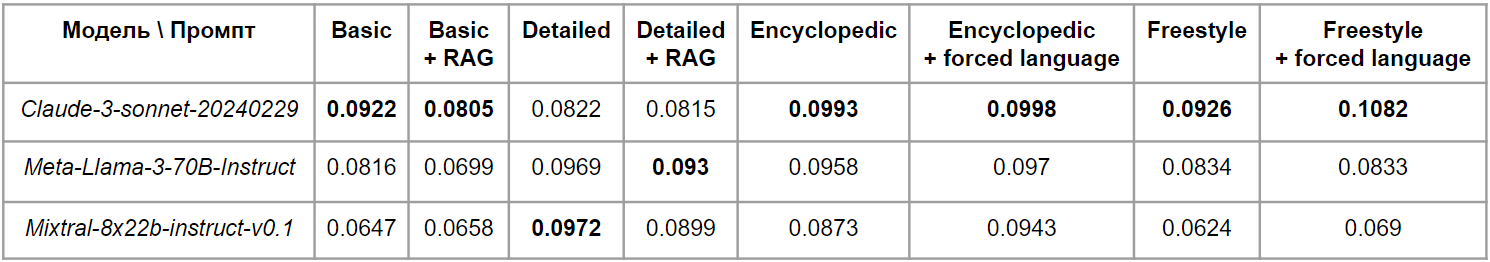

**Выводы:**
1. Даже несмотря на явно заданный приоритет точности, METEOR остается по факту модифицированной ROUGE-1 f-мерой, что не очень подходит для нашей задачи (для нас recall не дает значимой информации, а лишь необоснованно занижает метрики);
2. Тем не менее, у METEOR есть и полезное свойство - он штрафует сгенерированные тексты, если пересечения с целевыми текстами наблюдаются лишь в некоторых разрозненных, небольших фрагментах (чем больше размер таких совпадающих фрагментов и ,соответственно, меньше число самих фрагментов, тем меньше штраф). Таким образом, METEOR позволяет оценивать и грамматическую связность генерации;
3. Относительно низкие показатели METEOR при оценке на вики-статьях в совокупности с оценками BLEU говорят, что сгенерированные тексты в целом мало похожи на свои вики-аналоги - отдельные слова и сочетания слов есть и там, и там, но точно почти нет совпадений на уровне целых абзацев или хотя бы предложений. Т.е. модели не пытаются явно копировать википедию при ответе на запросы;
4. Высокие показатели энциклопедического и freestyle-промптов при оценке на RAG демонстрируют, что модели используют не отдельные слова из предоставленного контекста, а существенную его часть (так, Llama в freestyle-промпте довольно часто составляет рассказ на основе ВСЕХ предложений из RAG-контекста);
5. Оценки по исходным документам малоинформативны в случае METEOR - recall даже с очень маленьким весом зануляет оценки из-за огромного размера таргет-текстов.

##### 4.3.6 Combining Results

Для лучшей видимости результатов объединим все промпты и метрики в 3 исчерпывающие таблицы (wiki, RAG, source):

###### 4.3.6.1 Wikipedia Articles

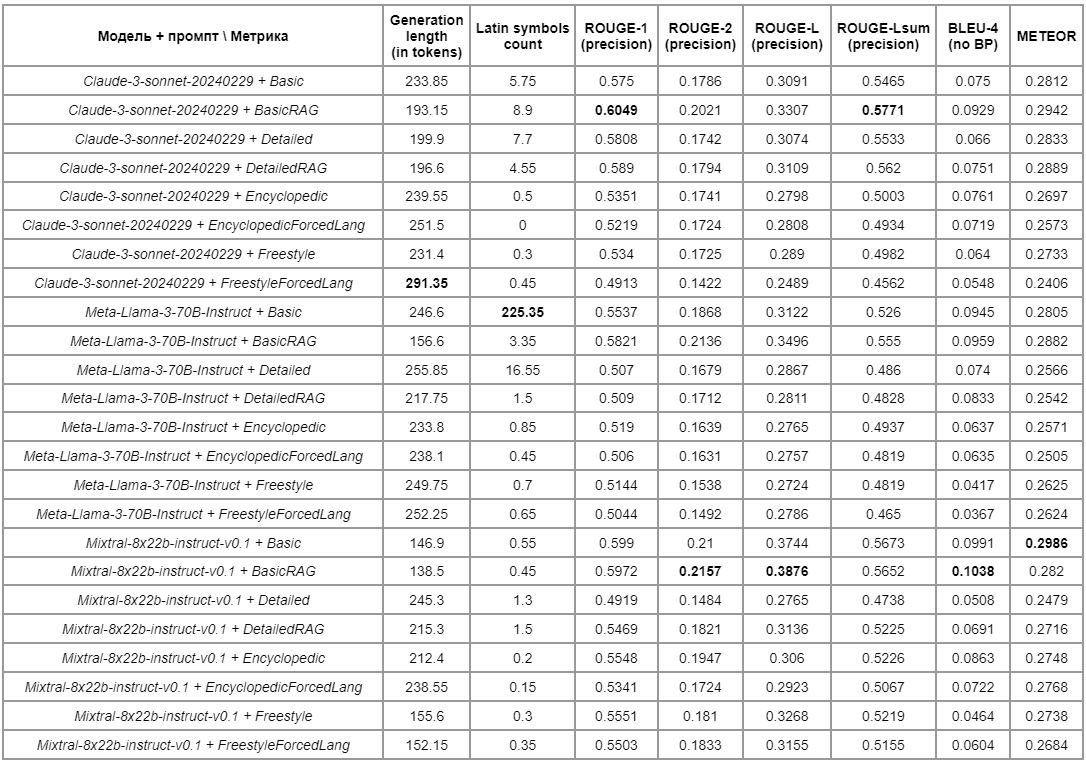

###### 4.3.6.2 RAG-context

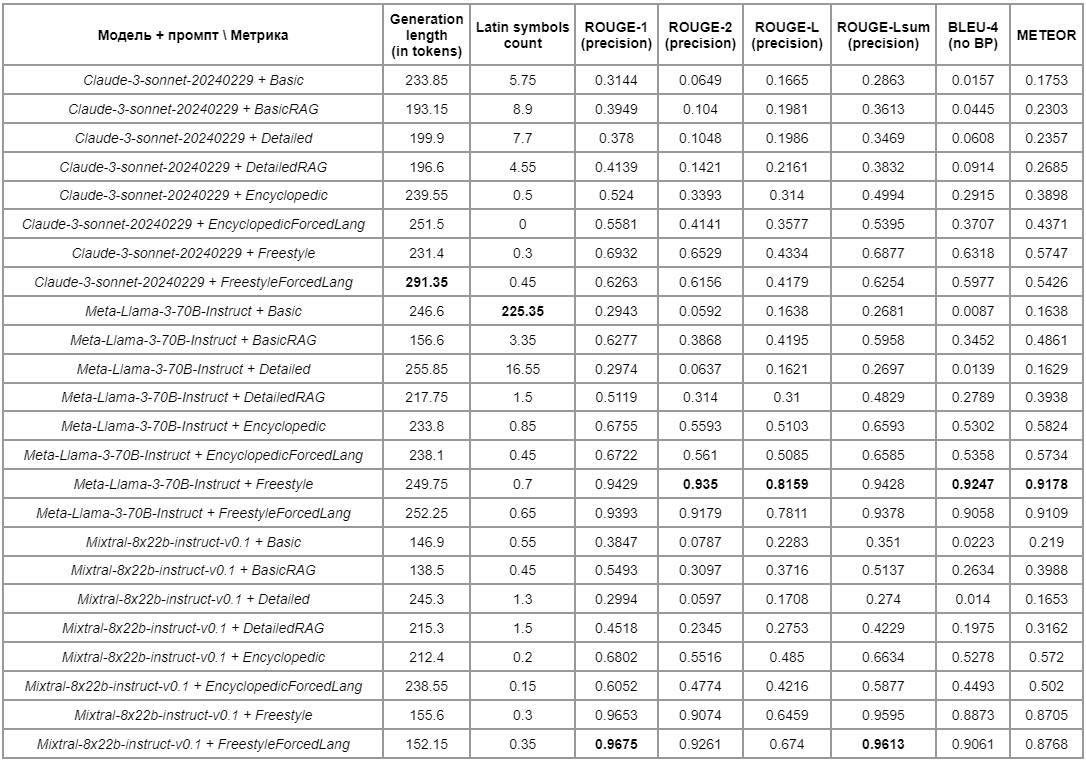

###### 4.3.6.3 Source Documents

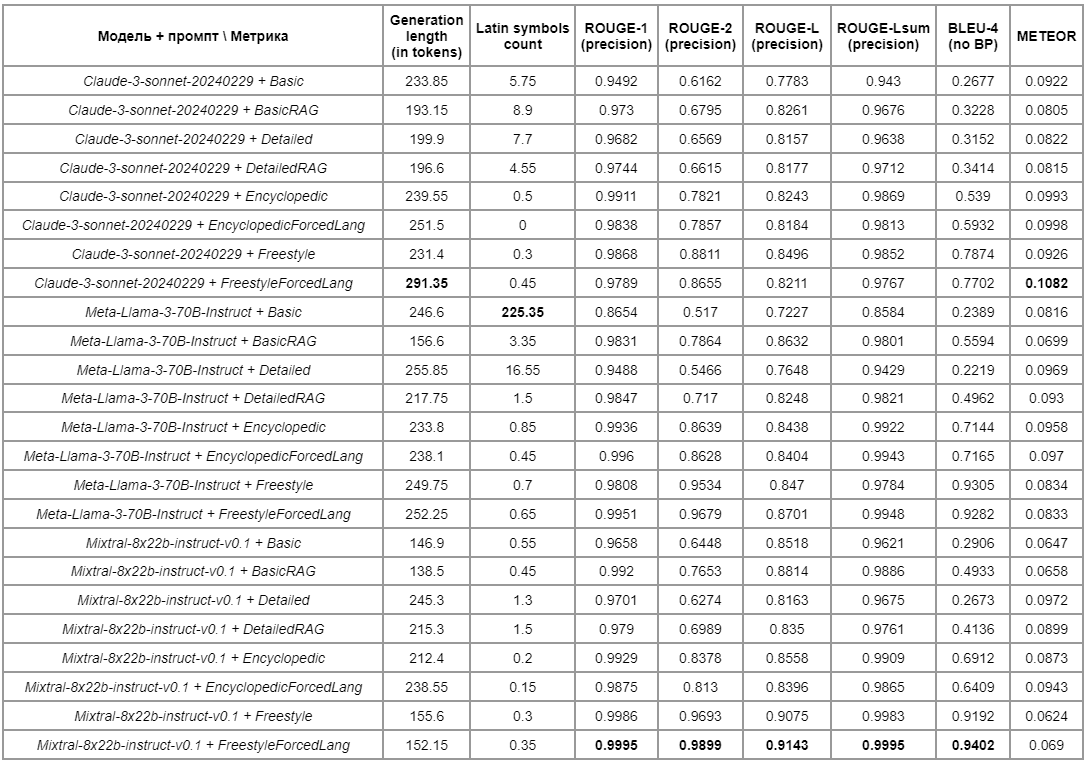

С точки зрения автоматических метрик, обещающими выглядят следующие варианты генерации:
- Claude-3-sonnet-20240229 + BasicRAG;
- Mixtral-8x22b-instruct-v0.1 + BasicRAG;
- Meta-Llama-3-70B-Instruct + Freestyle;
- Mixtral-8x22b-instruct-v0.1 + FreestyleForcedLang.

Проверим их качество на примере термина **"внутренние волны"**. Выведем для сравнения RAG-контекст:

1. Это соответствует тому, что в термоклине возбуждаются внутренние волны со сравнительно узким спектром, а колебания в струе определяются турбулентными флуктуациями скорости течения.
2. При этом будем традиционно считать, что в основном эти флуктуации и в мелком море, и в малоразмерном водоёме обусловлены внутренними волнами.
3. При этом мы будем традиционно полагать, что основными источниками флуктуаций акустического поля (и в мелком море, и в малоразмерном водоёме) являются ветровое волнение и внутренние волны.
4. Известно, что интенсивные внутренние волны (ВВ) вызывают значительные возмущения низкочастотного звукового поля.
5. Здесь естественным путём образуется звуковой канал, имеется естественный донный грунт, ветровое волнение и внутренние волны.
6. Тем не менее, удаётся связать статистические характеристики флуктуаций акустического поля в мелком море и в малоразмерном водоёме при условии, что доминирует низшая мода внутренних волн.
7. Темные и светлые полосы здесь визуализируют фазовые поверхности внутренних волн, на их границах располагаются гребни и впадины.
8. Сложнее обстоит дело с внутренними волнами.
9. К их числу относятся внутренние волны, пограничные слои, внутренние пограничные течения и течения, индуцированные диффузией на неровностях рельефа даже в покоящейся жидкости.
10. Эти высоты соответствуют уровням обрушения внутренних волн в атмосфере.
11. Строгое разделение волн на внешние и внутренние возможно, если парциальные спектры волн в ФС не перекрываются и взаимодействия между внешними и внутренними волнами нет.
12. В этом разделе приведены основные уравнения для описания звукового поля, указаны параметры невозмущенного профиля скорости звука, мезомасштабной неоднородности и поля внутренних волн.
13. Вертикальные колебания в данном случае моделируют так называемую тонкую структуру поля внутренних волн.
14. Если эти спектры перекрываются и внешние и внутренние волны взаимодействуют, то образуются гибридные "внешне-внутренние" и "внутренневнешние" волны.
15. Такое течение на передней кромке вторгается во внешний поток с наложенными внутренними волнами.

**<u>Claude-3-sonnet-20240229 + BasicRAG</u>**

Внутренние волны - это волновые движения, возникающие на границе раздела двух несмешивающихся сред с различной плотностью внутри одной среды, например, в океане или атмосфере.

Основные особенности внутренних волн:

1. Возникают на границах раздела с различной плотностью (термоклинах, пикнопаузах) из-за действия архимедовой силы плавучести.

2. В океане внутренние волны образуются на термоклине - резком изменении температуры (и плотности) с глубиной.

3. В атмосфере причиной внутренних волн являются изменения плотности из-за температурных инверсий.

4. Имеют гораздо меньшие периоды и длины волн по сравнению с поверхностными волнами.

5. Характеризуются колебаниями границ раздела плотности и изменениями горизонтальной скорости среды по глубине/высоте.

6. Могут достигать большой амплитуды и вызывать сильные возмущения в средах.

7. Играют важную роль в перемешивании и переносе тепла, энергии, импульса в океане и атмосфере.

Внутренние волны широко распространены в океанах и атмосфере. Они возбуждаются различными источниками - приливами, ветром, рельефом дна, стратификацией и др. Изучение внутренних волн важно для понимания динамики океана и атмосферы, акустики, распространения примесей и многих других процессов.

**<u>Mixtral-8x22b-instruct-v0.1 + BasicRAG</u>**

Внутренние волны - это явление, которое приводит к возмущениям низкочастотного звукового поля в жидкостях. Это явление связано с колебаниями границы между слоями с разной плотностью, которые могут возникать в результате температурных или концентрационных градиентов. Внутренние волны могут вызывать значительные возмущения в низкочастотном звуковом поле и могут быть одним из основных источников флуктуаций акустического поля в мелком море и в малоразмерном водоёме. Внутренние волны могут быть связаны с ветровым волнением и могут быть моделированы с помощью вертикальных колебаний. В случае, если спектры внешних и внутренних волн перекрываются и взаимодействуют, могут образовываться гибридные волны.

**<u>Meta-Llama-3-70B-Instruct + Freestyle</u>**

Вот собранный связный текст из заданных предложений:

В термоклине возбуждаются внутренние волны со сравнительно узким спектром, а колебания в струе определяются турбулентными флуктуациями скорости течения. При этом будем традиционно считать, что в основном эти флуктуации и в мелком море, и в малоразмерном водоёме обусловлены внутренними волнами.

При этом мы будем традиционно полагать, что основными источниками флуктуаций акустического поля (и в мелком море, и в малоразмерном водоёме) являются ветровое волнение и внутренние волны. Известно, что интенсивные внутренние волны (ВВ) вызывают значительные возмущения низкочастотного звукового поля.

Здесь естественным путём образуется звуковой канал, имеется естественный донный грунт, ветровое волнение и внутренние волны. Тем не менее, удаётся связать статистические характеристики флуктуаций акустического поля в мелком море и в малоразмерном водоёме при условии, что доминирует низшая мода внутренних волн.

Темные и светлые полосы здесь визуализируют фазовые поверхности внутренних волн, на их границах располагаются гребни и впадины. Сложнее обстоит дело с внутренними волнами. К их числу относятся внутренние волны, пограничные слои, внутренние пограничные течения и течения, индуцированные диффузией на неровностях рельефа даже в покоящейся жидкости.

Эти высоты соответствуют уровням обрушения внутренних волн в атмосфере. Строгое разделение волн на внешние и внутренние возможно, если парциальные спектры волн в ФС не перекрываются и взаимодействия между внешними и внутренними волнами нет.

В этом разделе приведены основные уравнения для описания звукового поля, указаны параметры невозмущенного профиля скорости звука, мезомасштабной неоднородности и поля внутренних волн. Вертикальные колебания в данном случае моделируют так называемую тонкую структуру поля внутренних волн.

Если эти спектры перекрываются и внешние и внутренние волны взаимодействуют, то образуются гибридные "внешне-внутренние" и "внутренневнешние" волны. Такое течение на передней кромке вторгается во внешний поток с наложенными внутренними волнами.

**<u>Mixtral-8x22b-instruct-v0.1 + FreestyleForcedLang</u>**

Мы будем традиционно полагать, что основными источниками флуктуаций акустического поля в мелком море и в малоразмерном водоёме являются ветровое волнение и внутренние волны. Известно, что интенсивные внутренние волны вызывают значительные возмущения низкочастотного звукового поля. Тем не менее, удаётся связать статистические характеристики флуктуаций акустического поля в мелком море и в малоразмерном водоёме при условии, что доминирует низшая мода внутренних волн. К их числу относятся внутренние волны, пограничные слои, внутренние пограничные течения и течения, индуцированные диффузией на неровностях рельефа даже в покоящейся жидкости. Вертикальные колебания в данном случае моделируют так называемую тонкую структуру поля внутренних волн. Строгое разделение волн на внешние и внутренние возможно, если парциальные спектры волн в ФС не перекрываются и взаимодействия между внешними и внутренними волнами нет. Если эти спектры перекрываются и внешние и внутренние волны взаимодействуют, то образуются гибридные "внешне-внутренние" и "внутренне-внешние" волны.

**Выводы:**

1. Claude пишет связно и достаточно правдоподобно, но слабо использует контекст. Это хорошо в тех случаях, когда извлеченные предложения малоинформативны, но в случае перспективных и малоизученных терминов достаточно часто RAG-контекст - едиенственная по ним информация;
2. Llama и Mixtral намного активнее используют контекст, но имеют проблему повторения одной и той же информации;
3. Freestyle промпт создает связный рассказ, пользуясь преимущественно RAG-контекстом и добавляя связывающие его речевые обороты. Однако здесь возникает фундаментальная проблема - связный рассказ имеет адекватный смысл и логику повествования в том и только в том случае, когда ВСЕ использованные им предложения из контекста были изначально связаны друг с другом, иначе выходит "бред сумасшедшего".

Т.о., автоматически выбранные варианты далеко не идеальны, и слепо верить только метрикам нельзя.

##### 4.3.7 Human Evaluation

Оценим тогда различные варианты генерации (на примере термина **"синглетный кислород"** и модели **Meta-Llama-3-70B-Instruct**) с точки зрения потенциального пользователя системы.

Выведем для сравнения RAG-контекст:

1. Это предположение оправдывается тем, что концентрация кислорода в основном состоянии на несколько порядков выше концентрации синглетного кислорода.
2. Это обусловлено, по-видимому, частичной гибелью синглетного кислорода.
3. Для практического применения данного эффекта, очевидно, важно определение концентрации образующегося синглетного кислорода.
4. Очевидно, что это может быть связано с процессом испарения сорбированного йода под воздействием лазерного излучения и выходом его в газовую фазу с поверхности образца одновременно с синглетным кислородом.
5. С нашей точки зрения, это обстоятельство объясняется недостаточной чувствительностью используемых методов и аппаратуры для определения синглетного кислорода, образованного агрегированным фуллереном.
6. Для большинства из порфириновых соединений фотоцитотоксическое действие связывается с участием синглетного кислорода, поэтому в условиях гипоксии эффективность таких препаратов значительно снижается.
7. Этот факт надо признать достаточно интересным, так как разогрев поверхности фуллеренового образца в условиях вакуума не должен быть меньше, чем в присутствии газового окружения, а следовательно, не должна меняться и эффективность десорбции в газовую фазу синглетного кислорода, образовавшегося на этой поверхности в условиях лазерного возбуждения фуллерена.
8. Для получения синглетного кислорода существует целый ряд методов, в том числе и с использованием различных фотовозбужденных сенсибилизаторов, в качестве которых ранее обычно применялись молекулы различных красителей.
9. Этот комплекс является сильным тушителем синглетного кислорода.
10. Синглетный кислород, возникающий в атмосфере при поглощении света молекулами фотосенсибилизаторов, приводит к образованию смога, выцветанию и фоторазложению окрашенных материалов, коррозии металлов и т. д.
11. Терапия основана на селективной способности фотодитазина накапливаться в онкологическом образовании с существенно более высокой концентрацией по сравнению со здоровой тканью и кровью, а также способностью фотодитазина под действием оптического облучения генерировать синглетный кислород, вызывающий гибель клеток.
12. В случае раствора красителя ситуация другая: все молекулы участвуют в образовании синглетного кислорода, и снижение эффективности этого процесса в результате длительного облучения прямо пропорционально величине их фотодеградации.
13. Вполне очевидно, что здесь надо признать большую роль газового окружения в наработке синглетного кислорода, которая выражается как минимум в двух дополнительных механизмах, активизирующихся при наличии газового окружения.
14. Одним из интересных свойств фуллерена является его способность выступать в качестве фотосенсибилизатора в процессах генерации синглетного кислорода.
15. При этом нас интересовало влияние кислорода не только на парамагнитные свойства исследуемых образцов, но и на их способность эффективно генерировать синглетный кислород.
16. В этом случае генерация синглетного кислорода осуществляется при взаимодействии фуллеренов с молекулярным кислородом, как сорбированным фуллеренсодержащим покрытием, так и находящимся в среде (жидкости или газе).
17. Поэтому нами был применен высокочувствительный химический метод регистрации синглетного кислорода, основанный на эффекте накопления продуктов реакции химических "ловушек" с синглетным кислородом.

**<u>Basic</u>**

Синглетный кислород (Singlet Oxygen) - это возбужденное состояние молекулы кислорода (O2), которое играет важную роль в различных биологических и химических процессах.

В обычном состоянии молекула кислорода находится в триплетном состоянии, то есть имеет два неспаренных электрона с параллельными спинами. Однако, при поглощении энергии, например, от света или радикалов, молекула кислорода может перейти в синглетное состояние, в котором оба электрона имеют антипараллельные спины.

Синглетный кислород является высокореактивной формой кислорода, которая может легко реагировать с другими молекулами, включая биомолекулы, такие как белки, липиды и ДНК. Это может привести к окислительному стрессу и повреждению клеток.

Синглетный кислород играет важную роль в различных биологических процессах, таких как:

1. Фотодинамическая терапия: синглетный кислород используется в фотодинамической терапии для лечения рака и других заболеваний.
2. Окислительный стресс: синглетный кислород может вызывать окислительный стресс, который может привести к повреждению клеток и тканей.
3. Апоптоз: синглетный кислород может индуцировать апоптоз (программируемую смерть клетки) в раковых клетках.
4. Антимикробная активность: синглетный кислород может обладать антимикробной активностью, помогая бороться с инфекциями.

В целом, синглетный кислород является важным участником различных биологических процессов, и его изучение может помочь в разработке новых методов лечения различных заболеваний.

**<u>BasicRAG</u>**

Синглетный кислород - это возбужденное состояние молекулы кислорода (O2), которое характеризуется изменением спинового состояния электронов. В основном состоянии кислород имеет триплетное состояние, то есть электроны имеют противоположные спины. В синглетном состоянии электроны имеют одинаковые спины, что делает молекулу кислорода более реакционноспособной.

Синглетный кислород играет важную роль в различных процессах, таких как фотохимические реакции, биологические процессы и терапевтические приложения. Он может быть генерирован при помощи различных методов, включая использование фотовозбужденных сенсибилизаторов, таких как молекулы красителей или фуллерены.

Синглетный кислород является сильным окислителем и может вызывать гибель клеток, что делает его полезным в терапевтических целях, например, в фотодинамической терапии рака. Однако, он также может быть причиной образования смога, выцветания и фоторазложения окрашенных материалов, коррозии металлов и других нежелательных эффектов.

Концентрация синглетного кислорода может быть измерена с помощью различных методов, включая химические методы регистрации, основанные на эффекте накопления продуктов реакции химических "ловушек" с синглетным кислородом.

**<u>Detailed</u>**

**Синглетный кислород**

**Определение**
Синглетный кислород (Single Oxygen, ¹O₂) - это возбужденное состояние молекулы кислорода (O₂), в котором два электрона находятся в синглетном состоянии, то есть имеют противоположные спины.

**Структура**
В обычном состоянии (триплетном состоянии) молекула кислорода имеет два электрона с параллельными спинами, что обуславливает ее магнитные свойства. В синглетном состоянии электроны имеют противоположные спины, что изменяет магнитные свойства молекулы и делает ее более реакционноспособной.

**Использование**
Синглетный кислород играет важную роль в различных процессах, таких как:

* Фотохимические реакции: синглетный кислород образуется при поглощении света молекулой кислорода и может участвовать в реакциях с органическими молекулами.
* Биологические процессы: синглетный кислород участвует в процессах фотосинтеза и может быть вовлечен в механизмы защиты растений от стресса.
* Медицина: синглетный кислород используется в фотодинамической терапии для лечения рака и других заболеваний.

**Отличительные особенности**
Синглетный кислород отличается от обычного триплетного кислорода своей высокой реакционноспособностью и способностью участвовать в реакциях с органическими молекулами.

**Дополнительные сведения**
Синглетный кислород является метастабильным состоянием, то есть он нестабилен и может перейти в обычное триплетное состояние, выделяя избыточную энергию в виде света или тепла. Это свойство используется в методах детекции синглетного кислорода, таких как люминесцентная спектроскопия.

**<u>DetailedRAG</u>**

**Синглетный кислород**

**Определение**
Синглетный кислород - это возбужденное состояние молекулы кислорода (O2), в котором два электрона имеют параллельные спины. Это состояние отличается от основного состояния кислорода, в котором электроны имеют антипараллельные спины.

**Структура**
Молекула синглетного кислорода имеет ту же структуру, что и молекула основного кислорода, но с измененной конфигурацией электронов.

**Использование**
Синглетный кислород используется в различных областях, включая медицину, где он применяется в фотодинамической терапии для лечения онкологических заболеваний. Он также играет важную роль в процессах фоторазложения и коррозии металлов.

**Отличительные особенности**
Синглетный кислород имеет более высокую реакционную способность, чем основной кислород, что делает его более эффективным в процессах окисления. Он также имеет более короткий период полураспада, чем основной кислород.

**Дополнительные сведения**
Синглетный кислород может быть получен различными методами, включая использование фотовозбужденных сенсибилизаторов, таких как фуллерены и порфириновые соединения. Он также может быть детектирован с помощью высокочувствительных химических методов, основанных на эффекте накопления продуктов реакции химических "ловушек" с синглетным кислородом.

**<u>Encyclopedic</u>**

Синглетный кислород

Синглетный кислород - это высокореактивное состояние кислорода, которое играет важную роль в различных физиологических и химических процессах. Концентрация синглетного кислорода в основном состоянии на несколько порядков ниже концентрации кислорода в основном состоянии, что обусловлено частичной гибелью синглетного кислорода.

Для практического применения эффекта синглетного кислорода важно определить концентрацию образующегося синглетного кислорода. Однако, это может быть связано с процессом испарения сорбированного йода под воздействием лазерного излучения и выходом его в газовую фазу с поверхности образца одновременно с синглетным кислородом.

Синглетный кислород может быть получен с помощью различных методов, включая использование фотовозбужденных сенсибилизаторов, таких как молекулы различных красителей. Однако, некоторые комплексы могут быть сильными тушителями синглетного кислорода.

Синглетный кислород, возникающий в атмосфере при поглощении света молекулами фотосенсибилизаторов, приводит к образованию смога, выцветанию и фоторазложению окрашенных материалов, коррозии металлов и т.д.

Терапевтическое применение синглетного кислорода основано на селективной способности фотодитазина накапливаться в онкологическом образовании и генерировать синглетный кислород, вызывающий гибель клеток.

Фуллерены также могут выступать в качестве фотосенсибилизаторов в процессах генерации синглетного кислорода. Генерация синглетного кислорода может осуществляться при взаимодействии фуллеренов с молекулярным кислородом, как сорбированным фуллеренсодержащим покрытием, так и находящимся в среде (жидкости или газе).

Для регистрации синглетного кислорода может быть применен высокочувствительный химический метод, основанный на эффекте накопления продуктов реакции химических "ловушек" с синглетным кислородом.

**<u>EncyclopedicForcedLang</u>**

Синглетный кислород

Синглетный кислород - это возбужденное состояние молекулы кислорода, которое играет важную роль в различных физиологических и химических процессах. Концентрация синглетного кислорода в основном состоянии на несколько порядков ниже концентрации кислорода в основном состоянии, что обусловлено частичной гибелью синглетного кислорода.

Для практического применения эффекта синглетного кислорода важно определить концентрацию образующегося синглетного кислорода. Это может быть связано с процессом испарения сорбированного йода под воздействием лазерного излучения и выходом его в газовую фазу с поверхности образца одновременно с синглетным кислородом.

Синглетный кислород играет важную роль в фотоцитотоксическом действии многих порфириновых соединений, поэтому в условиях гипоксии эффективность таких препаратов значительно снижается. Кроме того, синглетный кислород, возникающий в атмосфере при поглощении света молекулами фотосенсибилизаторов, приводит к образованию смога, выцветанию и фоторазложению окрашенных материалов, коррозии металлов и т.д.

Одним из интересных свойств фуллерена является его способность выступать в качестве фотосенсибилизатора в процессах генерации синглетного кислорода. Генерация синглетного кислорода осуществляется при взаимодействии фуллеренов с молекулярным кислородом, как сорбированным фуллеренсодержащим покрытием, так и находящимся в среде (жидкости или газе).

Для получения синглетного кислорода существует целый ряд методов, в том числе и с использованием различных фотовозбужденных сенсибилизаторов, в качестве которых ранее обычно применялись молекулы различных красителей. Однако, в случае раствора красителя ситуация другая: все молекулы участвуют в образовании синглетного кислорода, и снижение эффективности этого процесса в результате длительного облучения прямо пропорционально величине их фотодеградации.

В терапевтических целях синглетный кислород используется для лечения онкологических заболеваний. Терапия основана на селективной способности фотодитазина накапливаться в онкологическом образовании с существенно более высокой концентрацией по сравнению со здоровой тканью и кровью, а также способностью фотодитазина под действием оптического облучения генерировать синглетный кислород, вызывающий гибель клеток.

Для регистрации синглетного кислорода используются различные методы, включая высокочувствительный химический метод, основанный на эффекте накопления продуктов реакции химических "ловушек" с синглетным кислородом.

**<u>Freestyle</u>**

Вот собранный связный текст из заданных предложений:

Концентрация кислорода в основном состоянии на несколько порядков выше концентрации синглетного кислорода. Это обусловлено, по-видимому, частичной гибелью синглетного кислорода. Для практического применения данного эффекта, очевидно, важно определение концентрации образующегося синглетного кислорода.

Очевидно, что это может быть связано с процессом испарения сорбированного йода под воздействием лазерного излучения и выходом его в газовую фазу с поверхности образца одновременно с синглетным кислородом. С нашей точки зрения, это обстоятельство объясняется недостаточной чувствительностью используемых методов и аппаратуры для определения синглетного кислорода, образованного агрегированным фуллереном.

Для большинства из порфириновых соединений фотоцитотоксическое действие связывается с участием синглетного кислорода, поэтому в условиях гипоксии эффективность таких препаратов значительно снижается. Этот факт надо признать достаточно интересным, так как разогрев поверхности фуллеренового образца в условиях вакуума не должен быть меньше, чем в присутствии газового окружения, а следовательно, не должна меняться и эффективность десорбции в газовую фазу синглетного кислорода, образовавшегося на этой поверхности в условиях лазерного возбуждения фуллерена.

Для получения синглетного кислорода существует целый ряд методов, в том числе и с использованием различных фотовозбужденных сенсибилизаторов, в качестве которых ранее обычно применялись молекулы различных красителей. Этот комплекс является сильным тушителем синглетного кислорода.

Синглетный кислород, возникающий в атмосфере при поглощении света молекулами фотосенсибилизаторов, приводит к образованию смога, выцветанию и фоторазложению окрашенных материалов, коррозии металлов и т.д. Терапия основана на селективной способности фотодитазина накапливаться в онкологическом образовании с существенно более высокой концентрацией по сравнению со здоровой тканью и кровью, а также способностью фотодитазина под действием оптического облучения генерировать синглетный кислород, вызывающий гибель клеток.

В случае раствора красителя ситуация другая: все молекулы участвуют в образовании синглетного кислорода, и снижение эффективности этого процесса в результате длительного облучения прямо пропорционально величине их фотодеградации. Вполне очевидно, что здесь надо признать большую роль газового окружения в наработке синглетного кислорода, которая выражается как минимум в двух дополнительных механизмах, активизирующихся при наличии газового окружения.

Одним из интересных свойств фуллерена является его способность выступать в качестве фотосенсибилизатора в процессах генерации синглетного кислорода. При этом нас интересовало влияние кислорода не только на парамагнитные свойства исследуемых образцов, но и на их способность эффективно генерировать синглетный кислород.

В этом случае генерация синглетного кислорода осуществляется при взаимодействии фуллеренов с молекулярным кислородом, как сорбированным фуллеренсодержащим покрытием, так и находящимся в среде (жидкости или газе). Поэтому нами был применен высокочувствительный химический метод регистрации синглетного кислорода, основанный на эффекте накопления продуктов реакции химических "ловушек" с синглетным кислородом.

**<u>FreestyleForcedLang</u>**

Вот собранный связный текст из заданных предложений:

Концентрация кислорода в основном состоянии на несколько порядков выше концентрации синглетного кислорода. Это обусловлено, по-видимому, частичной гибелью синглетного кислорода. Для практического применения данного эффекта, очевидно, важно определение концентрации образующегося синглетного кислорода.

Очевидно, что это может быть связано с процессом испарения сорбированного йода под воздействием лазерного излучения и выходом его в газовую фазу с поверхности образца одновременно с синглетным кислородом. С нашей точки зрения, это обстоятельство объясняется недостаточной чувствительностью используемых методов и аппаратуры для определения синглетного кислорода, образованного агрегированным фуллереном.

Для большинства из порфириновых соединений фотоцитотоксическое действие связывается с участием синглетного кислорода, поэтому в условиях гипоксии эффективность таких препаратов значительно снижается. Этот факт надо признать достаточно интересным, так как разогрев поверхности фуллеренового образца в условиях вакуума не должен быть меньше, чем в присутствии газового окружения, а следовательно, не должна меняться и эффективность десорбции в газовую фазу синглетного кислорода, образовавшегося на этой поверхности в условиях лазерного возбуждения фуллерена.

Для получения синглетного кислорода существует целый ряд методов, в том числе и с использованием различных фотовозбужденных сенсибилизаторов, в качестве которых ранее обычно применялись молекулы различных красителей. Этот комплекс является сильным тушителем синглетного кислорода.

Синглетный кислород, возникающий в атмосфере при поглощении света молекулами фотосенсибилизаторов, приводит к образованию смога, выцветанию и фоторазложению окрашенных материалов, коррозии металлов и т.д. Терапия основана на селективной способности фотодитазина накапливаться в онкологическом образовании с существенно более высокой концентрацией по сравнению со здоровой тканью и кровью, а также способностью фотодитазина под действием оптического облучения генерировать синглетный кислород, вызывающий гибель клеток.

В случае раствора красителя ситуация другая: все молекулы участвуют в образовании синглетного кислорода, и снижение эффективности этого процесса в результате длительного облучения прямо пропорционально величине их фотодеградации. Вполне очевидно, что здесь надо признать большую роль газового окружения в наработке синглетного кислорода, которая выражается как минимум в двух дополнительных механизмах, активизирующихся при наличии газового окружения.

Одним из интересных свойств фуллерена является его способность выступать в качестве фотосенсибилизатора в процессах генерации синглетного кислорода. При этом нас интересовало влияние кислорода не только на парамагнитные свойства исследуемых образцов, но и на их способность эффективно генерировать синглетный кислород.

В этом случае генерация синглетного кислорода осуществляется при взаимодействии фуллеренов с молекулярным кислородом, как сорбированным фуллеренсодержащим покрытием, так и находящимся в среде (жидкости или газе). Поэтому нами был применен высокочувствительный химический метод регистрации синглетного кислорода, основанный на эффекте накопления продуктов реакции химических "ловушек" с синглетным кислородом.

**Выводы:**

1. Требование писать на русском языке не влияет существенно ни на содержание сгенерированных текстов, ни на кол-во латиницы в них. Но что точно влияет значительно на оба - это RAG-контекст;
2. Базовый и детализированный промпты выдают самые "правильные" с точки зрения здравого смысла и логики повествования статьи - в обоих случаях результат можно спутать за статью, написанную человеком. RAG оба задействуют не так сильно, как энциклопедический или freestyle-промпты, но такое умеренное использование контекста снижает вероятность написания ерунды, когда модель задействует малосвязное и неинформативное предложение из RAG и убивает тем самым логику сгенерированного текста.
3. Freestyle-промпт не выглядит перспективным из-за переиспользования контекста (он по сути только его и пишет, разбавляя иногда речевыми оборотами и связками). Проблема в том, что даже в случае идеальной работы экстрактора контекста (BERT'a) извлеченные предложения НЕ ОБЯЗАНЫ быть друг с другом связаны - при попытке же собрать их в единый текст будет получаться несвязная и бессмысленная "стена текста", а это не то, что нам нужно;
4. Энциклопедический промпт имеет потенциал - он разделяет генерацию на определенные тематические фрагменты (определение, использование, и т.д.), однако достаточно сильно переиспользует предоставленный контекст. С моей точки зрения, энциклопедический промпт можно улучшить до уровня базового и детализированного, если улучшить качество BERT-экстрактора, собирающего RAG-контекст. Пока что, качество этого промпта - 50 на 50 (как повезет с адекватностью контекста), в примере выше приведен неудачный случай;
5. С точки зрения форматирования и удобочитаемости, детализированный промпт вне конкуренции;
6. Использование RAG все же необходимо, так как если термин модель не знает, ничего хорошего она не напишет.

Таким образом, с точки зрения пользователя, удачными можно назвать следующие стратегии генерации (в порядке уменьшения степени "хорошести"):
- Detailed + RAG;
- Basic + RAG;
- Encyclopedic.

Выбор модели - еще более субъективная вещь, однако у Meta-Llama-3-70B-Instruct есть одно весомое преимущество - поскольку она размещена не на LMSYS Arena, а на отдельной LLM-платформе, ей можно пользоваться без ограничений на кол-во запросов/токенов, а работа может быть полностью автоматизирована через обращещения по API (его уже успел настроить для удобной генерации). Так как конечная система должна быть автономной, то Llama, на мой взгляд, подходит лучше 2 других моделей.